## import library
- http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/
- http://learningtensorflow.com/index.html
- http://suriyadeepan.github.io/2016-12-31-practical-seq2seq/

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.contrib import rnn
import pprint
pp = pprint.PrettyPrinter(indent=4)
sess = tf.InteractiveSession()

# 0. Tensorflow basic

- **tf.constant(), tf.Variable()**: 그래프의 객체
- **tf.Session()/ tf.InteractiveSession()**: 그래프를 시작
- **sess.run(c)**: 텐서 'c'를 계산 -> sess.close() 해야함
- **with 절**: tf.Session()은 with 절과 사용, with 절에서 sess.close() 생략가능
- **c.eval()**: sess.run(c)와 같음

### - **tf.variable_scope()**
- 모델에서 필요한 변수들을 관리하는 클래스(변수 범위 만들기)
- tf.get_variable(): 직접호출 없이 변수를 가져오거나 생성(initializer 사용)
- reuse = False: '현재 variable scope 이름 + 제공된 name'이 없으면 생성
- reuse = True: '현재 variable scope 이름 + 제공된 name'이 있으면 반환
- reuse = AUTO_REUSE: 둘다

# 4. Stacked RNN + Softmax Layer
- sentence가 길 때, 학습이 잘 되지 않는 현상
- depth를 더 깊게(Deep Learning) + Softmax(=Fully Connected) Layer 사용
- Rnn output sequence를 Softmax function에 넣어줌
- Softmax = Logistic function(Wx + b) -> classification(각 선택지가 정답일 확률)
- (Softmax의 output) - (One-hot 벡터) = 오차

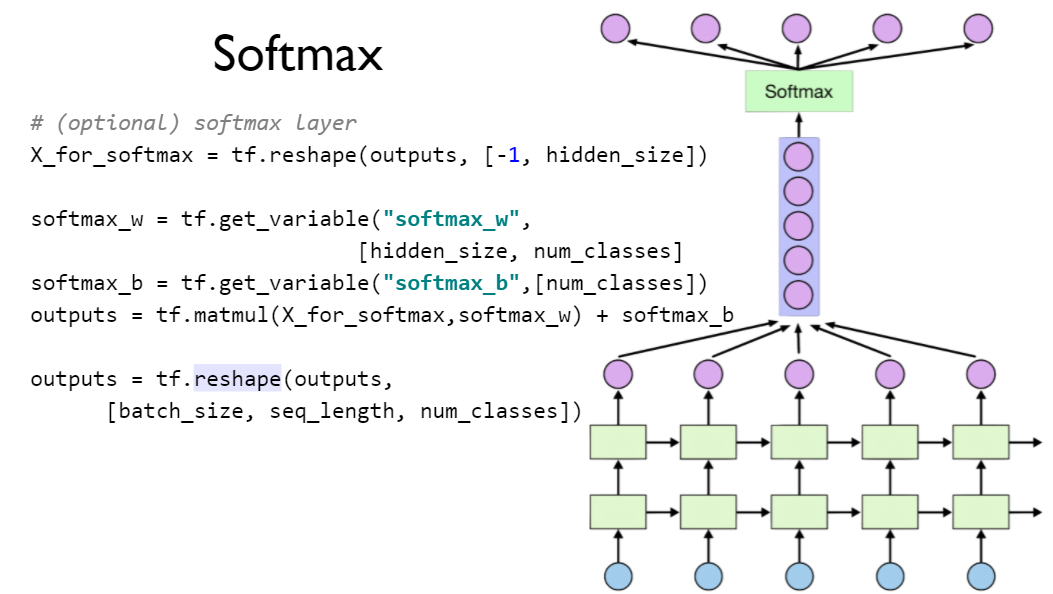

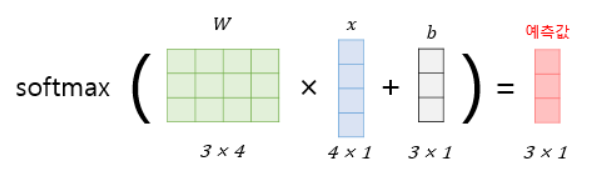

### Initialize

In [2]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

char_set = list(set(sentence))
char_dic = {w: i for i, w in enumerate(char_set)}

data_dim = len(char_set)
hidden_size = len(char_set)
num_classes = len(char_set)
sequence_length = 10  # Any arbitrary number
learning_rate = 0.1

C:\Users\user\anaconda3\envs\tf\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### One-hot encoding

In [3]:
dataX = []
dataY = []
for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x = [char_dic[c] for c in x_str]  # x str to index
    y = [char_dic[c] for c in y_str]  # y str to index

    dataX.append(x)
    dataY.append(y)

batch_size = len(dataX)

X = tf.placeholder(tf.int32, [None, sequence_length])
Y = tf.placeholder(tf.int32, [None, sequence_length])

# One-hot encoding
X_one_hot = tf.one_hot(X, num_classes)
print(X_one_hot)  # check out the shape

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

### Create cell

In [5]:
def lstm_cell():
    cell = rnn.BasicLSTMCell(hidden_size, state_is_tuple=True)
    return cell

                              # cell() * 2 
multi_cells = rnn.MultiRNNCell([lstm_cell() for _ in range(2)], state_is_tuple=True)

In [7]:
# outputs: unfolding size x hidden size, state = hidden size
outputs, _states = tf.nn.dynamic_rnn(multi_cells, X_one_hot, dtype=tf.float32)

### Fully connected layer

In [9]:
# reshape output for FC layer
X_for_fc = tf.reshape(outputs, [-1, hidden_size])

# FC layer(softmax)
outputs = tf.contrib.layers.fully_connected(X_for_fc, num_classes, activation_fn=None)

# reshape out for sequence_loss
outputs = tf.reshape(outputs, [batch_size, sequence_length, num_classes])

### Train RNN

In [10]:
# All weights are 1 (equal weights)
weights = tf.ones([batch_size, sequence_length])

sequence_loss = tf.contrib.seq2seq.sequence_loss(logits=outputs, targets=Y, weights=weights)
mean_loss = tf.reduce_mean(sequence_loss)
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_loss)

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
    _, l, results = sess.run([train_op, mean_loss, outputs], feed_dict={X: dataX, Y: dataY})
    for j, result in enumerate(results):
        index = np.argmax(result, axis=1)
        print("*",i, j, ''.join([char_set[t] for t in index]), l)

# Let's print the last char of each result to check it works
results = sess.run(outputs, feed_dict={X: dataX})
for j, result in enumerate(results):
    index = np.argmax(result, axis=1)
    if j is 0:  # print all for the first result to make a sentence
        print(''.join([char_set[t] for t in index]), end='')
    else:
        print(char_set[index[-1]], end='')

* 0 0 tttkkuwwww 3.2181041
* 0 1 fkkkwwwwww 3.2181041
* 0 2 k wwwwwwww 3.2181041
* 0 3 ruwwwwwwww 3.2181041
* 0 4 iwwwwwwwww 3.2181041
* 0 5 w       ww 3.2181041
* 0 6 ky     ww  3.2181041
* 0 7 cw    ww   3.2181041
* 0 8 ty   ww    3.2181041
* 0 9 yw  ww     3.2181041
* 0 10 l  ww      3.2181041
* 0 11 k ww       3.2181041
* 0 12 llw      y 3.2181041
* 0 13 iw         3.2181041
* 0 14 kk    y    3.2181041
* 0 15     uyy    3.2181041
* 0 16 w uuyyy    3.2181041
* 0 17 ttuuyy     3.2181041
* 0 18 bbyyy      3.2181041
* 0 19 fkkk       3.2181041
* 0 20 k        f 3.2181041
* 0 21 t   rrhfff 3.2181041
* 0 22 k  rrfffff 3.2181041
* 0 23 llrrhhffff 3.2181041
* 0 24 rrfffffffc 3.2181041
* 0 25 tfhffffecc 3.2181041
* 0 26 wfffffeeee 3.2181041
* 0 27 hbeeeeeeee 3.2181041
* 0 28 kknnneweew 3.2181041
* 0 29 ffeeeueuuw 3.2181041
* 0 30 iweeweewww 3.2181041
* 0 31 ypbbeeuww  3.2181041
* 0 32 bbbbhuww w 3.2181041
* 0 33 l ffww  ww 3.2181041
* 0 34 kkyy   www 3.2181041
* 0 35 ffuw  wwww 3.2181041
* 

* 2 6 dm..c      3.1354852
* 2 7 dddcc      3.1354852
* 2 8 dd..c      3.1354852
* 2 9 dm..c      3.1354852
* 2 10 dm,.c      3.1354852
* 2 11 dm,.c      3.1354852
* 2 12 dd,ec      3.1354852
* 2 13 dd,cc    n 3.1354852
* 2 14 dm..c    n 3.1354852
* 2 15 dddcc    n 3.1354852
* 2 16 dddcc      3.1354852
* 2 17 dddcc      3.1354852
* 2 18 dd..c      3.1354852
* 2 19 dm..c      3.1354852
* 2 20 dm..c      3.1354852
* 2 21 dd.cc      3.1354852
* 2 22 dm..c      3.1354852
* 2 23 dd,c       3.1354852
* 2 24 dd.c       3.1354852
* 2 25 dddc     n 3.1354852
* 2 26 dddc       3.1354852
* 2 27 dddc       3.1354852
* 2 28 dm..c      3.1354852
* 2 29 dd.c       3.1354852
* 2 30 dd.c       3.1354852
* 2 31 dm.cc    n 3.1354852
* 2 32 dddcc    n 3.1354852
* 2 33 dm,.c    n 3.1354852
* 2 34 dm..c    n 3.1354852
* 2 35 dd.cc    n 3.1354852
* 2 36 dddcc      3.1354852
* 2 37 ddy.cc     3.1354852
* 2 38 dmy.cc     3.1354852
* 2 39 dm..c      3.1354852
* 2 40 dd.cc      3.1354852
* 2 41 dd..c      3.1354

* 5 16 eoooootooo 3.0396266
* 5 17 eoooottoto 3.0396266
* 5 18 eooottotoo 3.0396266
* 5 19 eoottotoot 3.0396266
* 5 20 eoototooto 3.0396266
* 5 21 eoootootoo 3.0396266
* 5 22 eoooootooo 3.0396266
* 5 23 eooootoooo 3.0396266
* 5 24 eooooooooo 3.0396266
* 5 25 eootooooot 3.0396266
* 5 26 eotoooooto 3.0396266
* 5 27 eooooootoo 3.0396266
* 5 28 eooooooooo 3.0396266
* 5 29 eooooooooo 3.0396266
* 5 30 eooooooooo 3.0396266
* 5 31 eoooooooto 3.0396266
* 5 32 eooooootoo 3.0396266
* 5 33 eoooooooot 3.0396266
* 5 34 eooootooto 3.0396266
* 5 35 eooooootoo 3.0396266
* 5 36 eoooootooo 3.0396266
* 5 37 eotttttooo 3.0396266
* 5 38 eootttoooo 3.0396266
* 5 39 eooooooooo 3.0396266
* 5 40 eooooooooo 3.0396266
* 5 41 eooooooooo 3.0396266
* 5 42 eooooooooo 3.0396266
* 5 43 eooooooooo 3.0396266
* 5 44 eooooooooo 3.0396266
* 5 45 eooooooooo 3.0396266
* 5 46 eooooooooo 3.0396266
* 5 47 eooooooooo 3.0396266
* 5 48 eooooooooo 3.0396266
* 5 49 eooooooooo 3.0396266
* 5 50 eooooooooo 3.0396266
* 5 51 eooooooooo 3.

* 7 45 ettttttttt 2.9173706
* 7 46 ettttttttt 2.9173706
* 7 47 ettttttttt 2.9173706
* 7 48 ettttttttt 2.9173706
* 7 49 ettttttttt 2.9173706
* 7 50 ettttttttt 2.9173706
* 7 51 ettttttttt 2.9173706
* 7 52 ettttttttt 2.9173706
* 7 53 ettttttttt 2.9173706
* 7 54 ettttttttt 2.9173706
* 7 55 ettttttttt 2.9173706
* 7 56 ettttttttt 2.9173706
* 7 57 ettttttttt 2.9173706
* 7 58 ettttttttt 2.9173706
* 7 59 ettttttttt 2.9173706
* 7 60 ettttttttt 2.9173706
* 7 61 ettttttttt 2.9173706
* 7 62 ettttttttt 2.9173706
* 7 63 ettttttttt 2.9173706
* 7 64 ettttttttt 2.9173706
* 7 65 ettttttttt 2.9173706
* 7 66 ettttttttt 2.9173706
* 7 67 ettttttttt 2.9173706
* 7 68 ettttttttt 2.9173706
* 7 69 ettttttttt 2.9173706
* 7 70 ettttttttt 2.9173706
* 7 71 ettttttttt 2.9173706
* 7 72 ettttttttt 2.9173706
* 7 73 ettttttttt 2.9173706
* 7 74 ettttttttt 2.9173706
* 7 75 ettttttttt 2.9173706
* 7 76 ettttttttt 2.9173706
* 7 77 ettttttttt 2.9173706
* 7 78 ettttttttt 2.9173706
* 7 79 ettttttttt 2.9173706
* 7 80 ettttttttt 2.

* 9 0            2.8607256
* 9 1            2.8607256
* 9 2            2.8607256
* 9 3            2.8607256
* 9 4            2.8607256
* 9 5            2.8607256
* 9 6            2.8607256
* 9 7 e          2.8607256
* 9 8            2.8607256
* 9 9            2.8607256
* 9 10            2.8607256
* 9 11            2.8607256
* 9 12            2.8607256
* 9 13            2.8607256
* 9 14            2.8607256
* 9 15            2.8607256
* 9 16            2.8607256
* 9 17            2.8607256
* 9 18            2.8607256
* 9 19            2.8607256
* 9 20            2.8607256
* 9 21            2.8607256
* 9 22            2.8607256
* 9 23            2.8607256
* 9 24            2.8607256
* 9 25            2.8607256
* 9 26            2.8607256
* 9 27            2.8607256
* 9 28            2.8607256
* 9 29            2.8607256
* 9 30            2.8607256
* 9 31            2.8607256
* 9 32            2.8607256
* 9 33            2.8607256
* 9 34            2.8607256
* 9 35            2.8607256
* 

* 12 60            2.823328
* 12 61            2.823328
* 12 62            2.823328
* 12 63            2.823328
* 12 64            2.823328
* 12 65            2.823328
* 12 66            2.823328
* 12 67            2.823328
* 12 68            2.823328
* 12 69            2.823328
* 12 70            2.823328
* 12 71            2.823328
* 12 72            2.823328
* 12 73            2.823328
* 12 74            2.823328
* 12 75            2.823328
* 12 76            2.823328
* 12 77            2.823328
* 12 78            2.823328
* 12 79            2.823328
* 12 80            2.823328
* 12 81            2.823328
* 12 82            2.823328
* 12 83            2.823328
* 12 84            2.823328
* 12 85            2.823328
* 12 86            2.823328
* 12 87            2.823328
* 12 88            2.823328
* 12 89            2.823328
* 12 90            2.823328
* 12 91            2.823328
* 12 92            2.823328
* 12 93            2.823328
* 12 94            2.823328
* 12 95            2

* 15 152   t   t    2.726909
* 15 153  t   t   t 2.726909
* 15 154     t   t  2.726909
* 15 155    t   t   2.726909
* 15 156   t   t  t 2.726909
* 15 157  tt  t  t  2.726909
* 15 158     t  t   2.726909
* 15 159    t  t  t 2.726909
* 15 160   t  t  t  2.726909
* 15 161  t  t  t   2.726909
* 15 162    t  t  t 2.726909
* 15 163   t  t  t  2.726909
* 15 164  t  t  t   2.726909
* 15 165    t  t  t 2.726909
* 15 166   t  t  t  2.726909
* 15 167  t  t  t   2.726909
* 15 168    t  tt t 2.726909
* 15 169   t  tt t  2.726909
* 16 0   t e  e t 2.683654
* 16 1  t e  e t  2.683654
* 16 2   t  e t t 2.683654
* 16 3  t  e t t  2.683654
* 16 4    e t t e 2.683654
* 16 5   e t t e  2.683654
* 16 6  e t t e e 2.683654
* 16 7 e t t e et 2.683654
* 16 8  t t e et  2.683654
* 16 9   t e et o 2.683654
* 16 10  t e et o  2.683654
* 16 11   t et o t 2.683654
* 16 12    et o t  2.683654
* 16 13   et o t t 2.683654
* 16 14  t  o t t  2.683654
* 16 15 e  o t t e 2.683654
* 16 16   o t t eo 2.683654
* 16 17    t

* 18 165 o  te toet 2.55234
* 18 166 o te toett 2.55234
* 18 167  te toett  2.55234
* 18 168    toett t 2.55234
* 18 169 o toett t  2.55234
* 19 0 e t tt e t 2.4668455
* 19 1  t tt e t  2.4668455
* 19 2 t tt e t t 2.4668455
* 19 3  tt e t te 2.4668455
* 19 4 et e t te  2.4668455
* 19 5 t e t te t 2.4668455
* 19 6 te t te tt 2.4668455
* 19 7 e t te ttt 2.4668455
* 19 8  t te ttt  2.4668455
* 19 9   te ttt e 2.4668455
* 19 10 ote ttt e  2.4668455
* 19 11 totttt e t 2.4668455
* 19 12 otttt e t  2.4668455
* 19 13 e tt e t t 2.4668455
* 19 14 ttt e t t  2.4668455
* 19 15 et e t t e 2.4668455
* 19 16 t e t t ee 2.4668455
* 19 17 ee t t eet 2.4668455
* 19 18 e t t eet  2.4668455
* 19 19  t t e t t 2.4668455
* 19 20 t t e t t  2.4668455
* 19 21  t e t t t 2.4668455
* 19 22 t eet t t  2.4668455
* 19 23  eet t t t 2.4668455
* 19 24 ete t t t  2.4668455
* 19 25 e  t t t t 2.4668455
* 19 26 o t t t t  2.4668455
* 19 27   ot t t t 2.4668455
* 19 28 t t t t tt 2.4668455
* 19 29  t t t tt  2.4668455


* 22 105  te  t ttt 2.2507503
* 22 106 te  t tti  2.2507503
* 22 107 e  t tti t 2.2507503
* 22 108 o t tti t  2.2507503
* 22 109  t tti t t 2.2507503
* 22 110   tti t to 2.2507503
* 22 111  tui t toe 2.2507503
* 22 112 tt  t toet 2.2507503
* 22 113 tt t toet  2.2507503
* 22 114 t t toet t 2.2507503
* 22 115 ot toet to 2.2507503
* 22 116 t toe  tot 2.2507503
* 22 117  toe  tot  2.2507503
* 22 118  eot tot e 2.2507503
* 22 119 oe  tot e  2.2507503
* 22 120 ot tot e t 2.2507503
* 22 121   totse to 2.2507503
* 22 122  totse toe 2.2507503
* 22 123 to te toe  2.2507503
* 22 124 otse toe o 2.2507503
* 22 125   e toe  t 2.2507503
* 22 126  eotoet to 2.2507503
* 22 127 e toet to  2.2507503
* 22 128 otoet to t 2.2507503
* 22 129 toet to to 2.2507503
* 22 130 oe  to to  2.2507503
* 22 131 ot to to t 2.2507503
* 22 132   totto t  2.2507503
* 22 133  totto t t 2.2507503
* 22 134 to to t t  2.2507503
* 22 135 otto t t t 2.2507503
* 22 136 o e t t t  2.2507503
* 22 137 to t t t t 2.2507503
* 22 138 o

* 24 64 eost teee  2.1084452
* 24 65 e t teee t 2.1084452
* 24 66  e teee tn 2.1084452
* 24 67 e teee tnt 2.1084452
* 24 68 oteee tnt  2.1084452
* 24 69 teer tnt t 2.1084452
* 24 70 et  tst to 2.1084452
* 24 71 e  tst tot 2.1084452
* 24 72 e tnt tot  2.1084452
* 24 73  tsn tot t 2.1084452
* 24 74 tst tot t  2.1084452
* 24 75  t tot t t 2.1084452
* 24 76   t t t tn 2.1084452
* 24 77  totnt tt  2.1084452
* 24 78 tot t tt s 2.1084452
* 24 79  t t tt sn 2.1084452
* 24 80 e t tt snn 2.1084452
* 24 81  t tt snn  2.1084452
* 24 82 t tt snn t 2.1084452
* 24 83 ott snn th 2.1084452
* 24 84 tsssnn the 2.1084452
* 24 85  nsnn ther 2.1084452
* 24 86   nn ther  2.1084452
* 24 87  tn ther t 2.1084452
* 24 88 e  ther th 2.1084452
* 24 89 e ther ths 2.1084452
* 24 90  toer thsn 2.1084452
* 24 91 ther thsns 2.1084452
* 24 92 oer thsns  2.1084452
* 24 93 et thsns t 2.1084452
* 24 94   thsns ts 2.1084452
* 24 95  tosnsstst 2.1084452
* 24 96 thsns tst  2.1084452
* 24 97 osnsstst t 2.1084452
* 24 98  nssts

* 26 27  be  t tot 1.9654933
* 26 28 tor t totn 1.9654933
* 26 29  t t totn  1.9654933
* 26 30 o t tost t 1.9654933
* 26 31  t tost tu 1.9654933
* 26 32 t tost tu  1.9654933
* 26 33 otost tu t 1.9654933
* 26 34 tost tu te 1.9654933
* 26 35  st tu te  1.9654933
* 26 36  t tt te r 1.9654933
* 26 37 t tt te r  1.9654933
* 26 38  tt te r e 1.9654933
* 26 39 tt te e e  1.9654933
* 26 40 t te r e t 1.9654933
* 26 41 ere eoe to 1.9654933
* 26 42 te r e to  1.9654933
* 26 43 e moe to o 1.9654933
* 26 44  n e to    1.9654933
* 26 45 oee to o e 1.9654933
* 26 46 ee to o ee 1.9654933
* 26 47 e to   eer 1.9654933
* 26 48  to o eer  1.9654933
* 26 49 to o eer t 1.9654933
* 26 50 o   eer to 1.9654933
* 26 51 o  eer to  1.9654933
* 26 52 o eer to r 1.9654933
* 26 53  oer to me 1.9654933
* 26 54 oe  to me  1.9654933
* 26 55 et to me e 1.9654933
* 26 56   to me eo 1.9654933
* 26 57  to re eos 1.9654933
* 26 58 to te eest 1.9654933
* 26 59 o me eest  1.9654933
* 26 60 o e eest t 1.9654933
* 26 61 te ees

* 28 0 t t t test 1.8576702
* 28 1  t t  est  1.8576702
* 28 2 t t test t 1.8576702
* 28 3  t test to 1.8576702
* 28 4 ts est to  1.8576702
* 28 5 t tst to t 1.8576702
* 28 6 test to tt 1.8576702
* 28 7 est to ttn 1.8576702
* 28 8  t to ttn  1.8576702
* 28 9 n to rtn t 1.8576702
* 28 10 oto rtn t  1.8576702
* 28 11 to rtn t t 1.8576702
* 28 12 o  tn t ts 1.8576702
* 28 13 t tn t tst 1.8576702
* 28 14 ttn t tst  1.8576702
* 28 15 tt t t t e 1.8576702
* 28 16 t t tst er 1.8576702
* 28 17 tt tst ert 1.8576702
* 28 18 e tst ert  1.8576702
* 28 19 otst err b 1.8576702
* 28 20 tst e,r bo 1.8576702
* 28 21  t etr bon 1.8576702
* 28 22 tnetr bon  1.8576702
* 28 23  otr bon t 1.8576702
* 28 24 etr ton t  1.8576702
* 28 25 tt bon t t 1.8576702
* 28 26 o ton t to 1.8576702
* 28 27  be nt tot 1.8576702
* 28 28 tor t totn 1.8576702
* 28 29 on t totn  1.8576702
* 28 30 t t totn t 1.8576702
* 28 31 nt tonn tt 1.8576702
* 28 32 t totn tt  1.8576702
* 28 33 otont tt t 1.8576702
* 28 34 totn tt te 1.857

* 29 163 n t  tr to 1.799808
* 29 164 nn  tr toe 1.799808
* 29 165 t  tr toe  1.799808
* 29 166 o tr toe t 1.799808
* 29 167  tm toe t  1.799808
* 29 168 tp toe t s 1.799808
* 29 169 t toe a sk 1.799808
* 30 0 t t t test 1.7943109
* 30 1  t t test  1.7943109
* 30 2 a t test t 1.7943109
* 30 3  t tent to 1.7943109
* 30 4 d  en, to  1.7943109
* 30 5 n en, to a 1.7943109
* 30 6 ae t to a, 1.7943109
* 30 7 est to a,n 1.7943109
* 30 8 nt to a,g  1.7943109
* 30 9 n ao e,g t 1.7943109
* 30 10 oao e,g t  1.7943109
* 30 11 ao r,g t t 1.7943109
* 30 12 o  tn t t  1.7943109
* 30 13 d tn t t t 1.7943109
* 30 14 atnlt t to 1.7943109
* 30 15 tn t t toe 1.7943109
* 30 16 n t t toer 1.7943109
* 30 17 tr tndoer, 1.7943109
* 30 18 o tnaoer,  1.7943109
* 30 19 otnroer, b 1.7943109
* 30 20 anroer, bo 1.7943109
* 30 21 ntle,, bon 1.7943109
* 30 22 ame,, bon  1.7943109
* 30 23 nr,, ton t 1.7943109
* 30 24 e,r ton t  1.7943109
* 30 25 tt ton t t 1.7943109
* 30 26 o ton t to 1.7943109
* 30 27  bon t tot 1.794

* 33 0 ahtht aest 1.5983349
* 33 1 htht aest  1.5983349
* 33 2 aht aest t 1.5983349
* 33 3  t aest to 1.5983349
* 33 4 a  ant to  1.5983349
* 33 5 n ant to a 1.5983349
* 33 6 aest to au 1.5983349
* 33 7 est to aum 1.5983349
* 33 8 st to auml 1.5983349
* 33 9 n ao aumlt 1.5983349
* 33 10 hao aumlt  1.5983349
* 33 11 ao aumlt t 1.5983349
* 33 12 h  uplt ts 1.5983349
* 33 13 a unlt tsa 1.5983349
* 33 14 aunlt tsao 1.5983349
* 33 15 ut t tsaor 1.5983349
* 33 16 n t tsaorp 1.5983349
* 33 17 ap tsaorp, 1.5983349
* 33 18 o tsaorp,  1.5983349
* 33 19  tsaorp, t 1.5983349
* 33 20 asaorp, to 1.5983349
* 33 21 stmap, ton 1.5983349
* 33 22 amrp, tons 1.5983349
* 33 23 napu tonst 1.5983349
* 33 24 ep, tonst  1.5983349
* 33 25 au tonst t 1.5983349
* 33 26 o thn t to 1.5983349
* 33 27  wos t tot 1.5983349
* 33 28 aop t totn 1.5983349
* 33 29  nst totn  1.5983349
* 33 30 a t totn t 1.5983349
* 33 31 nt totn tp 1.5983349
* 33 32 t totn tp  1.5983349
* 33 33 haoap tp t 1.5983349
* 33 34 aotp tp te 1.598

* 34 164 nn  tp toe 1.493051
* 34 165 a  tm toe  1.493051
* 34 166 o tm toe a 1.493051
* 34 167  tm toe al 1.493051
* 34 168 tp toe als 1.493051
* 34 169 m toe alss 1.493051
* 35 0 dot p'ttst 1.4551022
* 35 1 oehp ttst  1.4551022
* 35 2 thp'ttst t 1.4551022
* 35 3  t ttst to 1.4551022
* 35 4 m lost to  1.4551022
* 35 5 n tst to l 1.4551022
* 35 6 test to lu 1.4551022
* 35 7 est to lui 1.4551022
* 35 8 st to luil 1.4551022
* 35 9 n ao luilp 1.4551022
* 35 10 oao luilp  1.4551022
* 35 11 to luilp t 1.4551022
* 35 12 o luilp t  1.4551022
* 35 13 m uilp t t 1.4551022
* 35 14 tuilp t tl 1.4551022
* 35 15 unlt t tld 1.4551022
* 35 16 nlt tstldp 1.4551022
* 35 17 dp tstldp, 1.4551022
* 35 18 o tstldp,  1.4551022
* 35 19  tstldp, w 1.4551022
* 35 20 tstldp, wo 1.4551022
* 35 21 stinp, ton 1.4551022
* 35 22 tmnp, won' 1.4551022
* 35 23 nnp, won't 1.4551022
* 35 24 ep, won't  1.4551022
* 35 25 du ton't t 1.4551022
* 35 26 o ton't to 1.4551022
* 35 27  won't tou 1.4551022
* 35 28 top't toum 1.455

* 36 124 otco toe   1.3723489
* 36 125 asa toe  t 1.3723489
* 36 126 st toe  to 1.3723489
* 36 127 o toem to  1.3723489
* 36 128 eaoe  to   1.3723489
* 36 129 toem to  o 1.3723489
* 36 130 oem to  on 1.3723489
* 36 131 em to  ong 1.3723489
* 36 132 a to  ong  1.3723489
* 36 133  to long d 1.3723489
* 36 134 to long do 1.3723489
* 36 135 o long doe 1.3723489
* 36 136 m ong doe  1.3723489
* 36 137 tong doe t 1.3723489
* 36 138 ong doe to 1.3723489
* 36 139 m  aoe toe 1.3723489
* 36 140 n toe toe  1.3723489
* 36 141 oaee toe a 1.3723489
* 36 142 tor toe am 1.3723489
* 36 143 op toe amn 1.3723489
* 36 144 m toe lap  1.3723489
* 36 145  toe lap e 1.3723489
* 36 146 toem ap es 1.3723489
* 36 147 oemlap ess 1.3723489
* 36 148 emlmn ess  1.3723489
* 36 149 atmn ess s 1.3723489
* 36 150 tmn ess sd 1.3723489
* 36 151 an oss sdl 1.3723489
* 36 152 n oss sdle 1.3723489
* 36 153  ess sdlen 1.3723489
* 36 154 o s sdlens 1.3723489
* 36 155 aissddens  1.3723489
* 36 156  ssldens d 1.3723489
* 36 157  

* 40 0 a top aost 1.141145
* 40 1 haop aost  1.141145
* 40 2 top aost u 1.141145
* 40 3  d aost uo 1.141145
* 40 4 m aost uo  1.141145
* 40 5   ast uo a 1.141145
* 40 6 tost uo au 1.141145
* 40 7 ost uo aui 1.141145
* 40 8 ss uo auil 1.141145
* 40 9   eo build 1.141145
* 40 10 hao build  1.141145
* 40 11 to luild t 1.141145
* 40 12 h luild t  1.141145
* 40 13 m uilp t s 1.141145
* 40 14 tuilp t sl 1.141145
* 40 15 ui t t sll 1.141145
* 40 16   t t sllp 1.141145
* 40 17 ap t sllpp 1.141145
* 40 18 o t shlpp  1.141145
* 40 19  tsthlpp u 1.141145
* 40 20 tsthlpp uo 1.141145
* 40 21 stllpp uon 1.141145
* 40 22 tmlp, uon' 1.141145
* 40 23  lp, uon't 1.141145
* 40 24 ap, won't  1.141145
* 40 25 au uon't t 1.141145
* 40 26 o ton't to 1.141145
* 40 27  bon't tou 1.141145
* 40 28 ton't toum 1.141145
* 40 29  n't toum  1.141145
* 40 30 m t toum u 1.141145
* 40 31  t aoum up 1.141145
* 40 32 t toum up  1.141145
* 40 33 haerm up u 1.141145
* 40 34 toum up ue 1.141145
* 40 35  tm up ueo 1.141145
* 

* 43 16 ild t thlp 0.95795697
* 43 17 mp t shlp, 0.95795697
* 43 18 o t thlp,  0.95795697
* 43 19  tnthlp, d 0.95795697
* 43 20 tsshlp, do 0.95795697
* 43 21 sthcp, don 0.95795697
* 43 22 tmlp, don' 0.95795697
* 43 23  lp, don't 0.95795697
* 43 24 ap, don't  0.95795697
* 43 25 m, don't a 0.95795697
* 43 26 a ton't ao 0.95795697
* 43 27  bon't aou 0.95795697
* 43 28 ten't aoum 0.95795697
* 43 29  n't aoum  0.95795697
* 43 30 mgt aeum u 0.95795697
* 43 31 nt aeum up 0.95795697
* 43 32 t toum up  0.95795697
* 43 33 heerm up u 0.95795697
* 43 34 teum up uo 0.95795697
* 43 35  ty up ueo 0.95795697
* 43 36  t dp ueop 0.95795697
* 43 37 i tp ueopl 0.95795697
* 43 38  tp ueople 0.95795697
* 43 39 tt deople  0.95795697
* 43 40 i eeople t 0.95795697
* 43 41 aoeople th 0.95795697
* 43 42 toeple th  0.95795697
* 43 43 aafle th o 0.95795697
* 43 44  dle th on 0.95795697
* 43 45 mle th onh 0.95795697
* 43 46 ao th onhe 0.95795697
* 43 47 o th onher 0.95795697
* 43 48  th onher  0.95795697
* 43 49 to

* 44 157  dppensity 0.8825588
* 44 158 tpmensity  0.8825588
* 44 159 mmensity a 0.8825588
* 44 160  ensity af 0.8825588
* 44 161  tsiiy af  0.8825588
* 44 162  d dy af t 0.8825588
* 44 163 niiy af to 0.8825588
* 44 164  gm af toe 0.8825588
* 44 165 mm af toe  0.8825588
* 44 166 h of toe e 0.8825588
* 44 167  ef toe eh 0.8825588
* 44 168 tf toe ehc 0.8825588
* 44 169 m toe ehcc 0.8825588
* 45 0 m top  ant 0.84243876
* 45 1 haou aant  0.84243876
* 45 2 aou aant u 0.84243876
* 45 3  d aant uo 0.84243876
* 45 4 m  ant uo  0.84243876
* 45 5 iiant uo l 0.84243876
* 45 6 aont uo lu 0.84243876
* 45 7 ont uo lui 0.84243876
* 45 8 sd eo luil 0.84243876
* 45 9 n eo luild 0.84243876
* 45 10 heo build  0.84243876
* 45 11 ao luild a 0.84243876
* 45 12 h luild a  0.84243876
* 45 13 mluild a s 0.84243876
* 45 14 autld a sh 0.84243876
* 45 15 utid a shi 0.84243876
* 45 16 iid anship 0.84243876
* 45 17 mp wnship, 0.84243876
* 45 18 e t sh p,  0.84243876
* 45 19  tnsh p, d 0.84243876
* 45 20 assh p, do 0

* 46 123 aonch them 0.7917623
* 46 124 htch them  0.7917623
* 46 125  s  them t 0.7917623
* 46 126 s  them to 0.7917623
* 46 127 o toem to  0.7917623
* 46 128 eaoem to c 0.7917623
* 46 129 aoem to ce 0.7917623
* 46 130 hem to len 0.7917623
* 46 131 ea to leng 0.7917623
* 46 132   to leng  0.7917623
* 46 133  uo leng u 0.7917623
* 46 134 ao leng uo 0.7917623
* 46 135 h long uor 0.7917623
* 46 136 mleng uor  0.7917623
* 46 137 aong uor t 0.7917623
* 46 138 edg eor to 0.7917623
* 46 139 mg dor toe 0.7917623
* 46 140 n tor toe  0.7917623
* 46 141 oeor toe e 0.7917623
* 46 142 aor toe en 0.7917623
* 46 143 hr toe end 0.7917623
* 46 144 m toe endl 0.7917623
* 46 145 atoe endle 0.7917623
* 46 146 aoemendles 0.7917623
* 46 147 hemendless 0.7917623
* 46 148 eaendless  0.7917623
* 46 149  tmdless i 0.7917623
* 46 150 amdless im 0.7917623
* 46 151  dless imm 0.7917623
* 46 152 n ess imme 0.7917623
* 46 153  ess immen 0.7917623
* 46 154 e s immens 0.7917623
* 46 155   iimmensi 0.7917623
* 46 156  

* 48 83  wssggn th 0.70037514
* 48 84 wnsidn the 0.70037514
* 48 85 ssign them 0.70037514
* 48 86   gn them  0.70037514
* 48 87  gn them t 0.70037514
* 48 88 pn them ta 0.70037514
* 48 89 a toem tas 0.70037514
* 48 90 ndhem ta s 0.70037514
* 48 91 woem ta ss 0.70037514
* 48 92  er tasss  0.70037514
* 48 93 ea tasss a 0.70037514
* 48 94   tasks an 0.70037514
* 48 95  uasks and 0.70037514
* 48 96 wosks and  0.70037514
* 48 97  sks and w 0.70037514
* 48 98 sss and wo 0.70037514
* 48 99  s and wor 0.70037514
* 48 100 t and dork 0.70037514
* 48 101  isd dork, 0.70037514
* 48 102 wnd dorc,  0.70037514
* 48 103 sd aork, b 0.70037514
* 48 104 nltork, bu 0.70037514
* 48 105  tork, but 0.70037514
* 48 106 wook, but  0.70037514
* 48 107 aok, but a 0.70037514
* 48 108 r , but ea 0.70037514
* 48 109 a, but aat 0.70037514
* 48 110 t but aath 0.70037514
* 48 111  wut eathe 0.70037514
* 48 112 wut eather 0.70037514
* 48 113 ui eather  0.70037514
* 48 114 i wather t 0.70037514
* 48 115  wather to 0.700

* 52 3  u want to 0.5781696
* 52 4 l want to  0.5781696
* 52 5 iltnt to b 0.5781696
* 52 6 wont to bu 0.5781696
* 52 7 ant to bui 0.5781696
* 52 8 sd to buil 0.5781696
* 52 9 n fo build 0.5781696
* 52 10  wo build  0.5781696
* 52 11 wo build a 0.5781696
* 52 12   build a  0.5781696
* 52 13 lluild a s 0.5781696
* 52 14 wuild a sh 0.5781696
* 52 15 uild a shi 0.5781696
* 52 16 ild a ship 0.5781696
* 52 17 md a ship, 0.5781696
* 52 18 e t ship,  0.5781696
* 52 19  t ship, d 0.5781696
* 52 20 wsship, do 0.5781696
* 52 21 ssmip, don 0.5781696
* 52 22 wmip, doni 0.5781696
* 52 23  ip, don't 0.5781696
* 52 24 ep, don't  0.5781696
* 52 25 m, don't d 0.5781696
* 52 26 e don't dr 0.5781696
* 52 27  don't dru 0.5781696
* 52 28 wen't drum 0.5781696
* 52 29  n't arum  0.5781696
* 52 30 lgt trum u 0.5781696
* 52 31 nt arum up 0.5781696
* 52 32 t trum up  0.5781696
* 52 33  weum up p 0.5781696
* 52 34 weum up pr 0.5781696
* 52 35  um up pro 0.5781696
* 52 36 at up prop 0.5781696
* 52 37 i up propl 0.

* 53 126 sh them ta 0.54459375
* 53 127 t them to  0.54459375
* 53 128 etoem to c 0.54459375
* 53 129 toem to co 0.54459375
* 53 130  em to bon 0.54459375
* 53 131 em to long 0.54459375
* 53 132   ta long  0.54459375
* 53 133  ua long f 0.54459375
* 53 134 to bong fo 0.54459375
* 53 135   cong for 0.54459375
* 53 136 llong for  0.54459375
* 53 137 tong for t 0.54459375
* 53 138 ed' for to 0.54459375
* 53 139 lg for the 0.54459375
* 53 140 n tor the  0.54459375
* 53 141 ator the e 0.54459375
* 53 142 tor toe en 0.54459375
* 53 143  r toe end 0.54459375
* 53 144 l toe endl 0.54459375
* 53 145 atoe endle 0.54459375
* 53 146 toemendles 0.54459375
* 53 147  emendless 0.54459375
* 53 148 emendless  0.54459375
* 53 149  tmdless i 0.54459375
* 53 150 tmdless im 0.54459375
* 53 151  dless imm 0.54459375
* 53 152 n ess imme 0.54459375
* 53 153  e s immen 0.54459375
* 53 154 e s immens 0.54459375
* 53 155   iimmensi 0.54459375
* 53 156   immensit 0.54459375
* 53 157  immensity 0.54459375
* 53 158

* 55 81 nt assign  0.49596852
* 55 82 t assign t 0.49596852
* 55 83  essign th 0.49596852
* 55 84 wnsign the 0.49596852
* 55 85 sssgn them 0.49596852
* 55 86   gn them  0.49596852
* 55 87  gn them t 0.49596852
* 55 88 pn them ta 0.49596852
* 55 89   them tas 0.49596852
* 55 90 ndhem task 0.49596852
* 55 91 woem tasks 0.49596852
* 55 92  em tosks  0.49596852
* 55 93 em tosks a 0.49596852
* 55 94   tasks an 0.49596852
* 55 95  uasks and 0.49596852
* 55 96 wosks and  0.49596852
* 55 97  sks and a 0.49596852
* 55 98 sss and ao 0.49596852
* 55 99  s and wor 0.49596852
* 55 100 , and work 0.49596852
* 55 101  tnd work, 0.49596852
* 55 102 wnd dork,  0.49596852
* 55 103 sd work, b 0.49596852
* 55 104 nltork, bu 0.49596852
* 55 105  tork, but 0.49596852
* 55 106 wook, but  0.49596852
* 55 107 ark, but r 0.49596852
* 55 108 r , but ra 0.49596852
* 55 109  , but rat 0.49596852
* 55 110 , but rath 0.49596852
* 55 111  but eathe 0.49596852
* 55 112 wui eather 0.49596852
* 55 113 ui eather  0.49596

* 58 160  ensity of 0.4320529
* 58 161  tsity of  0.4320529
* 58 162  dity of t 0.4320529
* 58 163 t ty of th 0.4320529
* 58 164  gy of the 0.4320529
* 58 165 py of the  0.4320529
* 58 166 h of the s 0.4320529
* 58 167  of the se 0.4320529
* 58 168 tf the sea 0.4320529
* 58 169 r the seac 0.4320529
* 59 0 p tou want 0.4168473
* 59 1  tou want  0.4168473
* 59 2 tou want t 0.4168473
* 59 3  u want to 0.4168473
* 59 4 r want to  0.4168473
* 59 5 plant to l 0.4168473
* 59 6 tont to bu 0.4168473
* 59 7 ant to bui 0.4168473
* 59 8 sd to buil 0.4168473
* 59 9 i fo build 0.4168473
* 59 10 hfo build  0.4168473
* 59 11 togbuild a 0.4168473
* 59 12 h cuild a  0.4168473
* 59 13 rluild a s 0.4168473
* 59 14 tuild a sh 0.4168473
* 59 15 uild a shi 0.4168473
* 59 16 pld a ship 0.4168473
* 59 17 pd a ship, 0.4168473
* 59 18 e a ship,  0.4168473
* 59 19  dnship, d 0.4168473
* 59 20 tnship, do 0.4168473
* 59 21 sthip, don 0.4168473
* 59 22 thip, don' 0.4168473
* 59 23  ip, don't 0.4168473
* 59 24 ep, do

* 60 142 tor the en 0.401438
* 60 143  r the end 0.401438
* 60 144 g the endl 0.401438
* 60 145  toe endle 0.401438
* 60 146 toe endles 0.401438
* 60 147  emendless 0.401438
* 60 148 emendless  0.401438
* 60 149  tmdless i 0.401438
* 60 150 tmdless im 0.401438
* 60 151  dless imm 0.401438
* 60 152 i ess imme 0.401438
* 60 153  ess immen 0.401438
* 60 154 e s immens 0.401438
* 60 155  iiimmensi 0.401438
* 60 156   immensit 0.401438
* 60 157  tmmensity 0.401438
* 60 158 tmmensity  0.401438
* 60 159 pmensity o 0.401438
* 60 160  ensity of 0.401438
* 60 161  tsity of  0.401438
* 60 162  dity of t 0.401438
* 60 163 i ty of th 0.401438
* 60 164  gy of the 0.401438
* 60 165 py of the  0.401438
* 60 166   of the s 0.401438
* 60 167  of the se 0.401438
* 60 168 tf the sea 0.401438
* 60 169 g the seac 0.401438
* 61 0 p you want 0.38902605
* 61 1  tou want  0.38902605
* 61 2 tou want t 0.38902605
* 61 3  u want to 0.38902605
* 61 4 g want to  0.38902605
* 61 5 plant to b 0.38902605
* 61 6 tont to

* 62 140 i for the  0.37747565
* 62 141 ofor the e 0.37747565
* 62 142 tor the en 0.37747565
* 62 143  r the end 0.37747565
* 62 144 g the endl 0.37747565
* 62 145  toe endle 0.37747565
* 62 146 toemendles 0.37747565
* 62 147  emendless 0.37747565
* 62 148 emendless  0.37747565
* 62 149  tndless i 0.37747565
* 62 150 tmdless im 0.37747565
* 62 151  dless imm 0.37747565
* 62 152 i ess imme 0.37747565
* 62 153  ess immen 0.37747565
* 62 154 e s immens 0.37747565
* 62 155  siimmensi 0.37747565
* 62 156  iimmensit 0.37747565
* 62 157  tmmensity 0.37747565
* 62 158 tmmensity  0.37747565
* 62 159 pmensity o 0.37747565
* 62 160  ensity of 0.37747565
* 62 161  tsity of  0.37747565
* 62 162  dity of t 0.37747565
* 62 163 iity of th 0.37747565
* 62 164  gy of the 0.37747565
* 62 165 py of the  0.37747565
* 62 166   of the s 0.37747565
* 62 167  of the se 0.37747565
* 62 168 tf the sea 0.37747565
* 62 169 g the seac 0.37747565
* 63 0 p you want 0.3688653
* 63 1  you want  0.3688653
* 63 2 tou wan

* 66 56   te colle 0.3377915
* 66 57  to collec 0.3377915
* 66 58 to bollect 0.3377915
* 66 59   lollect  0.3377915
* 66 60 rbollect w 0.3377915
* 66 61 tollect wo 0.3377915
* 66 62 tllect woo 0.3377915
* 66 63 rlect wood 0.3377915
* 66 64 eect wood  0.3377915
* 66 65 e t wood a 0.3377915
* 66 66  t wood an 0.3377915
* 66 67 t wood and 0.3377915
* 66 68  tood and  0.3377915
* 66 69 tood and d 0.3377915
* 66 70 ood and do 0.3377915
* 66 71 rd and don 0.3377915
* 66 72 r and don' 0.3377915
* 66 73  tnd don't 0.3377915
* 66 74 tnd don't  0.3377915
* 66 75 sd won't a 0.3377915
* 66 76 s won't as 0.3377915
* 66 77  ton't ass 0.3377915
* 66 78 ton't assi 0.3377915
* 66 79  n't assig 0.3377915
* 66 80 r't dssign 0.3377915
* 66 81 st assign  0.3377915
* 66 82 t assign t 0.3377915
* 66 83  tssign th 0.3377915
* 66 84 tnsign the 0.3377915
* 66 85 skign them 0.3377915
* 66 86  ign them  0.3377915
* 66 87  gn them t 0.3377915
* 66 88 pn them ta 0.3377915
* 66 89 o them tas 0.3377915
* 66 90 sthem 

* 68 0 p you want 0.32556033
* 68 1 oyou want  0.32556033
* 68 2 tou want t 0.32556033
* 68 3 ou want to 0.32556033
* 68 4 r want to  0.32556033
* 68 5 tlant to b 0.32556033
* 68 6 tont to bu 0.32556033
* 68 7 ont to bui 0.32556033
* 68 8 sd to buil 0.32556033
* 68 9 s to build 0.32556033
* 68 10 hto build  0.32556033
* 68 11 togbuild a 0.32556033
* 68 12 h luild a  0.32556033
* 68 13 rbuild a s 0.32556033
* 68 14 tuild a sh 0.32556033
* 68 15 uild a shi 0.32556033
* 68 16 tld a ship 0.32556033
* 68 17 pd a ship, 0.32556033
* 68 18 e a ship,  0.32556033
* 68 19  wnship, d 0.32556033
* 68 20 tnship, do 0.32556033
* 68 21 sship, don 0.32556033
* 68 22 thip, don' 0.32556033
* 68 23  ip, don't 0.32556033
* 68 24 ep, don't  0.32556033
* 68 25 p, don't d 0.32556033
* 68 26 e don't dr 0.32556033
* 68 27  bon't aru 0.32556033
* 68 28 ton't arum 0.32556033
* 68 29  n't arum  0.32556033
* 68 30 r't drum u 0.32556033
* 68 31 st drum up 0.32556033
* 68 32 t drum up  0.32556033
* 68 33 htrum up p 0

* 69 112 tut rather 0.31780058
* 69 113 ut rather  0.31780058
* 69 114 t rather t 0.31780058
* 69 115 hwather te 0.31780058
* 69 116 tather tea 0.31780058
* 69 117  ther teac 0.31780058
* 69 118 sher toach 0.31780058
* 69 119 hem toach  0.31780058
* 69 120 em toach t 0.31780058
* 69 121   teach th 0.31780058
* 69 122  toach the 0.31780058
* 69 123 toach them 0.31780058
* 69 124 hach them  0.31780058
* 69 125  sh them t 0.31780058
* 69 126 sh them to 0.31780058
* 69 127 t them to  0.31780058
* 69 128 ethem to l 0.31780058
* 69 129 toem to lo 0.31780058
* 69 130 hem to lon 0.31780058
* 69 131 em to long 0.31780058
* 69 132   to long  0.31780058
* 69 133  ta long f 0.31780058
* 69 134 toglong fo 0.31780058
* 69 135 h long for 0.31780058
* 69 136 rbong for  0.31780058
* 69 137 tong for t 0.31780058
* 69 138 eng for th 0.31780058
* 69 139 r' for the 0.31780058
* 69 140 d for the  0.31780058
* 69 141 efor the e 0.31780058
* 69 142 tor the en 0.31780058
* 69 143  r the end 0.31780058
* 69 144

* 71 91 toem tasks 0.3095926
* 71 92  er tasks  0.3095926
* 71 93 em tosks a 0.3095926
* 71 94 n tasks an 0.3095926
* 71 95  tasks and 0.3095926
* 71 96 tosks and  0.3095926
* 71 97  sks and w 0.3095926
* 71 98 sss and wo 0.3095926
* 71 99  s and wor 0.3095926
* 71 100 , and work 0.3095926
* 71 101  and work, 0.3095926
* 71 102 tnd dork,  0.3095926
* 71 103 sd work, b 0.3095926
* 71 104 d dork, bu 0.3095926
* 71 105  aork, but 0.3095926
* 71 106 tork, but  0.3095926
* 71 107 ork, but r 0.3095926
* 71 108 r , but ra 0.3095926
* 71 109  , but rat 0.3095926
* 71 110 , but rath 0.3095926
* 71 111  dut rathe 0.3095926
* 71 112 tui rather 0.3095926
* 71 113 ui rather  0.3095926
* 71 114 t rather t 0.3095926
* 71 115  aather te 0.3095926
* 71 116 tather tea 0.3095926
* 71 117  ther teac 0.3095926
* 71 118 sher teach 0.3095926
* 71 119  er teach  0.3095926
* 71 120 em teach t 0.3095926
* 71 121 n teach th 0.3095926
* 71 122  toach the 0.3095926
* 71 123 toach them 0.3095926
* 71 124  ach them 

* 74 162  dity of t 0.30434743
* 74 163 dity of th 0.30434743
* 74 164  gy of the 0.30434743
* 74 165 py of the  0.30434743
* 74 166 h of the s 0.30434743
* 74 167  of the se 0.30434743
* 74 168 tf the sea 0.30434743
* 74 169 r the sea. 0.30434743
* 75 0 p you want 0.3005392
* 75 1  you want  0.3005392
* 75 2 tou want t 0.3005392
* 75 3  u want to 0.3005392
* 75 4 r want to  0.3005392
* 75 5 twant to b 0.3005392
* 75 6 tont to bu 0.3005392
* 75 7 ont to bui 0.3005392
* 75 8 nd to buil 0.3005392
* 75 9 d to build 0.3005392
* 75 10 hto build  0.3005392
* 75 11 to build a 0.3005392
* 75 12 h luild a  0.3005392
* 75 13 rbuild a s 0.3005392
* 75 14 tuild a sh 0.3005392
* 75 15 utld a shi 0.3005392
* 75 16 tld a ship 0.3005392
* 75 17 pd a ship, 0.3005392
* 75 18 e a ship,  0.3005392
* 75 19  anship, d 0.3005392
* 75 20 tnship, do 0.3005392
* 75 21 nship, don 0.3005392
* 75 22 thip, don' 0.3005392
* 75 23 sip, don't 0.3005392
* 75 24 ep, don't  0.3005392
* 75 25 p, don't d 0.3005392
* 75 26 

* 76 122  toach the 0.29107085
* 76 123 toach them 0.29107085
* 76 124 hach them  0.29107085
* 76 125  ch them t 0.29107085
* 76 126 sh them to 0.29107085
* 76 127 t them to  0.29107085
* 76 128 ethem to l 0.29107085
* 76 129 toem to lo 0.29107085
* 76 130 hem to lon 0.29107085
* 76 131 em to long 0.29107085
* 76 132   to long  0.29107085
* 76 133  to long f 0.29107085
* 76 134 to cong fo 0.29107085
* 76 135 h cong for 0.29107085
* 76 136 rbong for  0.29107085
* 76 137 tong for t 0.29107085
* 76 138 eng for th 0.29107085
* 76 139 r' for the 0.29107085
* 76 140 d for the  0.29107085
* 76 141 efor the e 0.29107085
* 76 142 tor the en 0.29107085
* 76 143  r the end 0.29107085
* 76 144 r the endl 0.29107085
* 76 145  toe endle 0.29107085
* 76 146 toemendles 0.29107085
* 76 147 hemendless 0.29107085
* 76 148 emendless  0.29107085
* 76 149  endless i 0.29107085
* 76 150 tndless im 0.29107085
* 76 151  dless imm 0.29107085
* 76 152 d ess imme 0.29107085
* 76 153  ess immen 0.29107085
* 76 154

* 78 89 e them tas 0.2819267
* 78 90 dthem task 0.2819267
* 78 91 toem tosks 0.2819267
* 78 92 her tasks  0.2819267
* 78 93 em tosks a 0.2819267
* 78 94   tasks an 0.2819267
* 78 95  tasks and 0.2819267
* 78 96 tosks and  0.2819267
* 78 97 hsks and w 0.2819267
* 78 98 nks and wo 0.2819267
* 78 99 ss and wor 0.2819267
* 78 100 , and work 0.2819267
* 78 101 sind work, 0.2819267
* 78 102 tnd dork,  0.2819267
* 78 103 nd work, b 0.2819267
* 78 104 d work, bu 0.2819267
* 78 105  aork, but 0.2819267
* 78 106 tork, but  0.2819267
* 78 107 ork, but r 0.2819267
* 78 108 r , but ra 0.2819267
* 78 109  , but rat 0.2819267
* 78 110 , but rath 0.2819267
* 78 111  dut rathe 0.2819267
* 78 112 tut rather 0.2819267
* 78 113 ut rather  0.2819267
* 78 114 t rather t 0.2819267
* 78 115 hwather te 0.2819267
* 78 116 tather tea 0.2819267
* 78 117  ther teac 0.2819267
* 78 118 nher teach 0.2819267
* 78 119 her teach  0.2819267
* 78 120 em teach t 0.2819267
* 78 121   teach th 0.2819267
* 78 122  toach the 0

* 80 59 h lollect  0.28006062
* 80 60 nbollect w 0.28006062
* 80 61 tollect wo 0.28006062
* 80 62 tllect woo 0.28006062
* 80 63 nlect wood 0.28006062
* 80 64 eect wood  0.28006062
* 80 65 e t wood a 0.28006062
* 80 66  t wood an 0.28006062
* 80 67 t wood and 0.28006062
* 80 68 haood and  0.28006062
* 80 69 tood and d 0.28006062
* 80 70 aod and do 0.28006062
* 80 71 nd and don 0.28006062
* 80 72 n and don' 0.28006062
* 80 73  and don't 0.28006062
* 80 74 tnd don't  0.28006062
* 80 75 nd won't a 0.28006062
* 80 76 d won't as 0.28006062
* 80 77  aon't ass 0.28006062
* 80 78 ton't assi 0.28006062
* 80 79  n't assig 0.28006062
* 80 80 n't assign 0.28006062
* 80 81 dt dssign  0.28006062
* 80 82 t dssign t 0.28006062
* 80 83 hassign th 0.28006062
* 80 84 tnsign the 0.28006062
* 80 85 nkign them 0.28006062
* 80 86 sign them  0.28006062
* 80 87 stn them t 0.28006062
* 80 88 pn them ta 0.28006062
* 80 89 n them tas 0.28006062
* 80 90 dthem task 0.28006062
* 80 91 toem tasks 0.28006062
* 80 92 he

* 82 60 rbollect w 0.2723926
* 82 61 tollect wo 0.2723926
* 82 62 tllect woo 0.2723926
* 82 63 rlect wood 0.2723926
* 82 64 eect wood  0.2723926
* 82 65 e t wood a 0.2723926
* 82 66  t wood an 0.2723926
* 82 67 t wood and 0.2723926
* 82 68 haood and  0.2723926
* 82 69 tord and d 0.2723926
* 82 70 ord and do 0.2723926
* 82 71 rd and don 0.2723926
* 82 72 r and don' 0.2723926
* 82 73  a d don't 0.2723926
* 82 74 tnd won't  0.2723926
* 82 75 nd won't a 0.2723926
* 82 76 d won't as 0.2723926
* 82 77  aon't ass 0.2723926
* 82 78 ton't assi 0.2723926
* 82 79  n't assig 0.2723926
* 82 80 r't assign 0.2723926
* 82 81 dt dssign  0.2723926
* 82 82 t dssign t 0.2723926
* 82 83 hassign th 0.2723926
* 82 84 tnsign the 0.2723926
* 82 85 nkign them 0.2723926
* 82 86  ign them  0.2723926
* 82 87  gn them t 0.2723926
* 82 88 pn them ta 0.2723926
* 82 89 n them tas 0.2723926
* 82 90 dthem task 0.2723926
* 82 91 toem tasks 0.2723926
* 82 92 hem tasks  0.2723926
* 82 93 em tasks a 0.2723926
* 82 94   task

* 84 0 p you want 0.26649684
* 84 1  you want  0.26649684
* 84 2 tou want t 0.26649684
* 84 3  u want to 0.26649684
* 84 4 r want to  0.26649684
* 84 5 twant to b 0.26649684
* 84 6 tont to bu 0.26649684
* 84 7 ont to bui 0.26649684
* 84 8 nd to buil 0.26649684
* 84 9 d to build 0.26649684
* 84 10 hao build  0.26649684
* 84 11 to build a 0.26649684
* 84 12 h cuild a  0.26649684
* 84 13 rbuild a s 0.26649684
* 84 14 tutld a sh 0.26649684
* 84 15 utld a shi 0.26649684
* 84 16 tld a ship 0.26649684
* 84 17 pd a ship, 0.26649684
* 84 18 e a ship,  0.26649684
* 84 19  anship, d 0.26649684
* 84 20 tnship, do 0.26649684
* 84 21 nship, don 0.26649684
* 84 22 thip, don' 0.26649684
* 84 23  ip, don't 0.26649684
* 84 24 ep, don't  0.26649684
* 84 25 p, don't d 0.26649684
* 84 26 e don't dr 0.26649684
* 84 27  don't dru 0.26649684
* 84 28 ton't arum 0.26649684
* 84 29  n't arum  0.26649684
* 84 30 r't arum u 0.26649684
* 84 31 dt drum up 0.26649684
* 84 32 t drum up  0.26649684
* 84 33 harum up p 0

* 86 21 nship, don 0.26560664
* 86 22 thip, don' 0.26560664
* 86 23  ip, don't 0.26560664
* 86 24 ep, don't  0.26560664
* 86 25 p, don't d 0.26560664
* 86 26 e don't dr 0.26560664
* 86 27  don't dru 0.26560664
* 86 28 ton't arum 0.26560664
* 86 29  n't arum  0.26560664
* 86 30 r't arum u 0.26560664
* 86 31 dt drum up 0.26560664
* 86 32 t drum up  0.26560664
* 86 33 hwrum up p 0.26560664
* 86 34 toum up pe 0.26560664
* 86 35  um up peo 0.26560664
* 86 36  m up peop 0.26560664
* 86 37 t up peopl 0.26560664
* 86 38  tp people 0.26560664
* 86 39 tp people  0.26560664
* 86 40 t people t 0.26560664
* 86 41 epeople to 0.26560664
* 86 42 teople tog 0.26560664
* 86 43 eople toge 0.26560664
* 86 44  ple toget 0.26560664
* 86 45 rle togeth 0.26560664
* 86 46 ee togethe 0.26560664
* 86 47 e together 0.26560664
* 86 48  eogether  0.26560664
* 86 49 together t 0.26560664
* 86 50 h ether to 0.26560664
* 86 51 rether to  0.26560664
* 86 52 nther to c 0.26560664
* 86 53  her te co 0.26560664
* 86 54 he

* 87 151  dless imm 0.26621845
* 87 152 d ess imme 0.26621845
* 87 153  ess immen 0.26621845
* 87 154 e s immens 0.26621845
* 87 155  s immensi 0.26621845
* 87 156  iimmensit 0.26621845
* 87 157  ammensity 0.26621845
* 87 158 tmmensity  0.26621845
* 87 159 pmensity o 0.26621845
* 87 160  ensity of 0.26621845
* 87 161  nsity of  0.26621845
* 87 162  dity of t 0.26621845
* 87 163 dity of th 0.26621845
* 87 164  ty of the 0.26621845
* 87 165 py of the  0.26621845
* 87 166 h of the s 0.26621845
* 87 167  of the se 0.26621845
* 87 168 tf the sea 0.26621845
* 87 169 r the sea. 0.26621845
* 88 0 g you want 0.26702115
* 88 1  you want  0.26702115
* 88 2 tou want t 0.26702115
* 88 3  u want to 0.26702115
* 88 4 r want to  0.26702115
* 88 5 twant to b 0.26702115
* 88 6 tont to bu 0.26702115
* 88 7 ont to bui 0.26702115
* 88 8 sd to buil 0.26702115
* 88 9 d to build 0.26702115
* 88 10 hdo build  0.26702115
* 88 11 to build a 0.26702115
* 88 12 h cuild a  0.26702115
* 88 13 rbuild a s 0.26702115
*

* 91 71 nd and don 0.25693876
* 91 72 n and don' 0.25693876
* 91 73  a d don't 0.25693876
* 91 74 tsd won't  0.25693876
* 91 75 nd won't a 0.25693876
* 91 76 d won't as 0.25693876
* 91 77  aon't ass 0.25693876
* 91 78 ton't assi 0.25693876
* 91 79  n't assig 0.25693876
* 91 80 n't dssign 0.25693876
* 91 81 dt dssign  0.25693876
* 91 82 t dssign t 0.25693876
* 91 83 hwssign th 0.25693876
* 91 84 tssign the 0.25693876
* 91 85 nsign them 0.25693876
* 91 86  ign them  0.25693876
* 91 87  gn them t 0.25693876
* 91 88 gn them ta 0.25693876
* 91 89 e them tas 0.25693876
* 91 90 dthem task 0.25693876
* 91 91 toem tosks 0.25693876
* 91 92 her tosks  0.25693876
* 91 93 er tosks a 0.25693876
* 91 94   tosks an 0.25693876
* 91 95  tosks and 0.25693876
* 91 96 tosks and  0.25693876
* 91 97 hsks and w 0.25693876
* 91 98 nss and wo 0.25693876
* 91 99  s and wor 0.25693876
* 91 100 s and work 0.25693876
* 91 101  ind work, 0.25693876
* 91 102 tsd work,  0.25693876
* 91 103 nd work, b 0.25693876
* 91 1

* 93 0 g you want 0.25690827
* 93 1  you want  0.25690827
* 93 2 tou want t 0.25690827
* 93 3 ou want to 0.25690827
* 93 4 n want to  0.25690827
* 93 5  want to b 0.25690827
* 93 6 tont to bu 0.25690827
* 93 7 ont to bui 0.25690827
* 93 8 nd to buil 0.25690827
* 93 9 d to build 0.25690827
* 93 10 hao build  0.25690827
* 93 11 to build a 0.25690827
* 93 12 h cuild a  0.25690827
* 93 13 ncuild a s 0.25690827
* 93 14 tuild a sh 0.25690827
* 93 15 uild a shi 0.25690827
* 93 16  ld a ship 0.25690827
* 93 17 gd a ship, 0.25690827
* 93 18 e a ship,  0.25690827
* 93 19  anship, d 0.25690827
* 93 20 tnship, do 0.25690827
* 93 21 nship, don 0.25690827
* 93 22 thip, don' 0.25690827
* 93 23  ip, don't 0.25690827
* 93 24 ep, don't  0.25690827
* 93 25 g, don't d 0.25690827
* 93 26 , don't dr 0.25690827
* 93 27  bon't dru 0.25690827
* 93 28 ton't drum 0.25690827
* 93 29  n't drum  0.25690827
* 93 30 n't drum u 0.25690827
* 93 31 dt drum up 0.25690827
* 93 32 t drum up  0.25690827
* 93 33 harum up p 0

* 94 103 nd work, b 0.25350022
* 94 104 d work, bu 0.25350022
* 94 105  aork, but 0.25350022
* 94 106 tork, but  0.25350022
* 94 107 ork, but r 0.25350022
* 94 108 n , but ra 0.25350022
* 94 109  , but rat 0.25350022
* 94 110 s but rath 0.25350022
* 94 111  but rathe 0.25350022
* 94 112 tui rather 0.25350022
* 94 113 ui rather  0.25350022
* 94 114   rather t 0.25350022
* 94 115 haather te 0.25350022
* 94 116 tather tea 0.25350022
* 94 117  ther teac 0.25350022
* 94 118 nher teach 0.25350022
* 94 119 he  toach  0.25350022
* 94 120 em teach t 0.25350022
* 94 121   teach th 0.25350022
* 94 122  teach the 0.25350022
* 94 123 toach them 0.25350022
* 94 124 hach them  0.25350022
* 94 125  ch them t 0.25350022
* 94 126 nh them to 0.25350022
* 94 127 o them to  0.25350022
* 94 128 ethem to l 0.25350022
* 94 129 toe  to lo 0.25350022
* 94 130 he  ta lon 0.25350022
* 94 131 em ta long 0.25350022
* 94 132   ta long  0.25350022
* 94 133  ta long f 0.25350022
* 94 134 to bong fo 0.25350022
* 94 135

* 96 120 er toach t 0.25580025
* 96 121   toach th 0.25580025
* 96 122  thach the 0.25580025
* 96 123 toach them 0.25580025
* 96 124 hach them  0.25580025
* 96 125  ch them t 0.25580025
* 96 126 nh them to 0.25580025
* 96 127 o them to  0.25580025
* 96 128 ethem to l 0.25580025
* 96 129 toem to lo 0.25580025
* 96 130 her to lon 0.25580025
* 96 131 er to long 0.25580025
* 96 132   to long  0.25580025
* 96 133  to long f 0.25580025
* 96 134 to bong fo 0.25580025
* 96 135 h cong for 0.25580025
* 96 136  cong for  0.25580025
* 96 137 tong for t 0.25580025
* 96 138 eng for th 0.25580025
* 96 139  ' for the 0.25580025
* 96 140 ' for the  0.25580025
* 96 141 efor the e 0.25580025
* 96 142 tor the en 0.25580025
* 96 143  r the end 0.25580025
* 96 144   the endl 0.25580025
* 96 145  the endle 0.25580025
* 96 146 toemendles 0.25580025
* 96 147 herendless 0.25580025
* 96 148 erendless  0.25580025
* 96 149  tndless i 0.25580025
* 96 150 tndless im 0.25580025
* 96 151  sless imm 0.25580025
* 96 152

* 99 63 nlect wood 0.24936455
* 99 64 eect wood  0.24936455
* 99 65 ect wood a 0.24936455
* 99 66  t wood an 0.24936455
* 99 67 t wood and 0.24936455
* 99 68 haood and  0.24936455
* 99 69 tood and d 0.24936455
* 99 70 ood and do 0.24936455
* 99 71 nd and don 0.24936455
* 99 72 n and don' 0.24936455
* 99 73  a d don't 0.24936455
* 99 74 tnd won't  0.24936455
* 99 75 nd won't a 0.24936455
* 99 76 d don't as 0.24936455
* 99 77  aon't ass 0.24936455
* 99 78 ton't assi 0.24936455
* 99 79  n't dssig 0.24936455
* 99 80 n't assign 0.24936455
* 99 81 dt dssign  0.24936455
* 99 82 t assign t 0.24936455
* 99 83 hassign th 0.24936455
* 99 84 tnsign the 0.24936455
* 99 85 nkign them 0.24936455
* 99 86 sign them  0.24936455
* 99 87 sgn them t 0.24936455
* 99 88 pn them ta 0.24936455
* 99 89   them tas 0.24936455
* 99 90 dthem task 0.24936455
* 99 91 toem tosks 0.24936455
* 99 92 her tosks  0.24936455
* 99 93 er tosks a 0.24936455
* 99 94   tosks an 0.24936455
* 99 95  tosks and 0.24936455
* 99 96 to

* 101 70 ood and do 0.24862032
* 101 71 nd and don 0.24862032
* 101 72 n and don' 0.24862032
* 101 73  and don't 0.24862032
* 101 74 tnd won't  0.24862032
* 101 75 nd won't a 0.24862032
* 101 76 dlwon't as 0.24862032
* 101 77  aon't ass 0.24862032
* 101 78 ton't assi 0.24862032
* 101 79  n't dssig 0.24862032
* 101 80 n't assign 0.24862032
* 101 81 dt assign  0.24862032
* 101 82 t assign t 0.24862032
* 101 83 hwssign th 0.24862032
* 101 84 tnsign the 0.24862032
* 101 85 nkign them 0.24862032
* 101 86  ign them  0.24862032
* 101 87  gn them t 0.24862032
* 101 88 pn them ta 0.24862032
* 101 89 n them tas 0.24862032
* 101 90 dthem task 0.24862032
* 101 91 toem tosks 0.24862032
* 101 92 her tosks  0.24862032
* 101 93 er tosks a 0.24862032
* 101 94   tosks an 0.24862032
* 101 95  tosks and 0.24862032
* 101 96 tosks and  0.24862032
* 101 97 hsks and w 0.24862032
* 101 98 nks and wo 0.24862032
* 101 99  s and wor 0.24862032
* 101 100 s and work 0.24862032
* 101 101  and work, 0.24862032
* 101 

* 104 42 teople tog 0.24704187
* 104 43 eople toge 0.24704187
* 104 44  ple toget 0.24704187
* 104 45 rle togeth 0.24704187
* 104 46 ee togethe 0.24704187
* 104 47 e together 0.24704187
* 104 48  eogether  0.24704187
* 104 49 to ether t 0.24704187
* 104 50 h ether to 0.24704187
* 104 51 rether to  0.24704187
* 104 52 nther to c 0.24704187
* 104 53  her to co 0.24704187
* 104 54 her to col 0.24704187
* 104 55 er to coll 0.24704187
* 104 56   to colle 0.24704187
* 104 57  to collec 0.24704187
* 104 58 to lollect 0.24704187
* 104 59 h lollect  0.24704187
* 104 60 rlollect w 0.24704187
* 104 61 tollect wo 0.24704187
* 104 62 ollect woo 0.24704187
* 104 63 rlect wood 0.24704187
* 104 64 eect wood  0.24704187
* 104 65 e t wood a 0.24704187
* 104 66  t wood an 0.24704187
* 104 67 o wood and 0.24704187
* 104 68 hwood and  0.24704187
* 104 69 tood and d 0.24704187
* 104 70 ood and do 0.24704187
* 104 71 rd and don 0.24704187
* 104 72 r and don' 0.24704187
* 104 73  a d don't 0.24704187
* 104 74

* 107 92 he  tosks  0.24674866
* 107 93 em tosks a 0.24674866
* 107 94   tosks an 0.24674866
* 107 95  tasks and 0.24674866
* 107 96 tosks and  0.24674866
* 107 97 hsks and w 0.24674866
* 107 98 nks and wo 0.24674866
* 107 99  s and wor 0.24674866
* 107 100 s and work 0.24674866
* 107 101  and work, 0.24674866
* 107 102 tnd work,  0.24674866
* 107 103 nd work, b 0.24674866
* 107 104 d work, bu 0.24674866
* 107 105  aork, but 0.24674866
* 107 106 took, but  0.24674866
* 107 107 ook, but r 0.24674866
* 107 108 n , but ra 0.24674866
* 107 109  , but rat 0.24674866
* 107 110 s but rath 0.24674866
* 107 111  but rathe 0.24674866
* 107 112 tut rather 0.24674866
* 107 113 ut rather  0.24674866
* 107 114 t rather t 0.24674866
* 107 115 haather te 0.24674866
* 107 116 tather tea 0.24674866
* 107 117  ther teac 0.24674866
* 107 118 nher teach 0.24674866
* 107 119 he  toach  0.24674866
* 107 120 em teach t 0.24674866
* 107 121   toach th 0.24674866
* 107 122  teach the 0.24674866
* 107 123 toach 

* 110 139 n' for the 0.24274257
* 110 140 d for the  0.24274257
* 110 141 efor the e 0.24274257
* 110 142 tor the en 0.24274257
* 110 143  r the end 0.24274257
* 110 144 n the endl 0.24274257
* 110 145  tee endle 0.24274257
* 110 146 toemendles 0.24274257
* 110 147 hemendless 0.24274257
* 110 148 emendless  0.24274257
* 110 149  tndless i 0.24274257
* 110 150 tndless im 0.24274257
* 110 151  dless imm 0.24274257
* 110 152 d ess imme 0.24274257
* 110 153  ess immen 0.24274257
* 110 154 ecs immens 0.24274257
* 110 155  s immensi 0.24274257
* 110 156 s immensit 0.24274257
* 110 157 simmensity 0.24274257
* 110 158 tmmensity  0.24274257
* 110 159 pmensity o 0.24274257
* 110 160  ensity of 0.24274257
* 110 161  nsity of  0.24274257
* 110 162  dity of t 0.24274257
* 110 163 dity of th 0.24274257
* 110 164 sgy of the 0.24274257
* 110 165 py of the  0.24274257
* 110 166 h of the s 0.24274257
* 110 167 oof the se 0.24274257
* 110 168 tf the sea 0.24274257
* 110 169 n the sea. 0.24274257
* 111 0 

* 112 61 tollect wo 0.24333562
* 112 62 ollect woo 0.24333562
* 112 63 nlect wood 0.24333562
* 112 64 eect wood  0.24333562
* 112 65 e t wood a 0.24333562
* 112 66  t wood an 0.24333562
* 112 67 o wood and 0.24333562
* 112 68 haood and  0.24333562
* 112 69 tord and d 0.24333562
* 112 70 ord and do 0.24333562
* 112 71 nd and don 0.24333562
* 112 72 n and don' 0.24333562
* 112 73  and don't 0.24333562
* 112 74 tnd won't  0.24333562
* 112 75 nd won't a 0.24333562
* 112 76 d won't as 0.24333562
* 112 77  aon't ass 0.24333562
* 112 78 ton't assi 0.24333562
* 112 79  n't assig 0.24333562
* 112 80 n't assign 0.24333562
* 112 81 dt assign  0.24333562
* 112 82 t assign t 0.24333562
* 112 83 hassign th 0.24333562
* 112 84 tnsign the 0.24333562
* 112 85 nkign them 0.24333562
* 112 86 sign them  0.24333562
* 112 87 stn them t 0.24333562
* 112 88 pn them ta 0.24333562
* 112 89 e them tas 0.24333562
* 112 90 dthem task 0.24333562
* 112 91 toem tosks 0.24333562
* 112 92 her tosks  0.24333562
* 112 93

* 115 39 tp people  0.24113806
* 115 40 t people t 0.24113806
* 115 41 epeople to 0.24113806
* 115 42 teople tog 0.24113806
* 115 43 eople toge 0.24113806
* 115 44  ple toget 0.24113806
* 115 45 nle togeth 0.24113806
* 115 46 ee togethe 0.24113806
* 115 47 estogether 0.24113806
* 115 48  eogether  0.24113806
* 115 49 to ether t 0.24113806
* 115 50 h ether to 0.24113806
* 115 51 nether to  0.24113806
* 115 52 ether to c 0.24113806
* 115 53  her to co 0.24113806
* 115 54 hem te col 0.24113806
* 115 55 em te coll 0.24113806
* 115 56   te colle 0.24113806
* 115 57  te collec 0.24113806
* 115 58 to collect 0.24113806
* 115 59 h collect  0.24113806
* 115 60 ncollect w 0.24113806
* 115 61 tollect wo 0.24113806
* 115 62 tllect woo 0.24113806
* 115 63 nlect wood 0.24113806
* 115 64 eect wood  0.24113806
* 115 65 est wood a 0.24113806
* 115 66  t wood an 0.24113806
* 115 67 t wood and 0.24113806
* 115 68 haood and  0.24113806
* 115 69 tord and d 0.24113806
* 115 70 ord and do 0.24113806
* 115 71

* 118 79  n't dssig 0.24082072
* 118 80 n't dssign 0.24082072
* 118 81 dt dssign  0.24082072
* 118 82 t dssign t 0.24082072
* 118 83 htssign th 0.24082072
* 118 84 tnsign the 0.24082072
* 118 85 nsign them 0.24082072
* 118 86  ign them  0.24082072
* 118 87  tn them t 0.24082072
* 118 88 pn them ta 0.24082072
* 118 89 n them tas 0.24082072
* 118 90 dthem task 0.24082072
* 118 91 toem tosks 0.24082072
* 118 92 hem tasks  0.24082072
* 118 93 em tasks a 0.24082072
* 118 94   tosks an 0.24082072
* 118 95  tosks and 0.24082072
* 118 96 tosks and  0.24082072
* 118 97 hsks and w 0.24082072
* 118 98 nss and wo 0.24082072
* 118 99  s and wor 0.24082072
* 118 100 , and work 0.24082072
* 118 101  and work, 0.24082072
* 118 102 tnd dork,  0.24082072
* 118 103 nd dork, b 0.24082072
* 118 104 dldork, bu 0.24082072
* 118 105  aork, but 0.24082072
* 118 106 took, but  0.24082072
* 118 107 ook, but r 0.24082072
* 118 108 nk, but ra 0.24082072
* 118 109  , but rat 0.24082072
* 118 110 , but rath 0.240820

* 121 0 g you want 0.24038298
* 121 1  you want  0.24038298
* 121 2 tou want t 0.24038298
* 121 3  u want to 0.24038298
* 121 4 n want to  0.24038298
* 121 5 iwant to b 0.24038298
* 121 6 tont to bu 0.24038298
* 121 7 ont to bui 0.24038298
* 121 8 nd to buil 0.24038298
* 121 9 ' to build 0.24038298
* 121 10 hto build  0.24038298
* 121 11 to cuild a 0.24038298
* 121 12 h cuild a  0.24038298
* 121 13 ncuild a s 0.24038298
* 121 14 tuild a sh 0.24038298
* 121 15 uild a shi 0.24038298
* 121 16 ild a ship 0.24038298
* 121 17 gd a ship, 0.24038298
* 121 18 e a ship,  0.24038298
* 121 19  a ship, d 0.24038298
* 121 20 tnship, do 0.24038298
* 121 21 nship, don 0.24038298
* 121 22 thip, don' 0.24038298
* 121 23  ip, don't 0.24038298
* 121 24 ep, don't  0.24038298
* 121 25 g, don't d 0.24038298
* 121 26   don't dr 0.24038298
* 121 27  bon't dru 0.24038298
* 121 28 ton't arum 0.24038298
* 121 29  n't drum  0.24038298
* 121 30 n't arum u 0.24038298
* 121 31 't arum up 0.24038298
* 121 32 t drum up

* 124 15 uild a shi 0.23839314
* 124 16 tld a ship 0.23839314
* 124 17 gd a ship, 0.23839314
* 124 18 e a ship,  0.23839314
* 124 19  anship, d 0.23839314
* 124 20 tnship, do 0.23839314
* 124 21 nship, don 0.23839314
* 124 22 thip, don' 0.23839314
* 124 23  ip, don't 0.23839314
* 124 24 ep, don't  0.23839314
* 124 25 g, don't d 0.23839314
* 124 26 , don't dr 0.23839314
* 124 27  bon't dru 0.23839314
* 124 28 ton't arum 0.23839314
* 124 29  n't arum  0.23839314
* 124 30 n't arum u 0.23839314
* 124 31 't arum up 0.23839314
* 124 32 t arum up  0.23839314
* 124 33 htrum up p 0.23839314
* 124 34 toum up pe 0.23839314
* 124 35  um up peo 0.23839314
* 124 36  m up peop 0.23839314
* 124 37 t up peopl 0.23839314
* 124 38  tp people 0.23839314
* 124 39 tp people  0.23839314
* 124 40 t people t 0.23839314
* 124 41 ,people to 0.23839314
* 124 42 teople tog 0.23839314
* 124 43 ,ople toge 0.23839314
* 124 44  ple toget 0.23839314
* 124 45 nle togeth 0.23839314
* 124 46 ,e togethe 0.23839314
* 124 47

* 126 118 sher teach 0.24244821
* 126 119  em teach  0.24244821
* 126 120 em teach t 0.24244821
* 126 121   teach th 0.24244821
* 126 122  teach the 0.24244821
* 126 123 toach them 0.24244821
* 126 124  ach them  0.24244821
* 126 125  ch them t 0.24244821
* 126 126 sh them to 0.24244821
* 126 127 t them to  0.24244821
* 126 128 ethem to l 0.24244821
* 126 129 toem ta lo 0.24244821
* 126 130  em ta lon 0.24244821
* 126 131 em ta long 0.24244821
* 126 132   ta long  0.24244821
* 126 133  ta long f 0.24244821
* 126 134 to cong fo 0.24244821
* 126 135   cong for 0.24244821
* 126 136  cong for  0.24244821
* 126 137 tong for t 0.24244821
* 126 138 eng for th 0.24244821
* 126 139  ' for the 0.24244821
* 126 140 d for the  0.24244821
* 126 141  for the e 0.24244821
* 126 142 tor the en 0.24244821
* 126 143  r the end 0.24244821
* 126 144   the endl 0.24244821
* 126 145  tee endle 0.24244821
* 126 146 toemendles 0.24244821
* 126 147  emendless 0.24244821
* 126 148 emendless  0.24244821
* 126 14

* 129 8 nd to buil 0.24045783
* 129 9 d to build 0.24045783
* 129 10 hdo build  0.24045783
* 129 11 to cuild a 0.24045783
* 129 12 h cuild a  0.24045783
* 129 13 ncuild a s 0.24045783
* 129 14 tuild a sh 0.24045783
* 129 15 uild a shi 0.24045783
* 129 16 ild a ship 0.24045783
* 129 17 gd a ship, 0.24045783
* 129 18 e a ship,  0.24045783
* 129 19  d ship, d 0.24045783
* 129 20 t ship, do 0.24045783
* 129 21 nship, don 0.24045783
* 129 22 thip, don' 0.24045783
* 129 23 iip, don't 0.24045783
* 129 24 ep, don't  0.24045783
* 129 25 g, don't d 0.24045783
* 129 26 l don't dr 0.24045783
* 129 27  don't dru 0.24045783
* 129 28 ton't drum 0.24045783
* 129 29  n't drum  0.24045783
* 129 30 n't drum u 0.24045783
* 129 31 dt drum up 0.24045783
* 129 32 t drum up  0.24045783
* 129 33 hdrum up p 0.24045783
* 129 34 toum up pe 0.24045783
* 129 35  um up peo 0.24045783
* 129 36  m up peop 0.24045783
* 129 37 i up peopl 0.24045783
* 129 38  tp people 0.24045783
* 129 39 tp people  0.24045783
* 129 40 i

* 131 137 tong for t 0.23829958
* 131 138 eng for th 0.23829958
* 131 139 n' for the 0.23829958
* 131 140 ' for the  0.23829958
* 131 141  for the e 0.23829958
* 131 142 tor the en 0.23829958
* 131 143  r the end 0.23829958
* 131 144 n the endl 0.23829958
* 131 145  toe endle 0.23829958
* 131 146 toemendles 0.23829958
* 131 147 herendless 0.23829958
* 131 148 erendless  0.23829958
* 131 149  tndless i 0.23829958
* 131 150 tndless im 0.23829958
* 131 151  sless imm 0.23829958
* 131 152 ' ess imme 0.23829958
* 131 153  ess immen 0.23829958
* 131 154 e s immens 0.23829958
* 131 155  s immensi 0.23829958
* 131 156   immensit 0.23829958
* 131 157  immensity 0.23829958
* 131 158 tmmensity  0.23829958
* 131 159 gmensity o 0.23829958
* 131 160  ensity of 0.23829958
* 131 161  nsity of  0.23829958
* 131 162  sity of t 0.23829958
* 131 163 'ity of th 0.23829958
* 131 164  gy of the 0.23829958
* 131 165 gy of the  0.23829958
* 131 166 h of the s 0.23829958
* 131 167  of the se 0.23829958
* 131 16

* 134 118 nher teach 0.23786671
* 134 119 her toach  0.23786671
* 134 120 er toach t 0.23786671
* 134 121   teach th 0.23786671
* 134 122  thach the 0.23786671
* 134 123 toach them 0.23786671
* 134 124 hach them  0.23786671
* 134 125  ch them t 0.23786671
* 134 126 nh them to 0.23786671
* 134 127 o them to  0.23786671
* 134 128 ethem to l 0.23786671
* 134 129 toem to lo 0.23786671
* 134 130 her ta lon 0.23786671
* 134 131 er ta long 0.23786671
* 134 132   to long  0.23786671
* 134 133  to long f 0.23786671
* 134 134 to long fo 0.23786671
* 134 135 h long for 0.23786671
* 134 136 nlong for  0.23786671
* 134 137 tong for t 0.23786671
* 134 138 eng for th 0.23786671
* 134 139 n' for the 0.23786671
* 134 140 d for the  0.23786671
* 134 141 efor the e 0.23786671
* 134 142 tor the en 0.23786671
* 134 143  r the end 0.23786671
* 134 144 nkthe endl 0.23786671
* 134 145  the endle 0.23786671
* 134 146 toemendles 0.23786671
* 134 147 herendless 0.23786671
* 134 148 erendless  0.23786671
* 134 14

* 137 99 ss and wor 0.23654062
* 137 100 , and work 0.23654062
* 137 101 sind work, 0.23654062
* 137 102 tnd dork,  0.23654062
* 137 103 nd dork, b 0.23654062
* 137 104 d dork, bu 0.23654062
* 137 105  aork, but 0.23654062
* 137 106 tork, but  0.23654062
* 137 107 ork, but r 0.23654062
* 137 108 nk, but ra 0.23654062
* 137 109  , but rat 0.23654062
* 137 110 , but rath 0.23654062
* 137 111  but rathe 0.23654062
* 137 112 tut rather 0.23654062
* 137 113 ut rather  0.23654062
* 137 114 t rather t 0.23654062
* 137 115  dather te 0.23654062
* 137 116 tather tea 0.23654062
* 137 117  ther teac 0.23654062
* 137 118 nher teach 0.23654062
* 137 119  em teach  0.23654062
* 137 120 em teach t 0.23654062
* 137 121   teach th 0.23654062
* 137 122  thach the 0.23654062
* 137 123 toach them 0.23654062
* 137 124  ach them  0.23654062
* 137 125  ch them t 0.23654062
* 137 126 nh them to 0.23654062
* 137 127 t them to  0.23654062
* 137 128 ethem to l 0.23654062
* 137 129 toem ta lo 0.23654062
* 137 130

* 140 42 teople tog 0.23576944
* 140 43  ople toge 0.23576944
* 140 44  ple toget 0.23576944
* 140 45 nle togeth 0.23576944
* 140 46  e togethe 0.23576944
* 140 47 estogether 0.23576944
* 140 48  together  0.23576944
* 140 49 to ether t 0.23576944
* 140 50   ether to 0.23576944
* 140 51 nether to  0.23576944
* 140 52 nther to c 0.23576944
* 140 53  her to co 0.23576944
* 140 54  er te col 0.23576944
* 140 55 er te coll 0.23576944
* 140 56   te colle 0.23576944
* 140 57  te collec 0.23576944
* 140 58 to bollect 0.23576944
* 140 59   bollect  0.23576944
* 140 60 nbollect w 0.23576944
* 140 61 tollect wo 0.23576944
* 140 62 ollect woo 0.23576944
* 140 63 nlect wood 0.23576944
* 140 64 eect wood  0.23576944
* 140 65 est wood a 0.23576944
* 140 66  t wood an 0.23576944
* 140 67 o wood and 0.23576944
* 140 68  wood and  0.23576944
* 140 69 tood and d 0.23576944
* 140 70 ood and do 0.23576944
* 140 71 nd and don 0.23576944
* 140 72 n and don' 0.23576944
* 140 73  and don't 0.23576944
* 140 74

* 141 167  of the se 0.23435195
* 141 168 tf the sea 0.23435195
* 141 169 n the sea. 0.23435195
* 142 0 p you want 0.23532921
* 142 1 oyou want  0.23532921
* 142 2 tou want t 0.23532921
* 142 3  u want to 0.23532921
* 142 4 n want to  0.23532921
* 142 5 iwant to b 0.23532921
* 142 6 tont to bu 0.23532921
* 142 7 ont to bui 0.23532921
* 142 8 nd to buil 0.23532921
* 142 9 d to build 0.23532921
* 142 10 hao build  0.23532921
* 142 11 to cuild a 0.23532921
* 142 12 h cuild a  0.23532921
* 142 13 ncuild a s 0.23532921
* 142 14 tuild a sh 0.23532921
* 142 15 uild a shi 0.23532921
* 142 16 ild a ship 0.23532921
* 142 17 pd a ship, 0.23532921
* 142 18 e a ship,  0.23532921
* 142 19  a ship, d 0.23532921
* 142 20 tnship, do 0.23532921
* 142 21 nship, don 0.23532921
* 142 22 thip, don' 0.23532921
* 142 23 iip, don't 0.23532921
* 142 24 ep, don't  0.23532921
* 142 25 p, don't d 0.23532921
* 142 26 e don't dr 0.23532921
* 142 27  bon't dru 0.23532921
* 142 28 ton't arum 0.23532921
* 142 29  n't a

* 143 100 s and work 0.2357913
* 143 101  and work, 0.2357913
* 143 102 tnd work,  0.2357913
* 143 103 nd work, b 0.2357913
* 143 104 d work, bu 0.2357913
* 143 105  aork, but 0.2357913
* 143 106 took, but  0.2357913
* 143 107 ook, but r 0.2357913
* 143 108 n , but ra 0.2357913
* 143 109  , but rat 0.2357913
* 143 110 s but rath 0.2357913
* 143 111  but rathe 0.2357913
* 143 112 tut rather 0.2357913
* 143 113 ut rather  0.2357913
* 143 114 t rather t 0.2357913
* 143 115  wather te 0.2357913
* 143 116 tather tea 0.2357913
* 143 117  ther teac 0.2357913
* 143 118 nher teach 0.2357913
* 143 119  er toach  0.2357913
* 143 120 er toach t 0.2357913
* 143 121   toach th 0.2357913
* 143 122  toach the 0.2357913
* 143 123 toach them 0.2357913
* 143 124  ach them  0.2357913
* 143 125  ch them t 0.2357913
* 143 126 nh them to 0.2357913
* 143 127 t them to  0.2357913
* 143 128 ethem to l 0.2357913
* 143 129 toem to lo 0.2357913
* 143 130  er to lon 0.2357913
* 143 131 er to long 0.2357913
* 143 13

* 146 17 pd a ship, 0.23508558
* 146 18 e a ship,  0.23508558
* 146 19  a ship, d 0.23508558
* 146 20 tnship, do 0.23508558
* 146 21 nship, don 0.23508558
* 146 22 thip, don' 0.23508558
* 146 23 sip, don't 0.23508558
* 146 24 ep, don't  0.23508558
* 146 25 p, don't d 0.23508558
* 146 26 e don't dr 0.23508558
* 146 27  don't dru 0.23508558
* 146 28 ton't drum 0.23508558
* 146 29  n't drum  0.23508558
* 146 30 n't drum u 0.23508558
* 146 31 dt drum up 0.23508558
* 146 32 t drum up  0.23508558
* 146 33 hdrum up p 0.23508558
* 146 34 toum up pe 0.23508558
* 146 35  um up peo 0.23508558
* 146 36  m up peop 0.23508558
* 146 37 t up peopl 0.23508558
* 146 38  tp people 0.23508558
* 146 39 tp people  0.23508558
* 146 40 t people t 0.23508558
* 146 41 epeople to 0.23508558
* 146 42 teople tog 0.23508558
* 146 43 eople toge 0.23508558
* 146 44  ple toget 0.23508558
* 146 45 nle togeth 0.23508558
* 146 46 ee togethe 0.23508558
* 146 47 estogether 0.23508558
* 146 48  together  0.23508558
* 146 49

* 147 147  erendless 0.23467325
* 147 148 erendless  0.23467325
* 147 149  tndless i 0.23467325
* 147 150 tndless im 0.23467325
* 147 151  dless imm 0.23467325
* 147 152 d ess imme 0.23467325
* 147 153  ess immen 0.23467325
* 147 154 e s immens 0.23467325
* 147 155  s immensi 0.23467325
* 147 156 iiimmensit 0.23467325
* 147 157 iimmensity 0.23467325
* 147 158 tmmensity  0.23467325
* 147 159 gmensity o 0.23467325
* 147 160  ensity of 0.23467325
* 147 161  nsity of  0.23467325
* 147 162  dity of t 0.23467325
* 147 163 dity of th 0.23467325
* 147 164 ity of the 0.23467325
* 147 165 gy of the  0.23467325
* 147 166   of the s 0.23467325
* 147 167  of the se 0.23467325
* 147 168 tf the sea 0.23467325
* 147 169 n the sea. 0.23467325
* 148 0 p you want 0.23482516
* 148 1 oyou want  0.23482516
* 148 2 tou want t 0.23482516
* 148 3 ou want to 0.23482516
* 148 4 n want to  0.23482516
* 148 5 mwant to b 0.23482516
* 148 6 tont to bu 0.23482516
* 148 7 ont to bui 0.23482516
* 148 8 nd to buil 0.234

* 150 136 nlong for  0.23519178
* 150 137 tong for t 0.23519178
* 150 138 eng for th 0.23519178
* 150 139 n' for the 0.23519178
* 150 140 d for the  0.23519178
* 150 141 efor the e 0.23519178
* 150 142 tor the en 0.23519178
* 150 143 or the end 0.23519178
* 150 144 nkthe endl 0.23519178
* 150 145  tee endle 0.23519178
* 150 146 toemendles 0.23519178
* 150 147 hemendless 0.23519178
* 150 148 emendless  0.23519178
* 150 149  endless i 0.23519178
* 150 150 tndless im 0.23519178
* 150 151  dless imm 0.23519178
* 150 152 d ess imme 0.23519178
* 150 153  ess immen 0.23519178
* 150 154 ess immens 0.23519178
* 150 155  s immensi 0.23519178
* 150 156 siimmensit 0.23519178
* 150 157 sammensity 0.23519178
* 150 158 tmmensity  0.23519178
* 150 159 pmensity o 0.23519178
* 150 160  ensity of 0.23519178
* 150 161  nsity of  0.23519178
* 150 162  dity of t 0.23519178
* 150 163 dity of th 0.23519178
* 150 164 sty of the 0.23519178
* 150 165 py of the  0.23519178
* 150 166 h of the s 0.23519178
* 150 16

* 152 96 tosks and  0.23461011
* 152 97 hsks and w 0.23461011
* 152 98 nks and wo 0.23461011
* 152 99 ss and wor 0.23461011
* 152 100 , and work 0.23461011
* 152 101 sand work, 0.23461011
* 152 102 tnd dork,  0.23461011
* 152 103 nd dork, b 0.23461011
* 152 104 dldork, bu 0.23461011
* 152 105  aork, but 0.23461011
* 152 106 tork, but  0.23461011
* 152 107 ork, but r 0.23461011
* 152 108 nk, but ra 0.23461011
* 152 109  , but rat 0.23461011
* 152 110 , but rath 0.23461011
* 152 111  dut rathe 0.23461011
* 152 112 tut rather 0.23461011
* 152 113 ut rather  0.23461011
* 152 114 m rather t 0.23461011
* 152 115 hrather te 0.23461011
* 152 116 tather tea 0.23461011
* 152 117  ther teac 0.23461011
* 152 118 nher teach 0.23461011
* 152 119 hem teach  0.23461011
* 152 120 em teach t 0.23461011
* 152 121   teach th 0.23461011
* 152 122  thach the 0.23461011
* 152 123 toach them 0.23461011
* 152 124 hach them  0.23461011
* 152 125  ch them t 0.23461011
* 152 126 nh them to 0.23461011
* 152 127 o 

* 155 86   gn them  0.23675741
* 155 87  gn them t 0.23675741
* 155 88 gn them ta 0.23675741
* 155 89   them tas 0.23675741
* 155 90 'them task 0.23675741
* 155 91 toe  tosks 0.23675741
* 155 92  em tosks  0.23675741
* 155 93 em tasks a 0.23675741
* 155 94   tosks an 0.23675741
* 155 95  tasks and 0.23675741
* 155 96 tosks and  0.23675741
* 155 97  sks and w 0.23675741
* 155 98 nks and wo 0.23675741
* 155 99  s and wor 0.23675741
* 155 100 s and work 0.23675741
* 155 101  ind work, 0.23675741
* 155 102 tnd work,  0.23675741
* 155 103 nd work, b 0.23675741
* 155 104 ' work, bu 0.23675741
* 155 105  aork, but 0.23675741
* 155 106 took, but  0.23675741
* 155 107 ook, but r 0.23675741
* 155 108   , but ra 0.23675741
* 155 109  , but rat 0.23675741
* 155 110 s but rath 0.23675741
* 155 111  but rathe 0.23675741
* 155 112 tui rather 0.23675741
* 155 113 ui rather  0.23675741
* 155 114 i rather t 0.23675741
* 155 115  aather te 0.23675741
* 155 116 tather tea 0.23675741
* 155 117  ther teac 0

* 157 26   don't dr 0.23846775
* 157 27  bon't dru 0.23846775
* 157 28 ton't arum 0.23846775
* 157 29  n't arum  0.23846775
* 157 30 n't arum u 0.23846775
* 157 31 't arum up 0.23846775
* 157 32 t arum up  0.23846775
* 157 33  trum up p 0.23846775
* 157 34 toum up pe 0.23846775
* 157 35  um up peo 0.23846775
* 157 36  m up peop 0.23846775
* 157 37 t up peopl 0.23846775
* 157 38  tp people 0.23846775
* 157 39 tp people  0.23846775
* 157 40 t people t 0.23846775
* 157 41  people to 0.23846775
* 157 42 teople tog 0.23846775
* 157 43  ople toge 0.23846775
* 157 44  ple toget 0.23846775
* 157 45 nle togeth 0.23846775
* 157 46  e togethe 0.23846775
* 157 47 e together 0.23846775
* 157 48  together  0.23846775
* 157 49 to ether t 0.23846775
* 157 50   ether to 0.23846775
* 157 51 nether to  0.23846775
* 157 52 nther to c 0.23846775
* 157 53  her to co 0.23846775
* 157 54  em te col 0.23846775
* 157 55 em te coll 0.23846775
* 157 56   te colle 0.23846775
* 157 57  te collec 0.23846775
* 157 58

* 159 0 p you want 0.23626946
* 159 1 oyou want  0.23626946
* 159 2 tou want t 0.23626946
* 159 3 ou want to 0.23626946
* 159 4 n want to  0.23626946
* 159 5 twant to b 0.23626946
* 159 6 tont to bu 0.23626946
* 159 7 ont to bui 0.23626946
* 159 8 nd to buil 0.23626946
* 159 9 d to build 0.23626946
* 159 10 hto build  0.23626946
* 159 11 th build a 0.23626946
* 159 12 h build a  0.23626946
* 159 13 ncuild a s 0.23626946
* 159 14 tutld a sh 0.23626946
* 159 15 utld a shi 0.23626946
* 159 16 tld a ship 0.23626946
* 159 17 pd a ship, 0.23626946
* 159 18 e a ship,  0.23626946
* 159 19  anship, d 0.23626946
* 159 20 tnship, do 0.23626946
* 159 21 nship, don 0.23626946
* 159 22 thip, don' 0.23626946
* 159 23 iip, don't 0.23626946
* 159 24 ep, don't  0.23626946
* 159 25 p, don't d 0.23626946
* 159 26 , don't dr 0.23626946
* 159 27  don't dru 0.23626946
* 159 28 ton't arum 0.23626946
* 159 29  n't arum  0.23626946
* 159 30 n't arum u 0.23626946
* 159 31 dt arum up 0.23626946
* 159 32 t arum up

* 162 96 tosks and  0.23745297
* 162 97  sks and w 0.23745297
* 162 98 nks and wo 0.23745297
* 162 99  s and wor 0.23745297
* 162 100 s and work 0.23745297
* 162 101  ind work, 0.23745297
* 162 102 t d work,  0.23745297
* 162 103 nd work, b 0.23745297
* 162 104 ' work, bu 0.23745297
* 162 105  aork, but 0.23745297
* 162 106 took, but  0.23745297
* 162 107 ook, but r 0.23745297
* 162 108   , but ra 0.23745297
* 162 109  , but rat 0.23745297
* 162 110 s but rath 0.23745297
* 162 111  but rathe 0.23745297
* 162 112 tui rather 0.23745297
* 162 113 ui rather  0.23745297
* 162 114 i rather t 0.23745297
* 162 115  wather te 0.23745297
* 162 116 tather tea 0.23745297
* 162 117  ther teac 0.23745297
* 162 118 nher teach 0.23745297
* 162 119  er toach  0.23745297
* 162 120 er toach t 0.23745297
* 162 121   toach th 0.23745297
* 162 122  toach the 0.23745297
* 162 123 toach them 0.23745297
* 162 124  ach them  0.23745297
* 162 125  ch them t 0.23745297
* 162 126 nh them to 0.23745297
* 162 127 h 

* 166 2 tou want t 0.23420125
* 166 3 ou want to 0.23420125
* 166 4 n want to  0.23420125
* 166 5 mwant to b 0.23420125
* 166 6 tont to bu 0.23420125
* 166 7 ont to bui 0.23420125
* 166 8 nd to buil 0.23420125
* 166 9 d to build 0.23420125
* 166 10  to build  0.23420125
* 166 11 to cuild a 0.23420125
* 166 12   cuild a  0.23420125
* 166 13 ncuild a s 0.23420125
* 166 14 tutld a sh 0.23420125
* 166 15 utld a shi 0.23420125
* 166 16 mld a ship 0.23420125
* 166 17 pd a ship, 0.23420125
* 166 18 e a ship,  0.23420125
* 166 19  anship, d 0.23420125
* 166 20 tnship, do 0.23420125
* 166 21 nship, don 0.23420125
* 166 22 thip, don' 0.23420125
* 166 23 sip, don't 0.23420125
* 166 24 ep, don't  0.23420125
* 166 25 p, don't d 0.23420125
* 166 26 , don't dr 0.23420125
* 166 27  don't dru 0.23420125
* 166 28 ton't drum 0.23420125
* 166 29  n't drum  0.23420125
* 166 30 n't drum u 0.23420125
* 166 31 dt drum up 0.23420125
* 166 32 t drum up  0.23420125
* 166 33  trum up p 0.23420125
* 166 34 toum up

* 168 0 p you want 0.23498143
* 168 1 oyou want  0.23498143
* 168 2 tou want t 0.23498143
* 168 3 ou want to 0.23498143
* 168 4 n want to  0.23498143
* 168 5 pwant to b 0.23498143
* 168 6 tont to bu 0.23498143
* 168 7 ont to bui 0.23498143
* 168 8 nd to buil 0.23498143
* 168 9 d to build 0.23498143
* 168 10 hao build  0.23498143
* 168 11 to build a 0.23498143
* 168 12 h build a  0.23498143
* 168 13 ncuild a s 0.23498143
* 168 14 tutld a sh 0.23498143
* 168 15 utld a shi 0.23498143
* 168 16 pld a ship 0.23498143
* 168 17 pd a ship, 0.23498143
* 168 18 e a ship,  0.23498143
* 168 19  anship, d 0.23498143
* 168 20 tnship, do 0.23498143
* 168 21 nship, don 0.23498143
* 168 22 thip, don' 0.23498143
* 168 23 sip, don't 0.23498143
* 168 24 ep, don't  0.23498143
* 168 25 p, don't d 0.23498143
* 168 26 e don't dr 0.23498143
* 168 27  bon't dru 0.23498143
* 168 28 ton't drum 0.23498143
* 168 29  n't drum  0.23498143
* 168 30 n't drum u 0.23498143
* 168 31 dt drum up 0.23498143
* 168 32 t drum up

* 170 0 p you want 0.23267303
* 170 1  you want  0.23267303
* 170 2 tou want t 0.23267303
* 170 3  u want to 0.23267303
* 170 4 n want to  0.23267303
* 170 5 mwant to b 0.23267303
* 170 6 tont to bu 0.23267303
* 170 7 ont to bui 0.23267303
* 170 8 nd to buil 0.23267303
* 170 9 d to build 0.23267303
* 170 10  to build  0.23267303
* 170 11 to luild a 0.23267303
* 170 12   luild a  0.23267303
* 170 13 nluild a s 0.23267303
* 170 14 tuild a sh 0.23267303
* 170 15 uild a shi 0.23267303
* 170 16 mld a ship 0.23267303
* 170 17 pd a ship, 0.23267303
* 170 18 e a ship,  0.23267303
* 170 19  anship, d 0.23267303
* 170 20 tnship, do 0.23267303
* 170 21 nship, don 0.23267303
* 170 22 thip, don' 0.23267303
* 170 23 sip, don't 0.23267303
* 170 24 ep, don't  0.23267303
* 170 25 p, don't d 0.23267303
* 170 26 , don't dr 0.23267303
* 170 27  don't dru 0.23267303
* 170 28 ton't arum 0.23267303
* 170 29  n't arum  0.23267303
* 170 30 n't arum u 0.23267303
* 170 31 dt arum up 0.23267303
* 170 32 t arum up

* 173 0 p you want 0.23407575
* 173 1 oyou want  0.23407575
* 173 2 tou want t 0.23407575
* 173 3 ou want to 0.23407575
* 173 4 n want to  0.23407575
* 173 5 twant to b 0.23407575
* 173 6 tont to bu 0.23407575
* 173 7 ont to bui 0.23407575
* 173 8 nd to buil 0.23407575
* 173 9 d to build 0.23407575
* 173 10 hto build  0.23407575
* 173 11 th cuild a 0.23407575
* 173 12 h build a  0.23407575
* 173 13 ncuild a s 0.23407575
* 173 14 tuild a sh 0.23407575
* 173 15 uild a shi 0.23407575
* 173 16 tld a ship 0.23407575
* 173 17 pd a ship, 0.23407575
* 173 18 e a ship,  0.23407575
* 173 19  anship, d 0.23407575
* 173 20 tnship, do 0.23407575
* 173 21 nship, don 0.23407575
* 173 22 thip, don' 0.23407575
* 173 23 sip, don't 0.23407575
* 173 24 ep, don't  0.23407575
* 173 25 p, don't d 0.23407575
* 173 26 , don't dr 0.23407575
* 173 27  don't dru 0.23407575
* 173 28 ton't drum 0.23407575
* 173 29  n't drum  0.23407575
* 173 30 n't drum u 0.23407575
* 173 31 dt drum up 0.23407575
* 173 32 t drum up

* 174 95  tosks and 0.23339108
* 174 96 tosks and  0.23339108
* 174 97  sks and w 0.23339108
* 174 98 nks and wo 0.23339108
* 174 99  s and wor 0.23339108
* 174 100 s and work 0.23339108
* 174 101  ind work, 0.23339108
* 174 102 tnd work,  0.23339108
* 174 103 nd work, b 0.23339108
* 174 104 ' work, bu 0.23339108
* 174 105  aork, but 0.23339108
* 174 106 took, but  0.23339108
* 174 107 ook, but r 0.23339108
* 174 108   , but ra 0.23339108
* 174 109  , but rat 0.23339108
* 174 110 s but rath 0.23339108
* 174 111  dut rathe 0.23339108
* 174 112 tui rather 0.23339108
* 174 113 ui rather  0.23339108
* 174 114   rather t 0.23339108
* 174 115  wather te 0.23339108
* 174 116 tather tea 0.23339108
* 174 117  ther teac 0.23339108
* 174 118 nher teach 0.23339108
* 174 119  er toach  0.23339108
* 174 120 er toach t 0.23339108
* 174 121   toach th 0.23339108
* 174 122  toach the 0.23339108
* 174 123 toach them 0.23339108
* 174 124  ach them  0.23339108
* 174 125  ch them t 0.23339108
* 174 126 nh 

* 177 160  ensity of 0.23311429
* 177 161  nsity of  0.23311429
* 177 162  sity of t 0.23311429
* 177 163 dity of th 0.23311429
* 177 164 sty of the 0.23311429
* 177 165 gy of the  0.23311429
* 177 166   of the s 0.23311429
* 177 167  of the se 0.23311429
* 177 168 tf the sea 0.23311429
* 177 169   the sea. 0.23311429
* 178 0 p you want 0.23289295
* 178 1 oyou want  0.23289295
* 178 2 tou want t 0.23289295
* 178 3 ou want to 0.23289295
* 178 4 n want to  0.23289295
* 178 5 iwant to b 0.23289295
* 178 6 tont to bu 0.23289295
* 178 7 ont to bui 0.23289295
* 178 8 nd to buil 0.23289295
* 178 9 d to build 0.23289295
* 178 10  ro build  0.23289295
* 178 11 to luild a 0.23289295
* 178 12   luild a  0.23289295
* 178 13 nluild a s 0.23289295
* 178 14 tuild a sh 0.23289295
* 178 15 uild a shi 0.23289295
* 178 16 ild a ship 0.23289295
* 178 17 pd a ship, 0.23289295
* 178 18 e a ship,  0.23289295
* 178 19  a ship, d 0.23289295
* 178 20 tnship, do 0.23289295
* 178 21 nship, don 0.23289295
* 178 22

* 179 105  aork, but 0.23339786
* 179 106 took, but  0.23339786
* 179 107 ook, but r 0.23339786
* 179 108   , but ra 0.23339786
* 179 109  , but rat 0.23339786
* 179 110 s but rath 0.23339786
* 179 111  but rathe 0.23339786
* 179 112 tut rather 0.23339786
* 179 113 ut rather  0.23339786
* 179 114 m rather t 0.23339786
* 179 115 hwather te 0.23339786
* 179 116 tather tea 0.23339786
* 179 117  ther teac 0.23339786
* 179 118 nher teach 0.23339786
* 179 119 hem toach  0.23339786
* 179 120 em toach t 0.23339786
* 179 121   toach th 0.23339786
* 179 122  thach the 0.23339786
* 179 123 toach them 0.23339786
* 179 124 hach them  0.23339786
* 179 125  ch them t 0.23339786
* 179 126 nh them to 0.23339786
* 179 127 h them to  0.23339786
* 179 128 ethem to l 0.23339786
* 179 129 toem to lo 0.23339786
* 179 130 hem to lon 0.23339786
* 179 131 em to long 0.23339786
* 179 132   to long  0.23339786
* 179 133  to long f 0.23339786
* 179 134 to long fo 0.23339786
* 179 135 h long for 0.23339786
* 179 13

* 181 64 eect wood  0.23146582
* 181 65 e t wood a 0.23146582
* 181 66  t wood an 0.23146582
* 181 67 t wood and 0.23146582
* 181 68  wood and  0.23146582
* 181 69 tord and d 0.23146582
* 181 70 ord and do 0.23146582
* 181 71  d and don 0.23146582
* 181 72   and don' 0.23146582
* 181 73  a d don't 0.23146582
* 181 74 tnd don't  0.23146582
* 181 75 nd don't a 0.23146582
* 181 76 d don't as 0.23146582
* 181 77  aon't ass 0.23146582
* 181 78 ton't assi 0.23146582
* 181 79  n't assig 0.23146582
* 181 80  't assign 0.23146582
* 181 81 dt assign  0.23146582
* 181 82 t assign t 0.23146582
* 181 83  wssign th 0.23146582
* 181 84 tnsign the 0.23146582
* 181 85 nsign them 0.23146582
* 181 86 iign them  0.23146582
* 181 87 ign them t 0.23146582
* 181 88 gn them ta 0.23146582
* 181 89   them tas 0.23146582
* 181 90 dthem task 0.23146582
* 181 91 toem tasks 0.23146582
* 181 92  em tasks  0.23146582
* 181 93 em tasks a 0.23146582
* 181 94   tasks an 0.23146582
* 181 95  tasks and 0.23146582
* 181 96

* 183 24 ep, don't  0.23246497
* 183 25 p, don't d 0.23246497
* 183 26 l don't dr 0.23246497
* 183 27  don't dru 0.23246497
* 183 28 ton't drum 0.23246497
* 183 29  n't drum  0.23246497
* 183 30 n't drum u 0.23246497
* 183 31 dt drum up 0.23246497
* 183 32 t drum up  0.23246497
* 183 33 hdrum up p 0.23246497
* 183 34 toum up pe 0.23246497
* 183 35  um up peo 0.23246497
* 183 36  m up peop 0.23246497
* 183 37 i up peopl 0.23246497
* 183 38  tp people 0.23246497
* 183 39 tp people  0.23246497
* 183 40 i people t 0.23246497
* 183 41 lpeople to 0.23246497
* 183 42 teople tog 0.23246497
* 183 43 lople toge 0.23246497
* 183 44  ple toget 0.23246497
* 183 45 nle togeth 0.23246497
* 183 46 le togethe 0.23246497
* 183 47 ectogether 0.23246497
* 183 48  eogether  0.23246497
* 183 49 to ether t 0.23246497
* 183 50 h ether to 0.23246497
* 183 51 nether to  0.23246497
* 183 52 ether to c 0.23246497
* 183 53  her to co 0.23246497
* 183 54 her te col 0.23246497
* 183 55 er te coll 0.23246497
* 183 56

* 184 163 dity of th 0.23279947
* 184 164  gy of the 0.23279947
* 184 165 gy of the  0.23279947
* 184 166 h of the s 0.23279947
* 184 167  of the se 0.23279947
* 184 168 tf the sea 0.23279947
* 184 169   the sea. 0.23279947
* 185 0 p you want 0.23217413
* 185 1 oyou want  0.23217413
* 185 2 tou want t 0.23217413
* 185 3 ou want to 0.23217413
* 185 4 n want to  0.23217413
* 185 5 iwant to b 0.23217413
* 185 6 tont to bu 0.23217413
* 185 7 ont to bui 0.23217413
* 185 8 nd to buil 0.23217413
* 185 9 d to build 0.23217413
* 185 10  to build  0.23217413
* 185 11 to cuild a 0.23217413
* 185 12   cuild a  0.23217413
* 185 13 ncuild a s 0.23217413
* 185 14 tuild a sh 0.23217413
* 185 15 uild a shi 0.23217413
* 185 16 ild a ship 0.23217413
* 185 17 pd a ship, 0.23217413
* 185 18 e a ship,  0.23217413
* 185 19  a ship, d 0.23217413
* 185 20 tnship, do 0.23217413
* 185 21 nship, don 0.23217413
* 185 22 thip, don' 0.23217413
* 185 23 iip, don't 0.23217413
* 185 24 ep, don't  0.23217413
* 185 25 p,

* 186 149  endless i 0.2318097
* 186 150 tndless im 0.2318097
* 186 151  sless imm 0.2318097
* 186 152 d ess imme 0.2318097
* 186 153  ess immen 0.2318097
* 186 154 e s immens 0.2318097
* 186 155  s immensi 0.2318097
* 186 156   immensit 0.2318097
* 186 157  ammensity 0.2318097
* 186 158 tmmensity  0.2318097
* 186 159 gmensity o 0.2318097
* 186 160  ensity of 0.2318097
* 186 161  nsity of  0.2318097
* 186 162  sity of t 0.2318097
* 186 163 dity of th 0.2318097
* 186 164  gy of the 0.2318097
* 186 165 gy of the  0.2318097
* 186 166 h of the s 0.2318097
* 186 167 oof the se 0.2318097
* 186 168 tf the sea 0.2318097
* 186 169   the sea. 0.2318097
* 187 0 p you want 0.23110345
* 187 1  you want  0.23110345
* 187 2 tou want t 0.23110345
* 187 3  u want to 0.23110345
* 187 4 n want to  0.23110345
* 187 5 twant to b 0.23110345
* 187 6 tont to bu 0.23110345
* 187 7 ont to bui 0.23110345
* 187 8 nd to buil 0.23110345
* 187 9 d to build 0.23110345
* 187 10 hdo build  0.23110345
* 187 11 to luild 

* 188 90 dthem task 0.23093452
* 188 91 toem tasks 0.23093452
* 188 92  er tosks  0.23093452
* 188 93 er tasks a 0.23093452
* 188 94   tasks an 0.23093452
* 188 95  tasks and 0.23093452
* 188 96 tosks and  0.23093452
* 188 97  sks and w 0.23093452
* 188 98 nks and wo 0.23093452
* 188 99 ss and wor 0.23093452
* 188 100 , and work 0.23093452
* 188 101 sand work, 0.23093452
* 188 102 tnd dork,  0.23093452
* 188 103 nd work, b 0.23093452
* 188 104 d dork, bu 0.23093452
* 188 105  aork, but 0.23093452
* 188 106 tork, but  0.23093452
* 188 107 ork, but r 0.23093452
* 188 108 nk, but ra 0.23093452
* 188 109  , but rat 0.23093452
* 188 110 , but rath 0.23093452
* 188 111  dut rathe 0.23093452
* 188 112 tut rather 0.23093452
* 188 113 ut rather  0.23093452
* 188 114 p rather t 0.23093452
* 188 115  dather te 0.23093452
* 188 116 tather tea 0.23093452
* 188 117  ther teac 0.23093452
* 188 118 nher teach 0.23093452
* 188 119  er toach  0.23093452
* 188 120 er toach t 0.23093452
* 188 121   toach 

* 191 18 e a ship,  0.23191185
* 191 19  a ship, d 0.23191185
* 191 20 tnship, do 0.23191185
* 191 21 nship, don 0.23191185
* 191 22 thip, don' 0.23191185
* 191 23  ip, don't 0.23191185
* 191 24 ep, don't  0.23191185
* 191 25 g, don't d 0.23191185
* 191 26   don't dr 0.23191185
* 191 27  bon't dru 0.23191185
* 191 28 ton't arum 0.23191185
* 191 29  n't arum  0.23191185
* 191 30  't arum u 0.23191185
* 191 31 dt arum up 0.23191185
* 191 32 t arum up  0.23191185
* 191 33  arum up p 0.23191185
* 191 34 toum up pe 0.23191185
* 191 35  um up peo 0.23191185
* 191 36  m up peop 0.23191185
* 191 37   up peopl 0.23191185
* 191 38  tp people 0.23191185
* 191 39 tp people  0.23191185
* 191 40   people t 0.23191185
* 191 41  people to 0.23191185
* 191 42 teople tog 0.23191185
* 191 43  ople toge 0.23191185
* 191 44  ple toget 0.23191185
* 191 45  le togeth 0.23191185
* 191 46  e togethe 0.23191185
* 191 47 e together 0.23191185
* 191 48  together  0.23191185
* 191 49 to ether t 0.23191185
* 191 50

* 192 166   of the s 0.23222713
* 192 167 oof the se 0.23222713
* 192 168 tf the sea 0.23222713
* 192 169 n the sea. 0.23222713
* 193 0 g you want 0.23361243
* 193 1  you want  0.23361243
* 193 2 tou want t 0.23361243
* 193 3  u want to 0.23361243
* 193 4   want to  0.23361243
* 193 5  want to b 0.23361243
* 193 6 tont to bu 0.23361243
* 193 7 ont to bui 0.23361243
* 193 8 nd to buil 0.23361243
* 193 9 ' to build 0.23361243
* 193 10 hto build  0.23361243
* 193 11 th cuild a 0.23361243
* 193 12 h cuild a  0.23361243
* 193 13  cuild a s 0.23361243
* 193 14 tutld a sh 0.23361243
* 193 15 utld a shi 0.23361243
* 193 16  ld a ship 0.23361243
* 193 17 gd a ship, 0.23361243
* 193 18 e a ship,  0.23361243
* 193 19  anship, d 0.23361243
* 193 20 tnship, do 0.23361243
* 193 21 nship, don 0.23361243
* 193 22 thip, don' 0.23361243
* 193 23  ip, don't 0.23361243
* 193 24 ep, don't  0.23361243
* 193 25 g, don't d 0.23361243
* 193 26   don't dr 0.23361243
* 193 27  bon't dru 0.23361243
* 193 28 ton't

* 195 130  em ta lon 0.2396947
* 195 131 em ta long 0.2396947
* 195 132   ta long  0.2396947
* 195 133  ta long f 0.2396947
* 195 134 th bong fo 0.2396947
* 195 135   bong for 0.2396947
* 195 136 nbong for  0.2396947
* 195 137 tong for t 0.2396947
* 195 138 eng for th 0.2396947
* 195 139 n' for the 0.2396947
* 195 140 ' for the  0.2396947
* 195 141 nfor the e 0.2396947
* 195 142 tor the en 0.2396947
* 195 143  r the end 0.2396947
* 195 144 nkthe endl 0.2396947
* 195 145  the endle 0.2396947
* 195 146 the endles 0.2396947
* 195 147  emendless 0.2396947
* 195 148 emendless  0.2396947
* 195 149  tndless i 0.2396947
* 195 150 tndless im 0.2396947
* 195 151  sless imm 0.2396947
* 195 152 ' ess imme 0.2396947
* 195 153  ess immen 0.2396947
* 195 154 ess immens 0.2396947
* 195 155  s immensi 0.2396947
* 195 156 iiimmensit 0.2396947
* 195 157 iammensity 0.2396947
* 195 158 tmmensity  0.2396947
* 195 159 tmensity o 0.2396947
* 195 160  ensity of 0.2396947
* 195 161  nsity of  0.2396947
* 195 16

* 199 1 oyou want  0.23302034
* 199 2 tou want t 0.23302034
* 199 3 ou want to 0.23302034
* 199 4 n want to  0.23302034
* 199 5 iwant to b 0.23302034
* 199 6 tont to bu 0.23302034
* 199 7 ont to bui 0.23302034
* 199 8 nd to buil 0.23302034
* 199 9 d to build 0.23302034
* 199 10 hto build  0.23302034
* 199 11 to cuild a 0.23302034
* 199 12 h cuild a  0.23302034
* 199 13 ncuild a s 0.23302034
* 199 14 tuild a sh 0.23302034
* 199 15 uild a shi 0.23302034
* 199 16 ild a ship 0.23302034
* 199 17 pd a ship, 0.23302034
* 199 18 e a ship,  0.23302034
* 199 19  a ship, d 0.23302034
* 199 20 tnship, do 0.23302034
* 199 21 nship, don 0.23302034
* 199 22 thip, don' 0.23302034
* 199 23 sip, don't 0.23302034
* 199 24 ep, don't  0.23302034
* 199 25 p, don't d 0.23302034
* 199 26 , don't dr 0.23302034
* 199 27  bon't dru 0.23302034
* 199 28 ton't drum 0.23302034
* 199 29  n't drum  0.23302034
* 199 30 n't drum u 0.23302034
* 199 31 dt drum up 0.23302034
* 199 32 t drum up  0.23302034
* 199 33 htrum up

* 202 24 ep, don't  0.23774655
* 202 25 t, don't d 0.23774655
* 202 26   don't dr 0.23774655
* 202 27  bon't dru 0.23774655
* 202 28 ton't arum 0.23774655
* 202 29  n't arum  0.23774655
* 202 30 n't arum u 0.23774655
* 202 31 dt arum up 0.23774655
* 202 32 t arum up  0.23774655
* 202 33  trum up p 0.23774655
* 202 34 toum up pe 0.23774655
* 202 35  um up peo 0.23774655
* 202 36  m up peop 0.23774655
* 202 37   up peopl 0.23774655
* 202 38  tp people 0.23774655
* 202 39 tp people  0.23774655
* 202 40   people t 0.23774655
* 202 41  people to 0.23774655
* 202 42 teople tog 0.23774655
* 202 43  ople toge 0.23774655
* 202 44  ple toget 0.23774655
* 202 45 nle togeth 0.23774655
* 202 46  e togethe 0.23774655
* 202 47 ectogether 0.23774655
* 202 48  together  0.23774655
* 202 49 th ether t 0.23774655
* 202 50   ether to 0.23774655
* 202 51 nether to  0.23774655
* 202 52 nther to c 0.23774655
* 202 53  her to co 0.23774655
* 202 54  er te col 0.23774655
* 202 55 em te coll 0.23774655
* 202 56

* 204 27  don't dru 0.23307723
* 204 28 ton't drum 0.23307723
* 204 29  n't drum  0.23307723
* 204 30  't drum u 0.23307723
* 204 31 dt drum up 0.23307723
* 204 32 t drum up  0.23307723
* 204 33 hrrum up p 0.23307723
* 204 34 toum up pe 0.23307723
* 204 35  um up peo 0.23307723
* 204 36  m up peop 0.23307723
* 204 37 p up peopl 0.23307723
* 204 38  tp people 0.23307723
* 204 39 tp people  0.23307723
* 204 40 p people t 0.23307723
* 204 41 ,people to 0.23307723
* 204 42 teople tog 0.23307723
* 204 43 ,ople toge 0.23307723
* 204 44  ple toget 0.23307723
* 204 45  le togeth 0.23307723
* 204 46 ,e togethe 0.23307723
* 204 47 e together 0.23307723
* 204 48  eogether  0.23307723
* 204 49 to ether t 0.23307723
* 204 50 h ether to 0.23307723
* 204 51  ether to  0.23307723
* 204 52 ether to c 0.23307723
* 204 53  her to co 0.23307723
* 204 54 hem to col 0.23307723
* 204 55 em to coll 0.23307723
* 204 56   te colle 0.23307723
* 204 57  th collec 0.23307723
* 204 58 to lollect 0.23307723
* 204 59

* 207 0 t you want 0.23526648
* 207 1  you want  0.23526648
* 207 2 tou want t 0.23526648
* 207 3  u want to 0.23526648
* 207 4   want to  0.23526648
* 207 5 twant to b 0.23526648
* 207 6 tont to bu 0.23526648
* 207 7 ont to bui 0.23526648
* 207 8 nd to buil 0.23526648
* 207 9 ' to build 0.23526648
* 207 10  to build  0.23526648
* 207 11 th cuild a 0.23526648
* 207 12   cuild a  0.23526648
* 207 13  build a s 0.23526648
* 207 14 tutld a sh 0.23526648
* 207 15 utld a shi 0.23526648
* 207 16 tld a ship 0.23526648
* 207 17 td a ship, 0.23526648
* 207 18 e a ship,  0.23526648
* 207 19  anship, d 0.23526648
* 207 20 tnship, do 0.23526648
* 207 21 nship, don 0.23526648
* 207 22 thip, don' 0.23526648
* 207 23  ip, don't 0.23526648
* 207 24 ep, don't  0.23526648
* 207 25 t, don't d 0.23526648
* 207 26   don't dr 0.23526648
* 207 27  bon't dru 0.23526648
* 207 28 ton't arum 0.23526648
* 207 29  n't arum  0.23526648
* 207 30  't arum u 0.23526648
* 207 31 't arum up 0.23526648
* 207 32 t arum up

* 208 96 tosks and  0.23148632
* 208 97 hsks and w 0.23148632
* 208 98 nss and wo 0.23148632
* 208 99 ss and wor 0.23148632
* 208 100 , and work 0.23148632
* 208 101 sand work, 0.23148632
* 208 102 tnd dork,  0.23148632
* 208 103 nd dork, b 0.23148632
* 208 104 d dork, bu 0.23148632
* 208 105  aork, but 0.23148632
* 208 106 tork, but  0.23148632
* 208 107 ork, but r 0.23148632
* 208 108   , but ra 0.23148632
* 208 109  , but rat 0.23148632
* 208 110 , but rath 0.23148632
* 208 111  dut rathe 0.23148632
* 208 112 tui rather 0.23148632
* 208 113 ui rather  0.23148632
* 208 114 i rather t 0.23148632
* 208 115 hrather te 0.23148632
* 208 116 tather tea 0.23148632
* 208 117  ther teac 0.23148632
* 208 118 nher teach 0.23148632
* 208 119 her toach  0.23148632
* 208 120 er toach t 0.23148632
* 208 121 r toach th 0.23148632
* 208 122  thach the 0.23148632
* 208 123 toach them 0.23148632
* 208 124 hach them  0.23148632
* 208 125 rch them t 0.23148632
* 208 126 nh them to 0.23148632
* 208 127 o 

* 210 33  trum up p 0.23435877
* 210 34 toum up pe 0.23435877
* 210 35  um up peo 0.23435877
* 210 36  m up peop 0.23435877
* 210 37 t up peopl 0.23435877
* 210 38  tp people 0.23435877
* 210 39 tp people  0.23435877
* 210 40 t people t 0.23435877
* 210 41  people to 0.23435877
* 210 42 teople tog 0.23435877
* 210 43  ople toge 0.23435877
* 210 44  ple toget 0.23435877
* 210 45 nle togeth 0.23435877
* 210 46  e togethe 0.23435877
* 210 47 e together 0.23435877
* 210 48  together  0.23435877
* 210 49 to ether t 0.23435877
* 210 50   ether to 0.23435877
* 210 51 nether to  0.23435877
* 210 52 nther to c 0.23435877
* 210 53  her to co 0.23435877
* 210 54  em te col 0.23435877
* 210 55 em te coll 0.23435877
* 210 56   te colle 0.23435877
* 210 57  th collec 0.23435877
* 210 58 to collect 0.23435877
* 210 59   collect  0.23435877
* 210 60 ncollect w 0.23435877
* 210 61 tollect wo 0.23435877
* 210 62 tllect woo 0.23435877
* 210 63 nlect wood 0.23435877
* 210 64 eect wood  0.23435877
* 210 65

* 211 163 dity of th 0.2335043
* 211 164  gy of the 0.2335043
* 211 165 fy of the  0.2335043
* 211 166 h of the s 0.2335043
* 211 167 oof the se 0.2335043
* 211 168 tf the sea 0.2335043
* 211 169 n the sea. 0.2335043
* 212 0 f you want 0.23234542
* 212 1  you want  0.23234542
* 212 2 tou want t 0.23234542
* 212 3  u want to 0.23234542
* 212 4   want to  0.23234542
* 212 5  want to b 0.23234542
* 212 6 tont to bu 0.23234542
* 212 7 ont to bui 0.23234542
* 212 8 nd to buil 0.23234542
* 212 9 d to build 0.23234542
* 212 10 hao build  0.23234542
* 212 11 to build a 0.23234542
* 212 12 h build a  0.23234542
* 212 13  build a s 0.23234542
* 212 14 tuild a sh 0.23234542
* 212 15 uild a shi 0.23234542
* 212 16  ld a ship 0.23234542
* 212 17 fd a ship, 0.23234542
* 212 18 e a ship,  0.23234542
* 212 19  anship, d 0.23234542
* 212 20 tnship, do 0.23234542
* 212 21 nship, don 0.23234542
* 212 22 thip, don' 0.23234542
* 212 23 sip, don't 0.23234542
* 212 24 ep, don't  0.23234542
* 212 25 f, don't 

* 213 105  aork, but 0.23094253
* 213 106 took, but  0.23094253
* 213 107 ork, but r 0.23094253
* 213 108   , but ra 0.23094253
* 213 109  , but rat 0.23094253
* 213 110 s but rath 0.23094253
* 213 111  but rathe 0.23094253
* 213 112 tut rather 0.23094253
* 213 113 ut rather  0.23094253
* 213 114 t rather t 0.23094253
* 213 115  aather te 0.23094253
* 213 116 tather tea 0.23094253
* 213 117  ther teac 0.23094253
* 213 118 nher teach 0.23094253
* 213 119  em teach  0.23094253
* 213 120 em teach t 0.23094253
* 213 121   teach th 0.23094253
* 213 122  teach the 0.23094253
* 213 123 toach them 0.23094253
* 213 124  ach them  0.23094253
* 213 125  ch them t 0.23094253
* 213 126 nh them to 0.23094253
* 213 127 h them to  0.23094253
* 213 128 ethem to l 0.23094253
* 213 129 toem ta lo 0.23094253
* 213 130  em ta lon 0.23094253
* 213 131 em ta long 0.23094253
* 213 132   ta long  0.23094253
* 213 133  ta long f 0.23094253
* 213 134 to bong fo 0.23094253
* 213 135   bong for 0.23094253
* 213 13

* 216 38  tp people 0.23106201
* 216 39 tp people  0.23106201
* 216 40 p people t 0.23106201
* 216 41 lpeople to 0.23106201
* 216 42 teople tog 0.23106201
* 216 43 lople toge 0.23106201
* 216 44 rple toget 0.23106201
* 216 45 nle togeth 0.23106201
* 216 46 le togethe 0.23106201
* 216 47 e together 0.23106201
* 216 48 reogether  0.23106201
* 216 49 to ether t 0.23106201
* 216 50   ether to 0.23106201
* 216 51 nether to  0.23106201
* 216 52 ether to c 0.23106201
* 216 53 rher to co 0.23106201
* 216 54  er te col 0.23106201
* 216 55 er te coll 0.23106201
* 216 56 r te colle 0.23106201
* 216 57  te collec 0.23106201
* 216 58 to lollect 0.23106201
* 216 59   lollect  0.23106201
* 216 60 nlollect w 0.23106201
* 216 61 tollect wo 0.23106201
* 216 62 ollect woo 0.23106201
* 216 63 nlect wood 0.23106201
* 216 64 eect wood  0.23106201
* 216 65 e t wood a 0.23106201
* 216 66 rt wood an 0.23106201
* 216 67 o wood and 0.23106201
* 216 68  dood and  0.23106201
* 216 69 tord and d 0.23106201
* 216 70

* 217 135 h long for 0.23114662
* 217 136  long for  0.23114662
* 217 137 tong for t 0.23114662
* 217 138 eng for th 0.23114662
* 217 139  ' for the 0.23114662
* 217 140 d for the  0.23114662
* 217 141  for the e 0.23114662
* 217 142 tor the en 0.23114662
* 217 143 or the end 0.23114662
* 217 144   the endl 0.23114662
* 217 145  toe endle 0.23114662
* 217 146 toemendles 0.23114662
* 217 147 hemendless 0.23114662
* 217 148 emendless  0.23114662
* 217 149  endless i 0.23114662
* 217 150 tndless im 0.23114662
* 217 151  dless imm 0.23114662
* 217 152 d ess imme 0.23114662
* 217 153  ess immen 0.23114662
* 217 154 e s immens 0.23114662
* 217 155  s immensi 0.23114662
* 217 156 s immensit 0.23114662
* 217 157 simmensity 0.23114662
* 217 158 tmmensity  0.23114662
* 217 159 fmensity o 0.23114662
* 217 160  ensity of 0.23114662
* 217 161  nsity of  0.23114662
* 217 162  dity of t 0.23114662
* 217 163 dity of th 0.23114662
* 217 164 sty of the 0.23114662
* 217 165 fy of the  0.23114662
* 217 16

* 219 169   the sea. 0.23212355
* 220 0 t you want 0.23116432
* 220 1  you want  0.23116432
* 220 2 tou want t 0.23116432
* 220 3  u want to 0.23116432
* 220 4 n want to  0.23116432
* 220 5 twant to b 0.23116432
* 220 6 tont to bu 0.23116432
* 220 7 ont to bui 0.23116432
* 220 8 nd to buil 0.23116432
* 220 9 d to build 0.23116432
* 220 10  wo build  0.23116432
* 220 11 to luild a 0.23116432
* 220 12   luild a  0.23116432
* 220 13 nluild a s 0.23116432
* 220 14 tutld a sh 0.23116432
* 220 15 utld a shi 0.23116432
* 220 16 tld a ship 0.23116432
* 220 17 td a ship, 0.23116432
* 220 18 e a ship,  0.23116432
* 220 19  anship, d 0.23116432
* 220 20 tnship, do 0.23116432
* 220 21 nship, don 0.23116432
* 220 22 thip, don' 0.23116432
* 220 23 sip, don't 0.23116432
* 220 24 ep, don't  0.23116432
* 220 25 t, don't d 0.23116432
* 220 26 , don't dr 0.23116432
* 220 27  bon't dru 0.23116432
* 220 28 ton't arum 0.23116432
* 220 29  n't arum  0.23116432
* 220 30 n't arum u 0.23116432
* 220 31 dt arum 

* 222 35  um up peo 0.23259753
* 222 36  m up peop 0.23259753
* 222 37 p up peopl 0.23259753
* 222 38  up people 0.23259753
* 222 39 tp people  0.23259753
* 222 40 p people t 0.23259753
* 222 41 epeople to 0.23259753
* 222 42 teople tog 0.23259753
* 222 43 eople toge 0.23259753
* 222 44 rple toget 0.23259753
* 222 45 nle togeth 0.23259753
* 222 46 ee togethe 0.23259753
* 222 47 ectogether 0.23259753
* 222 48 reogether  0.23259753
* 222 49 to ether t 0.23259753
* 222 50 o ether to 0.23259753
* 222 51 nether to  0.23259753
* 222 52 ether to c 0.23259753
* 222 53 rher to co 0.23259753
* 222 54 oer te col 0.23259753
* 222 55 er te coll 0.23259753
* 222 56 r to colle 0.23259753
* 222 57  te collec 0.23259753
* 222 58 to bollect 0.23259753
* 222 59 o lollect  0.23259753
* 222 60 nlollect w 0.23259753
* 222 61 tollect wo 0.23259753
* 222 62 ollect woo 0.23259753
* 222 63 nlect wood 0.23259753
* 222 64 eect wood  0.23259753
* 222 65 ect wood a 0.23259753
* 222 66 rt wood an 0.23259753
* 222 67

* 224 152 d ess imme 0.2334919
* 224 153  ess immen 0.2334919
* 224 154 ess immens 0.2334919
* 224 155 ms immensi 0.2334919
* 224 156 s immensit 0.2334919
* 224 157 sammensity 0.2334919
* 224 158 tmmensity  0.2334919
* 224 159 mmensity o 0.2334919
* 224 160  ensity of 0.2334919
* 224 161  nsity of  0.2334919
* 224 162 mdity of t 0.2334919
* 224 163 dity of th 0.2334919
* 224 164 sgy of the 0.2334919
* 224 165 my of the  0.2334919
* 224 166 h of the s 0.2334919
* 224 167 oof the se 0.2334919
* 224 168 tf the sea 0.2334919
* 224 169 n the sea. 0.2334919
* 225 0 l you want 0.2351035
* 225 1  you want  0.2351035
* 225 2 tou want t 0.2351035
* 225 3  u want to 0.2351035
* 225 4   want to  0.2351035
* 225 5 iwant to b 0.2351035
* 225 6 tont to bu 0.2351035
* 225 7 ont to bui 0.2351035
* 225 8 nd to buil 0.2351035
* 225 9 d to build 0.2351035
* 225 10  do build  0.2351035
* 225 11 to build a 0.2351035
* 225 12   build a  0.2351035
* 225 13  build a s 0.2351035
* 225 14 tuild a sh 0.2351035
* 

* 227 141  for the e 0.23632737
* 227 142 tor the en 0.23632737
* 227 143  r the end 0.23632737
* 227 144   the endl 0.23632737
* 227 145  the endle 0.23632737
* 227 146 toemendles 0.23632737
* 227 147 herendless 0.23632737
* 227 148 erendless  0.23632737
* 227 149  tndless i 0.23632737
* 227 150 tndless im 0.23632737
* 227 151  dless imm 0.23632737
* 227 152 d ess imme 0.23632737
* 227 153  ess immen 0.23632737
* 227 154 l s immens 0.23632737
* 227 155  s immensi 0.23632737
* 227 156   immensit 0.23632737
* 227 157  immensity 0.23632737
* 227 158 tmmensity  0.23632737
* 227 159 gmensity o 0.23632737
* 227 160  ensity of 0.23632737
* 227 161  nsity of  0.23632737
* 227 162  dity of t 0.23632737
* 227 163 dity of th 0.23632737
* 227 164  gy of the 0.23632737
* 227 165 gy of the  0.23632737
* 227 166 h of the s 0.23632737
* 227 167  of the se 0.23632737
* 227 168 tf the sea 0.23632737
* 227 169   the sea. 0.23632737
* 228 0 p you want 0.23328686
* 228 1 oyou want  0.23328686
* 228 2 tou 

* 229 122  teach the 0.23125625
* 229 123 toach them 0.23125625
* 229 124  ach them  0.23125625
* 229 125  ch them t 0.23125625
* 229 126 nh them to 0.23125625
* 229 127 t them to  0.23125625
* 229 128 ethem to l 0.23125625
* 229 129 toem to lo 0.23125625
* 229 130  er to lon 0.23125625
* 229 131 er to long 0.23125625
* 229 132   to long  0.23125625
* 229 133  to long f 0.23125625
* 229 134 to bong fo 0.23125625
* 229 135   bong for 0.23125625
* 229 136  bong for  0.23125625
* 229 137 tong for t 0.23125625
* 229 138 eng for th 0.23125625
* 229 139  ' for the 0.23125625
* 229 140 d for the  0.23125625
* 229 141  for the e 0.23125625
* 229 142 tor the en 0.23125625
* 229 143  r the end 0.23125625
* 229 144   the endl 0.23125625
* 229 145  tee endle 0.23125625
* 229 146 toemendles 0.23125625
* 229 147  erendless 0.23125625
* 229 148 erendless  0.23125625
* 229 149  tndless i 0.23125625
* 229 150 tndless im 0.23125625
* 229 151  dless imm 0.23125625
* 229 152 d ess imme 0.23125625
* 229 15

* 231 122  teach the 0.23098719
* 231 123 toach them 0.23098719
* 231 124  ach them  0.23098719
* 231 125  ch them t 0.23098719
* 231 126 nh them to 0.23098719
* 231 127 t them to  0.23098719
* 231 128 ethem to l 0.23098719
* 231 129 toem ta lo 0.23098719
* 231 130  em ta lon 0.23098719
* 231 131 em ta long 0.23098719
* 231 132   ta long  0.23098719
* 231 133  ta long f 0.23098719
* 231 134 to cong fo 0.23098719
* 231 135   cong for 0.23098719
* 231 136 ncong for  0.23098719
* 231 137 tong for t 0.23098719
* 231 138 eng for th 0.23098719
* 231 139 n' for the 0.23098719
* 231 140 d for the  0.23098719
* 231 141 nfor the e 0.23098719
* 231 142 tor the en 0.23098719
* 231 143  r the end 0.23098719
* 231 144 n the endl 0.23098719
* 231 145  tee endle 0.23098719
* 231 146 toemendles 0.23098719
* 231 147  emendless 0.23098719
* 231 148 emendless  0.23098719
* 231 149  tndless i 0.23098719
* 231 150 tndless im 0.23098719
* 231 151  sless imm 0.23098719
* 231 152 d ess imme 0.23098719
* 231 15

* 233 121 m teach th 0.23291431
* 233 122  thach the 0.23291431
* 233 123 toach them 0.23291431
* 233 124 hach them  0.23291431
* 233 125 mch them t 0.23291431
* 233 126 nh them to 0.23291431
* 233 127 t them to  0.23291431
* 233 128 ethem to l 0.23291431
* 233 129 toem ta lo 0.23291431
* 233 130 hem ta lon 0.23291431
* 233 131 em ta long 0.23291431
* 233 132 m ta long  0.23291431
* 233 133  ta long f 0.23291431
* 233 134 to long fo 0.23291431
* 233 135 h long for 0.23291431
* 233 136 nlong for  0.23291431
* 233 137 tong for t 0.23291431
* 233 138 eng for th 0.23291431
* 233 139 n' for the 0.23291431
* 233 140 d for the  0.23291431
* 233 141 efor the e 0.23291431
* 233 142 tor the en 0.23291431
* 233 143 or the end 0.23291431
* 233 144 nkthe endl 0.23291431
* 233 145  the endle 0.23291431
* 233 146 toemendles 0.23291431
* 233 147 hemendless 0.23291431
* 233 148 emendless  0.23291431
* 233 149 mendless i 0.23291431
* 233 150 tndless im 0.23291431
* 233 151 mdless imm 0.23291431
* 233 15

* 235 85 nsign them 0.23210233
* 235 86 s gn them  0.23210233
* 235 87 stn them t 0.23210233
* 235 88 pn them ta 0.23210233
* 235 89 e them tas 0.23210233
* 235 90 dthem task 0.23210233
* 235 91 toem tasks 0.23210233
* 235 92 hem tasks  0.23210233
* 235 93 er tasks a 0.23210233
* 235 94 r tasks an 0.23210233
* 235 95  tasks and 0.23210233
* 235 96 tosks and  0.23210233
* 235 97 hsks and w 0.23210233
* 235 98 nss and wo 0.23210233
* 235 99 ss and wor 0.23210233
* 235 100 , and work 0.23210233
* 235 101 sand work, 0.23210233
* 235 102 tnd work,  0.23210233
* 235 103 nd work, b 0.23210233
* 235 104 d work, bu 0.23210233
* 235 105  aork, but 0.23210233
* 235 106 tork, but  0.23210233
* 235 107 ork, but r 0.23210233
* 235 108 nk, but ra 0.23210233
* 235 109  , but rat 0.23210233
* 235 110 , but rath 0.23210233
* 235 111  dut rathe 0.23210233
* 235 112 tut rather 0.23210233
* 235 113 ut rather  0.23210233
* 235 114 p rather t 0.23210233
* 235 115 hrather te 0.23210233
* 235 116 tather tea 0.

* 237 41  people to 0.23023234
* 237 42 teople tog 0.23023234
* 237 43  ople toge 0.23023234
* 237 44  ple toget 0.23023234
* 237 45  le togeth 0.23023234
* 237 46  e togethe 0.23023234
* 237 47 e together 0.23023234
* 237 48  together  0.23023234
* 237 49 to ether t 0.23023234
* 237 50 h ether to 0.23023234
* 237 51  ether to  0.23023234
* 237 52  ther to c 0.23023234
* 237 53  her to co 0.23023234
* 237 54 hem te col 0.23023234
* 237 55 em te coll 0.23023234
* 237 56   te colle 0.23023234
* 237 57  th collec 0.23023234
* 237 58 to collect 0.23023234
* 237 59 h collect  0.23023234
* 237 60  bollect w 0.23023234
* 237 61 tollect wo 0.23023234
* 237 62 ollect woo 0.23023234
* 237 63  lect wood 0.23023234
* 237 64 eect wood  0.23023234
* 237 65 e t wood a 0.23023234
* 237 66  t wood an 0.23023234
* 237 67 o wood and 0.23023234
* 237 68 haood and  0.23023234
* 237 69 tood and d 0.23023234
* 237 70 ood and do 0.23023234
* 237 71  d and don 0.23023234
* 237 72   and don' 0.23023234
* 237 73

* 239 1  you want  0.23198698
* 239 2 tou want t 0.23198698
* 239 3  u want to 0.23198698
* 239 4   want to  0.23198698
* 239 5 iwant to b 0.23198698
* 239 6 tont to bu 0.23198698
* 239 7 ont to bui 0.23198698
* 239 8 nd to buil 0.23198698
* 239 9 d to build 0.23198698
* 239 10  wo build  0.23198698
* 239 11 th cuild a 0.23198698
* 239 12   build a  0.23198698
* 239 13  build a s 0.23198698
* 239 14 tuild a sh 0.23198698
* 239 15 uild a shi 0.23198698
* 239 16 ild a ship 0.23198698
* 239 17 gd a ship, 0.23198698
* 239 18 e a ship,  0.23198698
* 239 19  a ship, d 0.23198698
* 239 20 t ship, do 0.23198698
* 239 21 nship, don 0.23198698
* 239 22 thip, don' 0.23198698
* 239 23 iip, don't 0.23198698
* 239 24 ep, don't  0.23198698
* 239 25 g, don't d 0.23198698
* 239 26   don't dr 0.23198698
* 239 27  bon't dru 0.23198698
* 239 28 ton't arum 0.23198698
* 239 29  n't arum  0.23198698
* 239 30  't arum u 0.23198698
* 239 31 dt arum up 0.23198698
* 239 32 t arum up  0.23198698
* 239 33  wrum up

* 240 145  tee endle 0.23198175
* 240 146 toemendles 0.23198175
* 240 147 hemendless 0.23198175
* 240 148 emendless  0.23198175
* 240 149 nendless i 0.23198175
* 240 150 tndless im 0.23198175
* 240 151 nsless imm 0.23198175
* 240 152 d ess imme 0.23198175
* 240 153  ess immen 0.23198175
* 240 154 ess immens 0.23198175
* 240 155 ns immensi 0.23198175
* 240 156 s immensit 0.23198175
* 240 157 sammensity 0.23198175
* 240 158 tmmensity  0.23198175
* 240 159 pmensity o 0.23198175
* 240 160  ensity of 0.23198175
* 240 161  nsity of  0.23198175
* 240 162 nsity of t 0.23198175
* 240 163 dity of th 0.23198175
* 240 164 sty of the 0.23198175
* 240 165 py of the  0.23198175
* 240 166 h of the s 0.23198175
* 240 167 oof the se 0.23198175
* 240 168 tf the sea 0.23198175
* 240 169 n the sea. 0.23198175
* 241 0 l you want 0.23134962
* 241 1  you want  0.23134962
* 241 2 tou want t 0.23134962
* 241 3  u want to 0.23134962
* 241 4   want to  0.23134962
* 241 5  want to b 0.23134962
* 241 6 tont to bu 0

* 242 95  tasks and 0.23051113
* 242 96 tosks and  0.23051113
* 242 97  sks and w 0.23051113
* 242 98 nss and wo 0.23051113
* 242 99 ss and wor 0.23051113
* 242 100 , and work 0.23051113
* 242 101 sand work, 0.23051113
* 242 102 tnd dork,  0.23051113
* 242 103 nd dork, b 0.23051113
* 242 104 d dork, bu 0.23051113
* 242 105  aork, but 0.23051113
* 242 106 tork, but  0.23051113
* 242 107 ork, but r 0.23051113
* 242 108 nk, but ra 0.23051113
* 242 109  , but rat 0.23051113
* 242 110 , but rath 0.23051113
* 242 111  but rathe 0.23051113
* 242 112 tui rather 0.23051113
* 242 113 ui rather  0.23051113
* 242 114 p rather t 0.23051113
* 242 115  tather te 0.23051113
* 242 116 tather tea 0.23051113
* 242 117  ther teac 0.23051113
* 242 118 nher teach 0.23051113
* 242 119  em teach  0.23051113
* 242 120 em teach t 0.23051113
* 242 121 n teach th 0.23051113
* 242 122  thach the 0.23051113
* 242 123 toach them 0.23051113
* 242 124  ach them  0.23051113
* 242 125 nch them t 0.23051113
* 242 126 nh 

* 244 51  ether to  0.2303032
* 244 52  ther to c 0.2303032
* 244 53  her to co 0.2303032
* 244 54 hem to col 0.2303032
* 244 55 em to coll 0.2303032
* 244 56   to colle 0.2303032
* 244 57  th collec 0.2303032
* 244 58 th lollect 0.2303032
* 244 59 h lollect  0.2303032
* 244 60  collect w 0.2303032
* 244 61 tollect wo 0.2303032
* 244 62 hllect woo 0.2303032
* 244 63  lect wood 0.2303032
* 244 64 eect wood  0.2303032
* 244 65 e t wood a 0.2303032
* 244 66  t wood an 0.2303032
* 244 67 h wood and 0.2303032
* 244 68 htood and  0.2303032
* 244 69 tood and d 0.2303032
* 244 70 ood and do 0.2303032
* 244 71  d and don 0.2303032
* 244 72   and don' 0.2303032
* 244 73  a d don't 0.2303032
* 244 74 tnd don't  0.2303032
* 244 75 nd don't a 0.2303032
* 244 76 d don't as 0.2303032
* 244 77  aon't ass 0.2303032
* 244 78 ton't dssi 0.2303032
* 244 79  n't dssig 0.2303032
* 244 80  't dssign 0.2303032
* 244 81 dt dssign  0.2303032
* 244 82 t dssign t 0.2303032
* 244 83 htssign th 0.2303032
* 244 84 t

* 246 0 g you want 0.23116188
* 246 1  you want  0.23116188
* 246 2 tou want t 0.23116188
* 246 3  u want to 0.23116188
* 246 4   want to  0.23116188
* 246 5 iwant to b 0.23116188
* 246 6 tont to bu 0.23116188
* 246 7 ont to bui 0.23116188
* 246 8 nd to buil 0.23116188
* 246 9 d to build 0.23116188
* 246 10  do build  0.23116188
* 246 11 to build a 0.23116188
* 246 12   build a  0.23116188
* 246 13  build a s 0.23116188
* 246 14 tuild a sh 0.23116188
* 246 15 uild a shi 0.23116188
* 246 16 ild a ship 0.23116188
* 246 17 gd a ship, 0.23116188
* 246 18 e a ship,  0.23116188
* 246 19  a ship, d 0.23116188
* 246 20 tnship, do 0.23116188
* 246 21 nship, don 0.23116188
* 246 22 thip, don' 0.23116188
* 246 23  ip, don't 0.23116188
* 246 24 ep, don't  0.23116188
* 246 25 g, don't d 0.23116188
* 246 26   don't dr 0.23116188
* 246 27  don't dru 0.23116188
* 246 28 ton't drum 0.23116188
* 246 29  n't drum  0.23116188
* 246 30  't drum u 0.23116188
* 246 31 dt drum up 0.23116188
* 246 32 t drum up

* 247 165 my of the  0.23118162
* 247 166 h of the s 0.23118162
* 247 167 oof the se 0.23118162
* 247 168 tf the sea 0.23118162
* 247 169 n the sea. 0.23118162
* 248 0 l you want 0.23054624
* 248 1  you want  0.23054624
* 248 2 tou want t 0.23054624
* 248 3  u want to 0.23054624
* 248 4 n want to  0.23054624
* 248 5 iwant to b 0.23054624
* 248 6 tont to bu 0.23054624
* 248 7 ont to bui 0.23054624
* 248 8 nd to buil 0.23054624
* 248 9 d to build 0.23054624
* 248 10  do build  0.23054624
* 248 11 to luild a 0.23054624
* 248 12   luild a  0.23054624
* 248 13 nluild a s 0.23054624
* 248 14 tuild a sh 0.23054624
* 248 15 uild a shi 0.23054624
* 248 16 ild a ship 0.23054624
* 248 17 ld a ship, 0.23054624
* 248 18 e a ship,  0.23054624
* 248 19  a ship, d 0.23054624
* 248 20 tnship, do 0.23054624
* 248 21 nship, don 0.23054624
* 248 22 thip, don' 0.23054624
* 248 23 iip, don't 0.23054624
* 248 24 ep, don't  0.23054624
* 248 25 l, don't d 0.23054624
* 248 26 l don't dr 0.23054624
* 248 27  don

* 249 161  nsity of  0.23010454
* 249 162  sity of t 0.23010454
* 249 163 dity of th 0.23010454
* 249 164 sgy of the 0.23010454
* 249 165 gy of the  0.23010454
* 249 166   of the s 0.23010454
* 249 167  of the se 0.23010454
* 249 168 tf the sea 0.23010454
* 249 169   the sea. 0.23010454
* 250 0 p you want 0.2301788
* 250 1 oyou want  0.2301788
* 250 2 tou want t 0.2301788
* 250 3 ou want to 0.2301788
* 250 4 n want to  0.2301788
* 250 5 pwant to b 0.2301788
* 250 6 tont to bu 0.2301788
* 250 7 ont to bui 0.2301788
* 250 8 nd to buil 0.2301788
* 250 9 d to build 0.2301788
* 250 10 hro build  0.2301788
* 250 11 to luild a 0.2301788
* 250 12 h luild a  0.2301788
* 250 13 nluild a s 0.2301788
* 250 14 tuild a sh 0.2301788
* 250 15 uild a shi 0.2301788
* 250 16 pld a ship 0.2301788
* 250 17 pd a ship, 0.2301788
* 250 18 e a ship,  0.2301788
* 250 19  a ship, d 0.2301788
* 250 20 tnship, do 0.2301788
* 250 21 nship, don 0.2301788
* 250 22 thip, don' 0.2301788
* 250 23 iip, don't 0.2301788
* 

* 253 20 tnship, do 0.23246947
* 253 21 nship, don 0.23246947
* 253 22 thip, don' 0.23246947
* 253 23  ip, don't 0.23246947
* 253 24 ep, don't  0.23246947
* 253 25 g, don't d 0.23246947
* 253 26 l don't dr 0.23246947
* 253 27  bon't dru 0.23246947
* 253 28 ton't arum 0.23246947
* 253 29  n't arum  0.23246947
* 253 30  't arum u 0.23246947
* 253 31 dt arum up 0.23246947
* 253 32 t arum up  0.23246947
* 253 33 hwrum up p 0.23246947
* 253 34 toum up pe 0.23246947
* 253 35  um up peo 0.23246947
* 253 36  m up peop 0.23246947
* 253 37   up peopl 0.23246947
* 253 38  tp people 0.23246947
* 253 39 tp people  0.23246947
* 253 40   people t 0.23246947
* 253 41 lpeople to 0.23246947
* 253 42 teople tog 0.23246947
* 253 43 lople toge 0.23246947
* 253 44  ple toget 0.23246947
* 253 45  le togeth 0.23246947
* 253 46 le togethe 0.23246947
* 253 47 e together 0.23246947
* 253 48  eogether  0.23246947
* 253 49 to ether t 0.23246947
* 253 50 h ether to 0.23246947
* 253 51  ether to  0.23246947
* 253 52

* 255 0 g you want 0.23240301
* 255 1  you want  0.23240301
* 255 2 tou want t 0.23240301
* 255 3  u want to 0.23240301
* 255 4   want to  0.23240301
* 255 5  want to b 0.23240301
* 255 6 tont to bu 0.23240301
* 255 7 ont to bui 0.23240301
* 255 8 nd to buil 0.23240301
* 255 9 d to build 0.23240301
* 255 10  ro build  0.23240301
* 255 11 to build a 0.23240301
* 255 12   build a  0.23240301
* 255 13  build a s 0.23240301
* 255 14 tuild a sh 0.23240301
* 255 15 uild a shi 0.23240301
* 255 16  ld a ship 0.23240301
* 255 17 gd a ship, 0.23240301
* 255 18 e a ship,  0.23240301
* 255 19  a ship, d 0.23240301
* 255 20 tnship, do 0.23240301
* 255 21 nship, don 0.23240301
* 255 22 thip, don' 0.23240301
* 255 23  ip, don't 0.23240301
* 255 24 ep, don't  0.23240301
* 255 25 g, don't d 0.23240301
* 255 26   don't dr 0.23240301
* 255 27  bon't dru 0.23240301
* 255 28 ton't arum 0.23240301
* 255 29  n't arum  0.23240301
* 255 30  't arum u 0.23240301
* 255 31 dt arum up 0.23240301
* 255 32 t arum up

* 256 137 tong for t 0.23137097
* 256 138 eng for th 0.23137097
* 256 139 n' for the 0.23137097
* 256 140 d for the  0.23137097
* 256 141 nfor the e 0.23137097
* 256 142 tor the en 0.23137097
* 256 143 or the end 0.23137097
* 256 144 nkthe endl 0.23137097
* 256 145  the endle 0.23137097
* 256 146 themendles 0.23137097
* 256 147 hemendless 0.23137097
* 256 148 emendless  0.23137097
* 256 149 ntndless i 0.23137097
* 256 150 tndless im 0.23137097
* 256 151 ndless imm 0.23137097
* 256 152 d ess imme 0.23137097
* 256 153  ess immen 0.23137097
* 256 154 ess immens 0.23137097
* 256 155 ns immensi 0.23137097
* 256 156 siimmensit 0.23137097
* 256 157 simmensity 0.23137097
* 256 158 tmmensity  0.23137097
* 256 159 tmensity o 0.23137097
* 256 160  ensity of 0.23137097
* 256 161  nsity of  0.23137097
* 256 162 ndity of t 0.23137097
* 256 163 dity of th 0.23137097
* 256 164 sty of the 0.23137097
* 256 165 ty of the  0.23137097
* 256 166 h of the s 0.23137097
* 256 167 oof the se 0.23137097
* 256 16

* 260 19  a ship, d 0.22995925
* 260 20 tnship, do 0.22995925
* 260 21 nship, don 0.22995925
* 260 22 thip, don' 0.22995925
* 260 23  ip, don't 0.22995925
* 260 24 ep, don't  0.22995925
* 260 25 l, don't d 0.22995925
* 260 26 l don't dr 0.22995925
* 260 27  don't dru 0.22995925
* 260 28 ton't drum 0.22995925
* 260 29  n't drum  0.22995925
* 260 30  't drum u 0.22995925
* 260 31 dt drum up 0.22995925
* 260 32 t drum up  0.22995925
* 260 33  drum up p 0.22995925
* 260 34 toum up pe 0.22995925
* 260 35  um up peo 0.22995925
* 260 36  m up peop 0.22995925
* 260 37   up peopl 0.22995925
* 260 38  tp people 0.22995925
* 260 39 tp people  0.22995925
* 260 40   people t 0.22995925
* 260 41 lpeople to 0.22995925
* 260 42 teople tog 0.22995925
* 260 43 lople toge 0.22995925
* 260 44  ple toget 0.22995925
* 260 45  le togeth 0.22995925
* 260 46 le togethe 0.22995925
* 260 47 e together 0.22995925
* 260 48  together  0.22995925
* 260 49 to ether t 0.22995925
* 260 50   ether to 0.22995925
* 260 51

* 261 159 tmensity o 0.23004572
* 261 160  ensity of 0.23004572
* 261 161  nsity of  0.23004572
* 261 162 nsity of t 0.23004572
* 261 163 dity of th 0.23004572
* 261 164 sty of the 0.23004572
* 261 165 ty of the  0.23004572
* 261 166 h of the s 0.23004572
* 261 167  of the se 0.23004572
* 261 168 tf the sea 0.23004572
* 261 169 n the sea. 0.23004572
* 262 0 l you want 0.2300623
* 262 1  you want  0.2300623
* 262 2 tou want t 0.2300623
* 262 3  u want to 0.2300623
* 262 4   want to  0.2300623
* 262 5  want to b 0.2300623
* 262 6 tont to bu 0.2300623
* 262 7 ont to bui 0.2300623
* 262 8 nd to buil 0.2300623
* 262 9 d to build 0.2300623
* 262 10  wo build  0.2300623
* 262 11 to luild a 0.2300623
* 262 12   luild a  0.2300623
* 262 13  luild a s 0.2300623
* 262 14 tuild a sh 0.2300623
* 262 15 uild a shi 0.2300623
* 262 16  ld a ship 0.2300623
* 262 17 ld a ship, 0.2300623
* 262 18 e a ship,  0.2300623
* 262 19  a ship, d 0.2300623
* 262 20 tnship, do 0.2300623
* 262 21 nship, don 0.230062

* 264 92 her tosks  0.23026744
* 264 93 er tosks a 0.23026744
* 264 94   tosks an 0.23026744
* 264 95  tosks and 0.23026744
* 264 96 tosks and  0.23026744
* 264 97 hsks and w 0.23026744
* 264 98 nks and wo 0.23026744
* 264 99  s and wor 0.23026744
* 264 100 s and work 0.23026744
* 264 101  and work, 0.23026744
* 264 102 tnd work,  0.23026744
* 264 103 nd work, b 0.23026744
* 264 104 d work, bu 0.23026744
* 264 105  aork, but 0.23026744
* 264 106 took, but  0.23026744
* 264 107 ook, but r 0.23026744
* 264 108   , but ra 0.23026744
* 264 109  , but rat 0.23026744
* 264 110 s but rath 0.23026744
* 264 111  but rathe 0.23026744
* 264 112 tui rather 0.23026744
* 264 113 ui rather  0.23026744
* 264 114   rather t 0.23026744
* 264 115 hwather te 0.23026744
* 264 116 tather tea 0.23026744
* 264 117  ther teac 0.23026744
* 264 118 nher teach 0.23026744
* 264 119 her toach  0.23026744
* 264 120 er toach t 0.23026744
* 264 121   toach th 0.23026744
* 264 122  toach the 0.23026744
* 264 123 toach 

* 266 130  em to lon 0.2302351
* 266 131 em to long 0.2302351
* 266 132   to long  0.2302351
* 266 133  to long f 0.2302351
* 266 134 to long fo 0.2302351
* 266 135   long for 0.2302351
* 266 136  bong for  0.2302351
* 266 137 tong for t 0.2302351
* 266 138 eng for th 0.2302351
* 266 139  ' for the 0.2302351
* 266 140 d for the  0.2302351
* 266 141  for the e 0.2302351
* 266 142 tor the en 0.2302351
* 266 143  r the end 0.2302351
* 266 144   the endl 0.2302351
* 266 145  toe endle 0.2302351
* 266 146 toemendles 0.2302351
* 266 147  emendless 0.2302351
* 266 148 emendless  0.2302351
* 266 149  endless i 0.2302351
* 266 150 tndless im 0.2302351
* 266 151  sless imm 0.2302351
* 266 152 d ess imme 0.2302351
* 266 153  ess immen 0.2302351
* 266 154 e s immens 0.2302351
* 266 155  s immensi 0.2302351
* 266 156   immensit 0.2302351
* 266 157  ammensity 0.2302351
* 266 158 tmmensity  0.2302351
* 266 159 mmensity o 0.2302351
* 266 160  ensity of 0.2302351
* 266 161  nsity of  0.2302351
* 266 16

* 270 0 t you want 0.22998337
* 270 1  you want  0.22998337
* 270 2 tou want t 0.22998337
* 270 3  u want to 0.22998337
* 270 4 n want to  0.22998337
* 270 5  want to b 0.22998337
* 270 6 tont to bu 0.22998337
* 270 7 ont to bui 0.22998337
* 270 8 nd to buil 0.22998337
* 270 9 d to build 0.22998337
* 270 10  ao build  0.22998337
* 270 11 to cuild a 0.22998337
* 270 12   cuild a  0.22998337
* 270 13 ncuild a s 0.22998337
* 270 14 tutld a sh 0.22998337
* 270 15 utld a shi 0.22998337
* 270 16  ld a ship 0.22998337
* 270 17 td a ship, 0.22998337
* 270 18 e a ship,  0.22998337
* 270 19  anship, d 0.22998337
* 270 20 tnship, do 0.22998337
* 270 21 nship, don 0.22998337
* 270 22 thip, don' 0.22998337
* 270 23  ip, don't 0.22998337
* 270 24 ep, don't  0.22998337
* 270 25 t, don't d 0.22998337
* 270 26 e don't dr 0.22998337
* 270 27  bon't dru 0.22998337
* 270 28 ton't arum 0.22998337
* 270 29  n't arum  0.22998337
* 270 30 n't arum u 0.22998337
* 270 31 dt arum up 0.22998337
* 270 32 t arum up

* 273 5 iwant to b 0.22993502
* 273 6 tont to bu 0.22993502
* 273 7 ont to bui 0.22993502
* 273 8 nd to buil 0.22993502
* 273 9 d to build 0.22993502
* 273 10  do build  0.22993502
* 273 11 to luild a 0.22993502
* 273 12   luild a  0.22993502
* 273 13  luild a s 0.22993502
* 273 14 tuild a sh 0.22993502
* 273 15 uild a shi 0.22993502
* 273 16 ild a ship 0.22993502
* 273 17 ld a ship, 0.22993502
* 273 18 e a ship,  0.22993502
* 273 19  a ship, d 0.22993502
* 273 20 tnship, do 0.22993502
* 273 21 nship, don 0.22993502
* 273 22 thip, don' 0.22993502
* 273 23 iip, don't 0.22993502
* 273 24 ep, don't  0.22993502
* 273 25 l, don't d 0.22993502
* 273 26 l don't dr 0.22993502
* 273 27  don't dru 0.22993502
* 273 28 ton't drum 0.22993502
* 273 29  n't drum  0.22993502
* 273 30  't drum u 0.22993502
* 273 31 dt drum up 0.22993502
* 273 32 t drum up  0.22993502
* 273 33  drum up p 0.22993502
* 273 34 toum up pe 0.22993502
* 273 35  um up peo 0.22993502
* 273 36  m up peop 0.22993502
* 273 37 i up

* 275 0 l you want 0.2302979
* 275 1 oyou want  0.2302979
* 275 2 tou want t 0.2302979
* 275 3 ou want to 0.2302979
* 275 4   want to  0.2302979
* 275 5 iwant to b 0.2302979
* 275 6 tont to bu 0.2302979
* 275 7 ont to bui 0.2302979
* 275 8 nd to buil 0.2302979
* 275 9 d to build 0.2302979
* 275 10 hwo build  0.2302979
* 275 11 to luild a 0.2302979
* 275 12 h luild a  0.2302979
* 275 13  luild a s 0.2302979
* 275 14 tuild a sh 0.2302979
* 275 15 uild a shi 0.2302979
* 275 16 ild a ship 0.2302979
* 275 17 ld a ship, 0.2302979
* 275 18 e a ship,  0.2302979
* 275 19  a ship, d 0.2302979
* 275 20 tnship, do 0.2302979
* 275 21 nship, don 0.2302979
* 275 22 thip, don' 0.2302979
* 275 23  ip, don't 0.2302979
* 275 24 ep, don't  0.2302979
* 275 25 l, don't d 0.2302979
* 275 26 l don't dr 0.2302979
* 275 27  don't dru 0.2302979
* 275 28 ton't drum 0.2302979
* 275 29  n't drum  0.2302979
* 275 30  't drum u 0.2302979
* 275 31 dt drum up 0.2302979
* 275 32 t drum up  0.2302979
* 275 33 hwrum up p 

* 277 0 l you want 0.23115873
* 277 1  you want  0.23115873
* 277 2 tou want t 0.23115873
* 277 3  u want to 0.23115873
* 277 4   want to  0.23115873
* 277 5 iwant to b 0.23115873
* 277 6 tont to bu 0.23115873
* 277 7 ont to bui 0.23115873
* 277 8 nd to buil 0.23115873
* 277 9 d to build 0.23115873
* 277 10  wo build  0.23115873
* 277 11 to luild a 0.23115873
* 277 12   luild a  0.23115873
* 277 13  luild a s 0.23115873
* 277 14 tuild a sh 0.23115873
* 277 15 uild a shi 0.23115873
* 277 16 ild a ship 0.23115873
* 277 17 ld a ship, 0.23115873
* 277 18 e a ship,  0.23115873
* 277 19  a ship, d 0.23115873
* 277 20 tnship, do 0.23115873
* 277 21 nship, don 0.23115873
* 277 22 thip, don' 0.23115873
* 277 23  ip, don't 0.23115873
* 277 24 ep, don't  0.23115873
* 277 25 l, don't d 0.23115873
* 277 26 l don't dr 0.23115873
* 277 27  bon't dru 0.23115873
* 277 28 ton't drum 0.23115873
* 277 29  n't drum  0.23115873
* 277 30  't drum u 0.23115873
* 277 31 dt drum up 0.23115873
* 277 32 t drum up

* 278 168 tf the sea 0.231789
* 278 169 n the sea. 0.231789
* 279 0 l you want 0.23244293
* 279 1  you want  0.23244293
* 279 2 tou want t 0.23244293
* 279 3  u want to 0.23244293
* 279 4   want to  0.23244293
* 279 5 iwant to b 0.23244293
* 279 6 tont to bu 0.23244293
* 279 7 ont to bui 0.23244293
* 279 8 nd to buil 0.23244293
* 279 9 d to build 0.23244293
* 279 10  wo build  0.23244293
* 279 11 to luild a 0.23244293
* 279 12   luild a  0.23244293
* 279 13  luild a s 0.23244293
* 279 14 tuild a sh 0.23244293
* 279 15 uild a shi 0.23244293
* 279 16 ild a ship 0.23244293
* 279 17 ld a ship, 0.23244293
* 279 18 e a ship,  0.23244293
* 279 19  a ship, d 0.23244293
* 279 20 t ship, do 0.23244293
* 279 21 nship, don 0.23244293
* 279 22 thip, don' 0.23244293
* 279 23  ip, don't 0.23244293
* 279 24 ep, don't  0.23244293
* 279 25 l, don't d 0.23244293
* 279 26 l don't dr 0.23244293
* 279 27  bon't dru 0.23244293
* 279 28 ton't drum 0.23244293
* 279 29  n't drum  0.23244293
* 279 30  't drum u 

* 280 128 ethem to l 0.23306125
* 280 129 toem ta lo 0.23306125
* 280 130 hem ta lon 0.23306125
* 280 131 em ta long 0.23306125
* 280 132 n ta long  0.23306125
* 280 133  ta long f 0.23306125
* 280 134 to cong fo 0.23306125
* 280 135 h cong for 0.23306125
* 280 136 ncong for  0.23306125
* 280 137 tong for t 0.23306125
* 280 138 eng for th 0.23306125
* 280 139 n' for the 0.23306125
* 280 140 d for the  0.23306125
* 280 141 nfor the e 0.23306125
* 280 142 tor the en 0.23306125
* 280 143 or the end 0.23306125
* 280 144 nkthe endl 0.23306125
* 280 145  the endle 0.23306125
* 280 146 toemendles 0.23306125
* 280 147 hemendless 0.23306125
* 280 148 emendless  0.23306125
* 280 149 ntndless i 0.23306125
* 280 150 tndless im 0.23306125
* 280 151 nsless imm 0.23306125
* 280 152 d ess imme 0.23306125
* 280 153  ess immen 0.23306125
* 280 154 ess immens 0.23306125
* 280 155 ns immensi 0.23306125
* 280 156 siimmensit 0.23306125
* 280 157 sammensity 0.23306125
* 280 158 tmmensity  0.23306125
* 280 15

* 282 64 eect wood  0.2330652
* 282 65 est wood a 0.2330652
* 282 66 nt wood an 0.2330652
* 282 67 t wood and 0.2330652
* 282 68 hrood and  0.2330652
* 282 69 tord and d 0.2330652
* 282 70 ord and do 0.2330652
* 282 71 nd and don 0.2330652
* 282 72 n and don' 0.2330652
* 282 73  and don't 0.2330652
* 282 74 tnd don't  0.2330652
* 282 75 nd don't a 0.2330652
* 282 76 d don't as 0.2330652
* 282 77  aon't ass 0.2330652
* 282 78 ton't assi 0.2330652
* 282 79  n't assig 0.2330652
* 282 80 n't assign 0.2330652
* 282 81 dt assign  0.2330652
* 282 82 t assign t 0.2330652
* 282 83 hrssign th 0.2330652
* 282 84 tnsign the 0.2330652
* 282 85 nsign them 0.2330652
* 282 86 sign them  0.2330652
* 282 87 stn them t 0.2330652
* 282 88 pn them ta 0.2330652
* 282 89 e them tas 0.2330652
* 282 90 dthem task 0.2330652
* 282 91 toem tasks 0.2330652
* 282 92 hem tasks  0.2330652
* 282 93 em tasks a 0.2330652
* 282 94 n tasks an 0.2330652
* 282 95  tasks and 0.2330652
* 282 96 tosks and  0.2330652
* 282 97 h

* 284 0 p you want 0.23257409
* 284 1 oyou want  0.23257409
* 284 2 tou want t 0.23257409
* 284 3 ou want to 0.23257409
* 284 4 n want to  0.23257409
* 284 5 pwant to b 0.23257409
* 284 6 tont to bu 0.23257409
* 284 7 ont to bui 0.23257409
* 284 8 nd to buil 0.23257409
* 284 9 d to build 0.23257409
* 284 10 oro build  0.23257409
* 284 11 to luild a 0.23257409
* 284 12 o luild a  0.23257409
* 284 13 nluild a s 0.23257409
* 284 14 tutld a sh 0.23257409
* 284 15 utld a shi 0.23257409
* 284 16 pld a ship 0.23257409
* 284 17 pd a ship, 0.23257409
* 284 18 e a ship,  0.23257409
* 284 19  anship, d 0.23257409
* 284 20 tnship, do 0.23257409
* 284 21 nship, don 0.23257409
* 284 22 thip, don' 0.23257409
* 284 23 sip, don't 0.23257409
* 284 24 ep, don't  0.23257409
* 284 25 p, don't d 0.23257409
* 284 26 e don't dr 0.23257409
* 284 27  don't dru 0.23257409
* 284 28 ton't drum 0.23257409
* 284 29  n't drum  0.23257409
* 284 30 n't drum u 0.23257409
* 284 31 dt drum up 0.23257409
* 284 32 t drum up

* 285 149  tndless i 0.23304377
* 285 150 tndless im 0.23304377
* 285 151  sless imm 0.23304377
* 285 152 ' ess imme 0.23304377
* 285 153  ess immen 0.23304377
* 285 154 e s immens 0.23304377
* 285 155  s immensi 0.23304377
* 285 156  iimmensit 0.23304377
* 285 157  immensity 0.23304377
* 285 158 tmmensity  0.23304377
* 285 159 gmensity o 0.23304377
* 285 160  ensity of 0.23304377
* 285 161  nsity of  0.23304377
* 285 162  sity of t 0.23304377
* 285 163 'ity of th 0.23304377
* 285 164  ty of the 0.23304377
* 285 165 gy of the  0.23304377
* 285 166 h of the s 0.23304377
* 285 167  of the se 0.23304377
* 285 168 tf the sea 0.23304377
* 285 169   the sea. 0.23304377
* 286 0 p you want 0.23371452
* 286 1 oyou want  0.23371452
* 286 2 tou want t 0.23371452
* 286 3 ou want to 0.23371452
* 286 4 r want to  0.23371452
* 286 5 pwant to b 0.23371452
* 286 6 tont to bu 0.23371452
* 286 7 ont to bui 0.23371452
* 286 8 nd to buil 0.23371452
* 286 9 d to build 0.23371452
* 286 10 oro build  0.233714

* 289 0 t you want 0.2310523
* 289 1  you want  0.2310523
* 289 2 tou want t 0.2310523
* 289 3  u want to 0.2310523
* 289 4   want to  0.2310523
* 289 5 iwant to b 0.2310523
* 289 6 tont to bu 0.2310523
* 289 7 ont to bui 0.2310523
* 289 8 nd to buil 0.2310523
* 289 9 d to build 0.2310523
* 289 10 hto build  0.2310523
* 289 11 th cuild a 0.2310523
* 289 12 h cuild a  0.2310523
* 289 13  cuild a s 0.2310523
* 289 14 tuild a sh 0.2310523
* 289 15 uild a shi 0.2310523
* 289 16 ild a ship 0.2310523
* 289 17 td a ship, 0.2310523
* 289 18 e a ship,  0.2310523
* 289 19  anship, d 0.2310523
* 289 20 tnship, do 0.2310523
* 289 21 nship, don 0.2310523
* 289 22 thip, don' 0.2310523
* 289 23 iip, don't 0.2310523
* 289 24 ep, don't  0.2310523
* 289 25 t, don't d 0.2310523
* 289 26   don't dr 0.2310523
* 289 27  bon't dru 0.2310523
* 289 28 ton't arum 0.2310523
* 289 29  n't arum  0.2310523
* 289 30  't arum u 0.2310523
* 289 31 dt arum up 0.2310523
* 289 32 t arum up  0.2310523
* 289 33 htrum up p 

* 290 139  ' for the 0.22977208
* 290 140 d for the  0.22977208
* 290 141 efor the e 0.22977208
* 290 142 tor the en 0.22977208
* 290 143 or the end 0.22977208
* 290 144   the endl 0.22977208
* 290 145  toe endle 0.22977208
* 290 146 toemendles 0.22977208
* 290 147 herendless 0.22977208
* 290 148 erendless  0.22977208
* 290 149 rendless i 0.22977208
* 290 150 tndless im 0.22977208
* 290 151 rdless imm 0.22977208
* 290 152 d ess imme 0.22977208
* 290 153  ess immen 0.22977208
* 290 154 ecs immens 0.22977208
* 290 155 rs immensi 0.22977208
* 290 156   immensit 0.22977208
* 290 157  ammensity 0.22977208
* 290 158 tmmensity  0.22977208
* 290 159 fmensity o 0.22977208
* 290 160  ensity of 0.22977208
* 290 161  nsity of  0.22977208
* 290 162 rdity of t 0.22977208
* 290 163 dity of th 0.22977208
* 290 164  gy of the 0.22977208
* 290 165 fy of the  0.22977208
* 290 166 h of the s 0.22977208
* 290 167 oof the se 0.22977208
* 290 168 tf the sea 0.22977208
* 290 169   the sea. 0.22977208
* 291 0 

* 292 88 gn them ta 0.22987069
* 292 89   them tas 0.22987069
* 292 90 dthem task 0.22987069
* 292 91 toem tosks 0.22987069
* 292 92 hem tosks  0.22987069
* 292 93 em tosks a 0.22987069
* 292 94   tosks an 0.22987069
* 292 95  tasks and 0.22987069
* 292 96 tosks and  0.22987069
* 292 97 hsks and w 0.22987069
* 292 98 nss and wo 0.22987069
* 292 99  s and wor 0.22987069
* 292 100 s and work 0.22987069
* 292 101  and work, 0.22987069
* 292 102 tnd work,  0.22987069
* 292 103 nd work, b 0.22987069
* 292 104 d work, bu 0.22987069
* 292 105  aork, but 0.22987069
* 292 106 took, but  0.22987069
* 292 107 ook, but r 0.22987069
* 292 108   , but ra 0.22987069
* 292 109  , but rat 0.22987069
* 292 110 s but rath 0.22987069
* 292 111  but rathe 0.22987069
* 292 112 tut rather 0.22987069
* 292 113 ut rather  0.22987069
* 292 114   rather t 0.22987069
* 292 115 haather te 0.22987069
* 292 116 tather tea 0.22987069
* 292 117  ther teac 0.22987069
* 292 118 nher teach 0.22987069
* 292 119 hem toach 

* 295 0 f you want 0.23202127
* 295 1 oyou want  0.23202127
* 295 2 tou want t 0.23202127
* 295 3 ou want to 0.23202127
* 295 4 n want to  0.23202127
* 295 5 pwant to b 0.23202127
* 295 6 tont to bu 0.23202127
* 295 7 ont to bui 0.23202127
* 295 8 nd to buil 0.23202127
* 295 9 d to build 0.23202127
* 295 10 hdo build  0.23202127
* 295 11 to luild a 0.23202127
* 295 12 h luild a  0.23202127
* 295 13 nluild a s 0.23202127
* 295 14 tuild a sh 0.23202127
* 295 15 uild a shi 0.23202127
* 295 16 pld a ship 0.23202127
* 295 17 fd a ship, 0.23202127
* 295 18 e a ship,  0.23202127
* 295 19  d ship, d 0.23202127
* 295 20 tnship, do 0.23202127
* 295 21 nship, don 0.23202127
* 295 22 thip, don' 0.23202127
* 295 23 sip, don't 0.23202127
* 295 24 ep, don't  0.23202127
* 295 25 f, don't d 0.23202127
* 295 26 , don't dr 0.23202127
* 295 27  don't dru 0.23202127
* 295 28 ton't drum 0.23202127
* 295 29  n't drum  0.23202127
* 295 30 n't drum u 0.23202127
* 295 31 dt drum up 0.23202127
* 295 32 t drum up

* 296 115  aather te 0.23145854
* 296 116 tather tea 0.23145854
* 296 117  ther teac 0.23145854
* 296 118 nher teach 0.23145854
* 296 119  em teach  0.23145854
* 296 120 em teach t 0.23145854
* 296 121   teach th 0.23145854
* 296 122  teach the 0.23145854
* 296 123 toach them 0.23145854
* 296 124  ach them  0.23145854
* 296 125  ch them t 0.23145854
* 296 126 nh them to 0.23145854
* 296 127 h them to  0.23145854
* 296 128 ethem to l 0.23145854
* 296 129 toem ta lo 0.23145854
* 296 130  em ta lon 0.23145854
* 296 131 em ta long 0.23145854
* 296 132   ta long  0.23145854
* 296 133  to long f 0.23145854
* 296 134 to cong fo 0.23145854
* 296 135   cong for 0.23145854
* 296 136  cong for  0.23145854
* 296 137 tong for t 0.23145854
* 296 138 eng for th 0.23145854
* 296 139  ' for the 0.23145854
* 296 140 ' for the  0.23145854
* 296 141 nfor the e 0.23145854
* 296 142 tor the en 0.23145854
* 296 143  r the end 0.23145854
* 296 144   the endl 0.23145854
* 296 145  tee endle 0.23145854
* 296 14

* 300 27  bon't dru 0.23095877
* 300 28 ton't arum 0.23095877
* 300 29  n't arum  0.23095877
* 300 30  't arum u 0.23095877
* 300 31 dt arum up 0.23095877
* 300 32 t arum up  0.23095877
* 300 33  rrum up p 0.23095877
* 300 34 toum up pe 0.23095877
* 300 35  um up peo 0.23095877
* 300 36  m up peop 0.23095877
* 300 37 p up peopl 0.23095877
* 300 38  tp people 0.23095877
* 300 39 tp people  0.23095877
* 300 40 p people t 0.23095877
* 300 41 epeople to 0.23095877
* 300 42 teople tog 0.23095877
* 300 43 eople toge 0.23095877
* 300 44 rple toget 0.23095877
* 300 45  le togeth 0.23095877
* 300 46 ee togethe 0.23095877
* 300 47 ectogether 0.23095877
* 300 48 reogether  0.23095877
* 300 49 to ether t 0.23095877
* 300 50   ether to 0.23095877
* 300 51  ether to  0.23095877
* 300 52 ether to c 0.23095877
* 300 53 rher to co 0.23095877
* 300 54  er to col 0.23095877
* 300 55 er to coll 0.23095877
* 300 56 r to colle 0.23095877
* 300 57  to collec 0.23095877
* 300 58 to lollect 0.23095877
* 300 59

* 302 0 f you want 0.23161258
* 302 1 oyou want  0.23161258
* 302 2 tou want t 0.23161258
* 302 3 ou want to 0.23161258
* 302 4 r want to  0.23161258
* 302 5 pwant to b 0.23161258
* 302 6 tont to bu 0.23161258
* 302 7 ont to bui 0.23161258
* 302 8 nd to buil 0.23161258
* 302 9 d to build 0.23161258
* 302 10 oro build  0.23161258
* 302 11 to luild a 0.23161258
* 302 12 o luild a  0.23161258
* 302 13 rluild a s 0.23161258
* 302 14 tutld a sh 0.23161258
* 302 15 utld a shi 0.23161258
* 302 16 pld a ship 0.23161258
* 302 17 fd a ship, 0.23161258
* 302 18 e a ship,  0.23161258
* 302 19  anship, d 0.23161258
* 302 20 tnship, do 0.23161258
* 302 21 nship, don 0.23161258
* 302 22 thip, don' 0.23161258
* 302 23  ip, don't 0.23161258
* 302 24 ep, don't  0.23161258
* 302 25 f, don't d 0.23161258
* 302 26 e don't dr 0.23161258
* 302 27  bon't dru 0.23161258
* 302 28 ton't arum 0.23161258
* 302 29  n't arum  0.23161258
* 302 30 r't arum u 0.23161258
* 302 31 dt arum up 0.23161258
* 302 32 t arum up

* 304 0 m you want 0.230677
* 304 1 oyou want  0.230677
* 304 2 tou want t 0.230677
* 304 3 ou want to 0.230677
* 304 4 n want to  0.230677
* 304 5 pwant to b 0.230677
* 304 6 tont to bu 0.230677
* 304 7 ont to bui 0.230677
* 304 8 nd to buil 0.230677
* 304 9 d to build 0.230677
* 304 10 hro build  0.230677
* 304 11 to luild a 0.230677
* 304 12 h luild a  0.230677
* 304 13 nluild a s 0.230677
* 304 14 tutld a sh 0.230677
* 304 15 utld a shi 0.230677
* 304 16 pld a ship 0.230677
* 304 17 md a ship, 0.230677
* 304 18 e a ship,  0.230677
* 304 19  anship, d 0.230677
* 304 20 tnship, do 0.230677
* 304 21 nship, don 0.230677
* 304 22 thip, don' 0.230677
* 304 23 sip, don't 0.230677
* 304 24 ep, don't  0.230677
* 304 25 m, don't d 0.230677
* 304 26 e don't dr 0.230677
* 304 27  bon't dru 0.230677
* 304 28 ton't arum 0.230677
* 304 29  n't arum  0.230677
* 304 30 n't arum u 0.230677
* 304 31 dt arum up 0.230677
* 304 32 t arum up  0.230677
* 304 33 hrrum up p 0.230677
* 304 34 toum up pe 0.23

* 305 109  , but rat 0.23060012
* 305 110 s but rath 0.23060012
* 305 111  dut rathe 0.23060012
* 305 112 tui rather 0.23060012
* 305 113 ui rather  0.23060012
* 305 114 i rather t 0.23060012
* 305 115 hdather te 0.23060012
* 305 116 tather tea 0.23060012
* 305 117  ther teac 0.23060012
* 305 118 nher teach 0.23060012
* 305 119 her toach  0.23060012
* 305 120 er toach t 0.23060012
* 305 121   toach th 0.23060012
* 305 122  thach the 0.23060012
* 305 123 toach them 0.23060012
* 305 124 hach them  0.23060012
* 305 125  ch them t 0.23060012
* 305 126 nh them to 0.23060012
* 305 127 h them to  0.23060012
* 305 128 ethem to l 0.23060012
* 305 129 toem to lo 0.23060012
* 305 130 her to lon 0.23060012
* 305 131 er to long 0.23060012
* 305 132   to long  0.23060012
* 305 133  to long f 0.23060012
* 305 134 to cong fo 0.23060012
* 305 135 h cong for 0.23060012
* 305 136 ncong for  0.23060012
* 305 137 tong for t 0.23060012
* 305 138 eng for th 0.23060012
* 305 139 n' for the 0.23060012
* 305 14

* 307 60 nlollect w 0.23071317
* 307 61 tollect wo 0.23071317
* 307 62 hllect woo 0.23071317
* 307 63 nlect wood 0.23071317
* 307 64 eect wood  0.23071317
* 307 65 ect wood a 0.23071317
* 307 66 rt wood an 0.23071317
* 307 67 h wood and 0.23071317
* 307 68 hdood and  0.23071317
* 307 69 tood and d 0.23071317
* 307 70 ood and do 0.23071317
* 307 71 nd and don 0.23071317
* 307 72 n and don' 0.23071317
* 307 73  d d don't 0.23071317
* 307 74 tnd don't  0.23071317
* 307 75 nd don't a 0.23071317
* 307 76 d don't as 0.23071317
* 307 77  don't ass 0.23071317
* 307 78 ton't dssi 0.23071317
* 307 79  n't dssig 0.23071317
* 307 80 n't dssign 0.23071317
* 307 81 dt dssign  0.23071317
* 307 82 t dssign t 0.23071317
* 307 83 hdssign th 0.23071317
* 307 84 tnsign the 0.23071317
* 307 85 nkign them 0.23071317
* 307 86 iign them  0.23071317
* 307 87 ign them t 0.23071317
* 307 88 ln them ta 0.23071317
* 307 89   them tas 0.23071317
* 307 90 dthem task 0.23071317
* 307 91 toem tosks 0.23071317
* 307 92

* 309 84 tnsign the 0.23003177
* 309 85 nkign them 0.23003177
* 309 86 iign them  0.23003177
* 309 87 ign them t 0.23003177
* 309 88 gn them ta 0.23003177
* 309 89   them tas 0.23003177
* 309 90 dthem task 0.23003177
* 309 91 toem tosks 0.23003177
* 309 92 her tosks  0.23003177
* 309 93 er tosks a 0.23003177
* 309 94 r tosks an 0.23003177
* 309 95  tosks and 0.23003177
* 309 96 tosks and  0.23003177
* 309 97 hsks and w 0.23003177
* 309 98 nks and wo 0.23003177
* 309 99 is and wor 0.23003177
* 309 100 , and work 0.23003177
* 309 101 iind work, 0.23003177
* 309 102 tnd dork,  0.23003177
* 309 103 nd dork, b 0.23003177
* 309 104 d dork, bu 0.23003177
* 309 105  aork, but 0.23003177
* 309 106 took, but  0.23003177
* 309 107 ook, but r 0.23003177
* 309 108 n , but ra 0.23003177
* 309 109  , but rat 0.23003177
* 309 110 , but rath 0.23003177
* 309 111  dut rathe 0.23003177
* 309 112 tui rather 0.23003177
* 309 113 ui rather  0.23003177
* 309 114 i rather t 0.23003177
* 309 115 hwather te 0.2

* 312 137 tong for t 0.22960341
* 312 138 eng for th 0.22960341
* 312 139 n' for the 0.22960341
* 312 140 d for the  0.22960341
* 312 141 efor the e 0.22960341
* 312 142 tor the en 0.22960341
* 312 143 or the end 0.22960341
* 312 144 nkthe endl 0.22960341
* 312 145  the endle 0.22960341
* 312 146 toemendles 0.22960341
* 312 147 hemendless 0.22960341
* 312 148 emendless  0.22960341
* 312 149 nendless i 0.22960341
* 312 150 tndless im 0.22960341
* 312 151 ndless imm 0.22960341
* 312 152 d ess imme 0.22960341
* 312 153  ess immen 0.22960341
* 312 154 ess immens 0.22960341
* 312 155 ns immensi 0.22960341
* 312 156 s immensit 0.22960341
* 312 157 simmensity 0.22960341
* 312 158 tmmensity  0.22960341
* 312 159 pmensity o 0.22960341
* 312 160  ensity of 0.22960341
* 312 161  nsity of  0.22960341
* 312 162 ndity of t 0.22960341
* 312 163 dity of th 0.22960341
* 312 164 sgy of the 0.22960341
* 312 165 py of the  0.22960341
* 312 166 h of the s 0.22960341
* 312 167 oof the se 0.22960341
* 312 16

* 316 0 t you want 0.23027976
* 316 1 oyou want  0.23027976
* 316 2 tou want t 0.23027976
* 316 3 ou want to 0.23027976
* 316 4 n want to  0.23027976
* 316 5 pwant to b 0.23027976
* 316 6 tont to bu 0.23027976
* 316 7 ont to bui 0.23027976
* 316 8 nd to buil 0.23027976
* 316 9 d to build 0.23027976
* 316 10 hdo build  0.23027976
* 316 11 to cuild a 0.23027976
* 316 12 h cuild a  0.23027976
* 316 13 ncuild a s 0.23027976
* 316 14 tutld a sh 0.23027976
* 316 15 utld a shi 0.23027976
* 316 16 pld a ship 0.23027976
* 316 17 td a ship, 0.23027976
* 316 18 e a ship,  0.23027976
* 316 19  anship, d 0.23027976
* 316 20 tnship, do 0.23027976
* 316 21 nship, don 0.23027976
* 316 22 thip, don' 0.23027976
* 316 23 sip, don't 0.23027976
* 316 24 ep, don't  0.23027976
* 316 25 t, don't d 0.23027976
* 316 26 , don't dr 0.23027976
* 316 27  don't dru 0.23027976
* 316 28 ton't drum 0.23027976
* 316 29  n't drum  0.23027976
* 316 30 n't drum u 0.23027976
* 316 31 dt drum up 0.23027976
* 316 32 t drum up

* 317 131 er to long 0.2303161
* 317 132   to long  0.2303161
* 317 133  to long f 0.2303161
* 317 134 to long fo 0.2303161
* 317 135 h long for 0.2303161
* 317 136  long for  0.2303161
* 317 137 tong for t 0.2303161
* 317 138 eng for th 0.2303161
* 317 139  ' for the 0.2303161
* 317 140 d for the  0.2303161
* 317 141  for the e 0.2303161
* 317 142 tor the en 0.2303161
* 317 143  r the end 0.2303161
* 317 144   the endl 0.2303161
* 317 145  toe endle 0.2303161
* 317 146 toemendles 0.2303161
* 317 147 herendless 0.2303161
* 317 148 erendless  0.2303161
* 317 149  endless i 0.2303161
* 317 150 tndless im 0.2303161
* 317 151  sless imm 0.2303161
* 317 152 d ess imme 0.2303161
* 317 153  ess immen 0.2303161
* 317 154 e s immens 0.2303161
* 317 155  s immensi 0.2303161
* 317 156   immensit 0.2303161
* 317 157  ammensity 0.2303161
* 317 158 tmmensity  0.2303161
* 317 159 lmensity o 0.2303161
* 317 160  ensity of 0.2303161
* 317 161  nsity of  0.2303161
* 317 162  sity of t 0.2303161
* 317 16

* 319 101  ind work, 0.230687
* 319 102 tnd work,  0.230687
* 319 103 nd work, b 0.230687
* 319 104 d work, bu 0.230687
* 319 105  aork, but 0.230687
* 319 106 took, but  0.230687
* 319 107 ook, but r 0.230687
* 319 108   , but ra 0.230687
* 319 109  , but rat 0.230687
* 319 110 s but rath 0.230687
* 319 111  but rathe 0.230687
* 319 112 tui rather 0.230687
* 319 113 ui rather  0.230687
* 319 114   rather t 0.230687
* 319 115  wather te 0.230687
* 319 116 tather tea 0.230687
* 319 117  ther teac 0.230687
* 319 118 nher teach 0.230687
* 319 119  er toach  0.230687
* 319 120 er toach t 0.230687
* 319 121   toach th 0.230687
* 319 122  toach the 0.230687
* 319 123 toach them 0.230687
* 319 124  ach them  0.230687
* 319 125  ch them t 0.230687
* 319 126 nh them to 0.230687
* 319 127 o them to  0.230687
* 319 128 ethem to l 0.230687
* 319 129 toem to lo 0.230687
* 319 130  er to lon 0.230687
* 319 131 er to long 0.230687
* 319 132   to long  0.230687
* 319 133  to long f 0.230687
* 319 134 

* 323 0 g you want 0.23231058
* 323 1  you want  0.23231058
* 323 2 tou want t 0.23231058
* 323 3  u want to 0.23231058
* 323 4   want to  0.23231058
* 323 5 iwant to b 0.23231058
* 323 6 tont to bu 0.23231058
* 323 7 ont to bui 0.23231058
* 323 8 nd to buil 0.23231058
* 323 9 d to build 0.23231058
* 323 10  wo build  0.23231058
* 323 11 to luild a 0.23231058
* 323 12   luild a  0.23231058
* 323 13  luild a s 0.23231058
* 323 14 tuild a sh 0.23231058
* 323 15 uild a shi 0.23231058
* 323 16 ild a ship 0.23231058
* 323 17 gd a ship, 0.23231058
* 323 18 e a ship,  0.23231058
* 323 19  a ship, d 0.23231058
* 323 20 t ship, do 0.23231058
* 323 21 nship, don 0.23231058
* 323 22 thip, don' 0.23231058
* 323 23  ip, don't 0.23231058
* 323 24 ep, don't  0.23231058
* 323 25 g, don't d 0.23231058
* 323 26 l don't dr 0.23231058
* 323 27  bon't dru 0.23231058
* 323 28 ton't drum 0.23231058
* 323 29  n't drum  0.23231058
* 323 30  't drum u 0.23231058
* 323 31 dt drum up 0.23231058
* 323 32 t drum up

* 324 146 toemendles 0.2322573
* 324 147 hemendless 0.2322573
* 324 148 emendless  0.2322573
* 324 149 nendless i 0.2322573
* 324 150 tndless im 0.2322573
* 324 151 nsless imm 0.2322573
* 324 152 d ess imme 0.2322573
* 324 153  ess immen 0.2322573
* 324 154 ess immens 0.2322573
* 324 155 ns immensi 0.2322573
* 324 156 siimmensit 0.2322573
* 324 157 sammensity 0.2322573
* 324 158 tmmensity  0.2322573
* 324 159 tmensity o 0.2322573
* 324 160  ensity of 0.2322573
* 324 161  nsity of  0.2322573
* 324 162 nsity of t 0.2322573
* 324 163 dity of th 0.2322573
* 324 164 sty of the 0.2322573
* 324 165 ty of the  0.2322573
* 324 166 h of the s 0.2322573
* 324 167 oof the se 0.2322573
* 324 168 tf the sea 0.2322573
* 324 169 n the sea. 0.2322573
* 325 0 g you want 0.23195444
* 325 1  you want  0.23195444
* 325 2 tou want t 0.23195444
* 325 3  u want to 0.23195444
* 325 4   want to  0.23195444
* 325 5 iwant to b 0.23195444
* 325 6 tont to bu 0.23195444
* 325 7 ont to bui 0.23195444
* 325 8 nd to bu

* 328 65 est wood a 0.23113443
* 328 66 rt wood an 0.23113443
* 328 67 o wood and 0.23113443
* 328 68  rood and  0.23113443
* 328 69 tord and d 0.23113443
* 328 70 ord and do 0.23113443
* 328 71 nd and don 0.23113443
* 328 72 n and don' 0.23113443
* 328 73  and don't 0.23113443
* 328 74 tnd won't  0.23113443
* 328 75 nd won't a 0.23113443
* 328 76 d won't as 0.23113443
* 328 77  aon't ass 0.23113443
* 328 78 ton't assi 0.23113443
* 328 79  n't assig 0.23113443
* 328 80 n't assign 0.23113443
* 328 81 dt assign  0.23113443
* 328 82 t assign t 0.23113443
* 328 83  rssign th 0.23113443
* 328 84 tnsign the 0.23113443
* 328 85 nsign them 0.23113443
* 328 86 s gn them  0.23113443
* 328 87 stn them t 0.23113443
* 328 88 pn them ta 0.23113443
* 328 89 e them tas 0.23113443
* 328 90 dthem task 0.23113443
* 328 91 toem tasks 0.23113443
* 328 92  er tasks  0.23113443
* 328 93 er tasks a 0.23113443
* 328 94 r tasks an 0.23113443
* 328 95  tasks and 0.23113443
* 328 96 tosks and  0.23113443
* 328 97

* 330 25 f, don't d 0.23071212
* 330 26 e don't dr 0.23071212
* 330 27  bon't dru 0.23071212
* 330 28 ton't arum 0.23071212
* 330 29  n't arum  0.23071212
* 330 30 n't arum u 0.23071212
* 330 31 dt arum up 0.23071212
* 330 32 t arum up  0.23071212
* 330 33  rrum up p 0.23071212
* 330 34 toum up pe 0.23071212
* 330 35  um up peo 0.23071212
* 330 36  m up peop 0.23071212
* 330 37 p up peopl 0.23071212
* 330 38  tp people 0.23071212
* 330 39 tp people  0.23071212
* 330 40 p people t 0.23071212
* 330 41 epeople to 0.23071212
* 330 42 teople tog 0.23071212
* 330 43 eople toge 0.23071212
* 330 44 rple toget 0.23071212
* 330 45 nle togeth 0.23071212
* 330 46 ee togethe 0.23071212
* 330 47 e together 0.23071212
* 330 48 reogether  0.23071212
* 330 49 to ether t 0.23071212
* 330 50   ether to 0.23071212
* 330 51 nether to  0.23071212
* 330 52 ether to c 0.23071212
* 330 53 rher to co 0.23071212
* 330 54  er te col 0.23071212
* 330 55 er te coll 0.23071212
* 330 56 r te colle 0.23071212
* 330 57

* 331 165 ty of the  0.2306133
* 331 166 h of the s 0.2306133
* 331 167  of the se 0.2306133
* 331 168 tf the sea 0.2306133
* 331 169 n the sea. 0.2306133
* 332 0 g you want 0.23054142
* 332 1 oyou want  0.23054142
* 332 2 tou want t 0.23054142
* 332 3  u want to 0.23054142
* 332 4   want to  0.23054142
* 332 5 mwant to b 0.23054142
* 332 6 tont to bu 0.23054142
* 332 7 ont to bui 0.23054142
* 332 8 nd to buil 0.23054142
* 332 9 d to build 0.23054142
* 332 10 hro build  0.23054142
* 332 11 to luild a 0.23054142
* 332 12 h luild a  0.23054142
* 332 13  luild a s 0.23054142
* 332 14 tutld a sh 0.23054142
* 332 15 utld a shi 0.23054142
* 332 16 mld a ship 0.23054142
* 332 17 gd a ship, 0.23054142
* 332 18 e a ship,  0.23054142
* 332 19  anship, d 0.23054142
* 332 20 tnship, do 0.23054142
* 332 21 nship, don 0.23054142
* 332 22 thip, don' 0.23054142
* 332 23  ip, don't 0.23054142
* 332 24 ep, don't  0.23054142
* 332 25 g, don't d 0.23054142
* 332 26 e don't dr 0.23054142
* 332 27  bon't dr

* 333 115  tather te 0.23033443
* 333 116 tather tea 0.23033443
* 333 117  ther teac 0.23033443
* 333 118 nher teach 0.23033443
* 333 119  em teach  0.23033443
* 333 120 em toach t 0.23033443
* 333 121 n teach th 0.23033443
* 333 122  thach the 0.23033443
* 333 123 toach them 0.23033443
* 333 124  ach them  0.23033443
* 333 125 nch them t 0.23033443
* 333 126 nh them to 0.23033443
* 333 127 t them to  0.23033443
* 333 128 ethem to l 0.23033443
* 333 129 toem ta lo 0.23033443
* 333 130  em ta lon 0.23033443
* 333 131 em ta long 0.23033443
* 333 132 n ta long  0.23033443
* 333 133  ta long f 0.23033443
* 333 134 to cong fo 0.23033443
* 333 135   cong for 0.23033443
* 333 136 ncong for  0.23033443
* 333 137 tong for t 0.23033443
* 333 138 eng for th 0.23033443
* 333 139 n' for the 0.23033443
* 333 140 d for the  0.23033443
* 333 141  for the e 0.23033443
* 333 142 tor the en 0.23033443
* 333 143  r the end 0.23033443
* 333 144 nkthe endl 0.23033443
* 333 145  the endle 0.23033443
* 333 14

* 337 10 hro build  0.23018302
* 337 11 to luild a 0.23018302
* 337 12 h luild a  0.23018302
* 337 13 nluild a s 0.23018302
* 337 14 tuild a sh 0.23018302
* 337 15 uild a shi 0.23018302
* 337 16 pld a ship 0.23018302
* 337 17 pd a ship, 0.23018302
* 337 18 e a ship,  0.23018302
* 337 19  a ship, d 0.23018302
* 337 20 tnship, do 0.23018302
* 337 21 nship, don 0.23018302
* 337 22 thip, don' 0.23018302
* 337 23 iip, don't 0.23018302
* 337 24 ep, don't  0.23018302
* 337 25 p, don't d 0.23018302
* 337 26 , don't dr 0.23018302
* 337 27  don't dru 0.23018302
* 337 28 ton't drum 0.23018302
* 337 29  n't drum  0.23018302
* 337 30 n't drum u 0.23018302
* 337 31 dt drum up 0.23018302
* 337 32 t drum up  0.23018302
* 337 33 hrrum up p 0.23018302
* 337 34 toum up pe 0.23018302
* 337 35  um up peo 0.23018302
* 337 36  m up peop 0.23018302
* 337 37 p up peopl 0.23018302
* 337 38  tp people 0.23018302
* 337 39 tp people  0.23018302
* 337 40 p people t 0.23018302
* 337 41 ,people to 0.23018302
* 337 42

* 338 165 ty of the  0.23007202
* 338 166   of the s 0.23007202
* 338 167  of the se 0.23007202
* 338 168 tf the sea 0.23007202
* 338 169   the sea. 0.23007202
* 339 0 f you want 0.2298045
* 339 1 oyou want  0.2298045
* 339 2 tou want t 0.2298045
* 339 3 ou want to 0.2298045
* 339 4 n want to  0.2298045
* 339 5 pwant to b 0.2298045
* 339 6 tont to bu 0.2298045
* 339 7 ont to bui 0.2298045
* 339 8 nd to buil 0.2298045
* 339 9 d to build 0.2298045
* 339 10  ro build  0.2298045
* 339 11 to luild a 0.2298045
* 339 12   luild a  0.2298045
* 339 13 nluild a s 0.2298045
* 339 14 tuild a sh 0.2298045
* 339 15 uild a shi 0.2298045
* 339 16 pld a ship 0.2298045
* 339 17 fd a ship, 0.2298045
* 339 18 e a ship,  0.2298045
* 339 19  a ship, d 0.2298045
* 339 20 tnship, do 0.2298045
* 339 21 nship, don 0.2298045
* 339 22 thip, don' 0.2298045
* 339 23 sip, don't 0.2298045
* 339 24 ep, don't  0.2298045
* 339 25 f, don't d 0.2298045
* 339 26 e don't dr 0.2298045
* 339 27  don't dru 0.2298045
* 339 28 t

* 340 129 toem to lo 0.22958697
* 340 130 hem to lon 0.22958697
* 340 131 em to long 0.22958697
* 340 132   to long  0.22958697
* 340 133  to long f 0.22958697
* 340 134 to cong fo 0.22958697
* 340 135 h cong for 0.22958697
* 340 136  bong for  0.22958697
* 340 137 tong for t 0.22958697
* 340 138 eng for th 0.22958697
* 340 139  ' for the 0.22958697
* 340 140 d for the  0.22958697
* 340 141  for the e 0.22958697
* 340 142 tor the en 0.22958697
* 340 143  r the end 0.22958697
* 340 144   the endl 0.22958697
* 340 145  the endle 0.22958697
* 340 146 toemendles 0.22958697
* 340 147 hemendless 0.22958697
* 340 148 emendless  0.22958697
* 340 149  tndless i 0.22958697
* 340 150 tndless im 0.22958697
* 340 151  sless imm 0.22958697
* 340 152 d ess imme 0.22958697
* 340 153  ess immen 0.22958697
* 340 154 e s immens 0.22958697
* 340 155  s immensi 0.22958697
* 340 156  iimmensit 0.22958697
* 340 157  immensity 0.22958697
* 340 158 tmmensity  0.22958697
* 340 159 tmensity o 0.22958697
* 340 16

* 344 0 g you want 0.22934513
* 344 1  you want  0.22934513
* 344 2 tou want t 0.22934513
* 344 3  u want to 0.22934513
* 344 4 n want to  0.22934513
* 344 5 iwant to b 0.22934513
* 344 6 tont to bu 0.22934513
* 344 7 ont to bui 0.22934513
* 344 8 nd to buil 0.22934513
* 344 9 d to build 0.22934513
* 344 10  do build  0.22934513
* 344 11 to cuild a 0.22934513
* 344 12   cuild a  0.22934513
* 344 13 ncuild a s 0.22934513
* 344 14 tuild a sh 0.22934513
* 344 15 uild a shi 0.22934513
* 344 16 ild a ship 0.22934513
* 344 17 gd a ship, 0.22934513
* 344 18 e a ship,  0.22934513
* 344 19  a ship, d 0.22934513
* 344 20 tnship, do 0.22934513
* 344 21 nship, don 0.22934513
* 344 22 thip, don' 0.22934513
* 344 23 iip, don't 0.22934513
* 344 24 ep, don't  0.22934513
* 344 25 g, don't d 0.22934513
* 344 26   don't dr 0.22934513
* 344 27  don't dru 0.22934513
* 344 28 ton't drum 0.22934513
* 344 29  n't drum  0.22934513
* 344 30 n't drum u 0.22934513
* 344 31 dt drum up 0.22934513
* 344 32 t drum up

* 347 126 nh them to 0.22977851
* 347 127 o them to  0.22977851
* 347 128 ethem to l 0.22977851
* 347 129 toem to lo 0.22977851
* 347 130 hem to lon 0.22977851
* 347 131 em to long 0.22977851
* 347 132   to long  0.22977851
* 347 133  to long f 0.22977851
* 347 134 to long fo 0.22977851
* 347 135 h long for 0.22977851
* 347 136  long for  0.22977851
* 347 137 tong for t 0.22977851
* 347 138 eng for th 0.22977851
* 347 139  ' for the 0.22977851
* 347 140 d for the  0.22977851
* 347 141 efor the e 0.22977851
* 347 142 tor the en 0.22977851
* 347 143 or the end 0.22977851
* 347 144   the endl 0.22977851
* 347 145  toe endle 0.22977851
* 347 146 toemendles 0.22977851
* 347 147 hemendless 0.22977851
* 347 148 emendless  0.22977851
* 347 149  endless i 0.22977851
* 347 150 tndless im 0.22977851
* 347 151  sless imm 0.22977851
* 347 152 d ess imme 0.22977851
* 347 153  ess immen 0.22977851
* 347 154 e s immens 0.22977851
* 347 155  s immensi 0.22977851
* 347 156 s immensit 0.22977851
* 347 15

* 349 56   te colle 0.23033004
* 349 57  te collec 0.23033004
* 349 58 to lollect 0.23033004
* 349 59   lollect  0.23033004
* 349 60  lollect w 0.23033004
* 349 61 tollect wo 0.23033004
* 349 62 ollect woo 0.23033004
* 349 63  lect wood 0.23033004
* 349 64 eect wood  0.23033004
* 349 65 e t wood a 0.23033004
* 349 66  t wood an 0.23033004
* 349 67 o wood and 0.23033004
* 349 68  wood and  0.23033004
* 349 69 tood and d 0.23033004
* 349 70 ood and do 0.23033004
* 349 71  d and don 0.23033004
* 349 72   and don' 0.23033004
* 349 73  and don't 0.23033004
* 349 74 tnd won't  0.23033004
* 349 75 nd won't a 0.23033004
* 349 76 d won't as 0.23033004
* 349 77  aon't ass 0.23033004
* 349 78 ton't assi 0.23033004
* 349 79  n't assig 0.23033004
* 349 80  't assign 0.23033004
* 349 81 dt assign  0.23033004
* 349 82 t assign t 0.23033004
* 349 83  wssign th 0.23033004
* 349 84 tnsign the 0.23033004
* 349 85 nkign them 0.23033004
* 349 86   gn them  0.23033004
* 349 87  gn them t 0.23033004
* 349 88

* 352 4 n want to  0.23113154
* 352 5 iwant to b 0.23113154
* 352 6 tont to bu 0.23113154
* 352 7 ont to bui 0.23113154
* 352 8 nd to buil 0.23113154
* 352 9 d to build 0.23113154
* 352 10 hdo build  0.23113154
* 352 11 th cuild a 0.23113154
* 352 12 h cuild a  0.23113154
* 352 13 ncuild a s 0.23113154
* 352 14 tuild a sh 0.23113154
* 352 15 uild a shi 0.23113154
* 352 16 ild a ship 0.23113154
* 352 17 pd a ship, 0.23113154
* 352 18 e a ship,  0.23113154
* 352 19  d ship, d 0.23113154
* 352 20 tnship, do 0.23113154
* 352 21 nship, don 0.23113154
* 352 22 thip, don' 0.23113154
* 352 23 iip, don't 0.23113154
* 352 24 ep, don't  0.23113154
* 352 25 p, don't d 0.23113154
* 352 26 , don't dr 0.23113154
* 352 27  don't dru 0.23113154
* 352 28 ton't drum 0.23113154
* 352 29  n't drum  0.23113154
* 352 30 n't drum u 0.23113154
* 352 31 dt drum up 0.23113154
* 352 32 t drum up  0.23113154
* 352 33 hdrum up p 0.23113154
* 352 34 toum up pe 0.23113154
* 352 35  um up peo 0.23113154
* 352 36  m up

* 353 123 toach them 0.23135866
* 353 124  ach them  0.23135866
* 353 125  ch them t 0.23135866
* 353 126 nh them to 0.23135866
* 353 127 o them to  0.23135866
* 353 128 ethem to l 0.23135866
* 353 129 toem to lo 0.23135866
* 353 130  em to lon 0.23135866
* 353 131 em to long 0.23135866
* 353 132   to long  0.23135866
* 353 133  ta long f 0.23135866
* 353 134 to bong fo 0.23135866
* 353 135   long for 0.23135866
* 353 136  bong for  0.23135866
* 353 137 tong for t 0.23135866
* 353 138 eng for th 0.23135866
* 353 139  ' for the 0.23135866
* 353 140 d for the  0.23135866
* 353 141 efor the e 0.23135866
* 353 142 tor the en 0.23135866
* 353 143  r the end 0.23135866
* 353 144   the endl 0.23135866
* 353 145  tee endle 0.23135866
* 353 146 toemendles 0.23135866
* 353 147  emendless 0.23135866
* 353 148 emendless  0.23135866
* 353 149  endless i 0.23135866
* 353 150 tndless im 0.23135866
* 353 151  sless imm 0.23135866
* 353 152 d ess imme 0.23135866
* 353 153  ess immen 0.23135866
* 353 15

* 356 140 d for the  0.23032531
* 356 141 nfor the e 0.23032531
* 356 142 tor the en 0.23032531
* 356 143 or the end 0.23032531
* 356 144 nkthe endl 0.23032531
* 356 145  the endle 0.23032531
* 356 146 toemendles 0.23032531
* 356 147 herendless 0.23032531
* 356 148 erendless  0.23032531
* 356 149 rendless i 0.23032531
* 356 150 tndless im 0.23032531
* 356 151 rdless imm 0.23032531
* 356 152 d ess imme 0.23032531
* 356 153  ess immen 0.23032531
* 356 154 ecs immens 0.23032531
* 356 155 rs immensi 0.23032531
* 356 156 iiimmensit 0.23032531
* 356 157 iimmensity 0.23032531
* 356 158 tmmensity  0.23032531
* 356 159 pmensity o 0.23032531
* 356 160  ensity of 0.23032531
* 356 161  nsity of  0.23032531
* 356 162 rdity of t 0.23032531
* 356 163 dity of th 0.23032531
* 356 164 igy of the 0.23032531
* 356 165 py of the  0.23032531
* 356 166 h of the s 0.23032531
* 356 167 oof the se 0.23032531
* 356 168 tf the sea 0.23032531
* 356 169 n the sea. 0.23032531
* 357 0 t you want 0.23031993
* 357 1  y

* 359 65 est wood a 0.23174912
* 359 66 nt wood an 0.23174912
* 359 67 t wood and 0.23174912
* 359 68  tood and  0.23174912
* 359 69 tord and d 0.23174912
* 359 70 ord and do 0.23174912
* 359 71 nd and don 0.23174912
* 359 72 n and don' 0.23174912
* 359 73  and don't 0.23174912
* 359 74 tnd don't  0.23174912
* 359 75 nd don't a 0.23174912
* 359 76 d don't as 0.23174912
* 359 77  aon't ass 0.23174912
* 359 78 ton't assi 0.23174912
* 359 79  n't dssig 0.23174912
* 359 80 n't assign 0.23174912
* 359 81 dt assign  0.23174912
* 359 82 t assign t 0.23174912
* 359 83  tssign th 0.23174912
* 359 84 tnsign the 0.23174912
* 359 85 nsign them 0.23174912
* 359 86 sign them  0.23174912
* 359 87 stn them t 0.23174912
* 359 88 tn them ta 0.23174912
* 359 89 n them tas 0.23174912
* 359 90 dthem task 0.23174912
* 359 91 them tasks 0.23174912
* 359 92  em tasks  0.23174912
* 359 93 em tasks a 0.23174912
* 359 94 n tasks an 0.23174912
* 359 95  tasks and 0.23174912
* 359 96 thsks and  0.23174912
* 359 97

* 362 71  d and don 0.23370834
* 362 72   and don' 0.23370834
* 362 73  a d don't 0.23370834
* 362 74 tnd won't  0.23370834
* 362 75 nd won't a 0.23370834
* 362 76 d won't as 0.23370834
* 362 77  aon't ass 0.23370834
* 362 78 ton't assi 0.23370834
* 362 79  n't assig 0.23370834
* 362 80  't assign 0.23370834
* 362 81 dt assign  0.23370834
* 362 82 t assign t 0.23370834
* 362 83 owssign th 0.23370834
* 362 84 tnsign the 0.23370834
* 362 85 nkign them 0.23370834
* 362 86   gn them  0.23370834
* 362 87  gn them t 0.23370834
* 362 88 ln them ta 0.23370834
* 362 89 e them tas 0.23370834
* 362 90 dthem task 0.23370834
* 362 91 toem tosks 0.23370834
* 362 92 oer tosks  0.23370834
* 362 93 er tosks a 0.23370834
* 362 94 r tosks an 0.23370834
* 362 95  tosks and 0.23370834
* 362 96 tosks and  0.23370834
* 362 97 osks and w 0.23370834
* 362 98 nks and wo 0.23370834
* 362 99  s and wor 0.23370834
* 362 100 , and work 0.23370834
* 362 101  ind work, 0.23370834
* 362 102 tnd work,  0.23370834
* 362

* 364 39 tp people  0.23141067
* 364 40   people t 0.23141067
* 364 41 lpeople to 0.23141067
* 364 42 teople tog 0.23141067
* 364 43 lople toge 0.23141067
* 364 44 rple toget 0.23141067
* 364 45  le togeth 0.23141067
* 364 46 le togethe 0.23141067
* 364 47 e together 0.23141067
* 364 48 reogether  0.23141067
* 364 49 to ether t 0.23141067
* 364 50   ether to 0.23141067
* 364 51  ether to  0.23141067
* 364 52  ther to c 0.23141067
* 364 53 rher to co 0.23141067
* 364 54  er to col 0.23141067
* 364 55 er to coll 0.23141067
* 364 56 r to colle 0.23141067
* 364 57  to collec 0.23141067
* 364 58 to lollect 0.23141067
* 364 59   lollect  0.23141067
* 364 60  lollect w 0.23141067
* 364 61 tollect wo 0.23141067
* 364 62 hllect woo 0.23141067
* 364 63  lect wood 0.23141067
* 364 64 eect wood  0.23141067
* 364 65 e t wood a 0.23141067
* 364 66 rt wood an 0.23141067
* 364 67 h wood and 0.23141067
* 364 68  rood and  0.23141067
* 364 69 tood and d 0.23141067
* 364 70 ord and do 0.23141067
* 364 71

* 366 168 tf the sea 0.2308212
* 366 169   the sea. 0.2308212
* 367 0 p you want 0.2317448
* 367 1 oyou want  0.2317448
* 367 2 tou want t 0.2317448
* 367 3 ou want to 0.2317448
* 367 4 n want to  0.2317448
* 367 5 pwant to b 0.2317448
* 367 6 tont to bu 0.2317448
* 367 7 ont to bui 0.2317448
* 367 8 nd to buil 0.2317448
* 367 9 d to build 0.2317448
* 367 10 oro build  0.2317448
* 367 11 to luild a 0.2317448
* 367 12 o luild a  0.2317448
* 367 13 nluild a s 0.2317448
* 367 14 tutld a sh 0.2317448
* 367 15 utld a shi 0.2317448
* 367 16 pld a ship 0.2317448
* 367 17 pd a ship, 0.2317448
* 367 18 e a ship,  0.2317448
* 367 19  anship, d 0.2317448
* 367 20 tnship, do 0.2317448
* 367 21 nship, don 0.2317448
* 367 22 thip, don' 0.2317448
* 367 23 sip, don't 0.2317448
* 367 24 ep, don't  0.2317448
* 367 25 p, don't d 0.2317448
* 367 26 e don't dr 0.2317448
* 367 27  bon't dru 0.2317448
* 367 28 ton't arum 0.2317448
* 367 29  n't arum  0.2317448
* 367 30 n't arum u 0.2317448
* 367 31 dt arum u

* 370 43  ople toge 0.23207082
* 370 44  ple toget 0.23207082
* 370 45  le togeth 0.23207082
* 370 46  e togethe 0.23207082
* 370 47 e together 0.23207082
* 370 48  together  0.23207082
* 370 49 th ether t 0.23207082
* 370 50   ether to 0.23207082
* 370 51  ether to  0.23207082
* 370 52  ther to c 0.23207082
* 370 53  her to co 0.23207082
* 370 54  em to col 0.23207082
* 370 55 em to coll 0.23207082
* 370 56   to colle 0.23207082
* 370 57  th collec 0.23207082
* 370 58 th collect 0.23207082
* 370 59   collect  0.23207082
* 370 60  bollect w 0.23207082
* 370 61 tollect wo 0.23207082
* 370 62 hllect woo 0.23207082
* 370 63  lect wood 0.23207082
* 370 64 eect wood  0.23207082
* 370 65 e t wood a 0.23207082
* 370 66  t wood an 0.23207082
* 370 67 h wood and 0.23207082
* 370 68  tood and  0.23207082
* 370 69 tood and d 0.23207082
* 370 70 ood and do 0.23207082
* 370 71  d and don 0.23207082
* 370 72   and don' 0.23207082
* 370 73  a d don't 0.23207082
* 370 74 tnd don't  0.23207082
* 370 75

* 371 153  ess immen 0.23084687
* 371 154 ecs immens 0.23084687
* 371 155 rs immensi 0.23084687
* 371 156 s immensit 0.23084687
* 371 157 sammensity 0.23084687
* 371 158 tmmensity  0.23084687
* 371 159 fmensity o 0.23084687
* 371 160  ensity of 0.23084687
* 371 161  nsity of  0.23084687
* 371 162 rdity of t 0.23084687
* 371 163 dity of th 0.23084687
* 371 164 sgy of the 0.23084687
* 371 165 fy of the  0.23084687
* 371 166 h of the s 0.23084687
* 371 167 oof the se 0.23084687
* 371 168 tf the sea 0.23084687
* 371 169 n the sea. 0.23084687
* 372 0 t you want 0.23023364
* 372 1  you want  0.23023364
* 372 2 tou want t 0.23023364
* 372 3  u want to 0.23023364
* 372 4   want to  0.23023364
* 372 5 iwant to b 0.23023364
* 372 6 tont to bu 0.23023364
* 372 7 ont to bui 0.23023364
* 372 8 nd to buil 0.23023364
* 372 9 d to build 0.23023364
* 372 10 hwo build  0.23023364
* 372 11 to luild a 0.23023364
* 372 12 h build a  0.23023364
* 372 13  build a s 0.23023364
* 372 14 tuild a sh 0.23023364
*

* 373 89 e them tas 0.22996554
* 373 90 dthem task 0.22996554
* 373 91 toem tasks 0.22996554
* 373 92  em tasks  0.22996554
* 373 93 em tasks a 0.22996554
* 373 94 n tasks an 0.22996554
* 373 95  tasks and 0.22996554
* 373 96 tosks and  0.22996554
* 373 97  sks and w 0.22996554
* 373 98 nss and wo 0.22996554
* 373 99 ss and wor 0.22996554
* 373 100 s and work 0.22996554
* 373 101 sand work, 0.22996554
* 373 102 tnd dork,  0.22996554
* 373 103 nd dork, b 0.22996554
* 373 104 d dork, bu 0.22996554
* 373 105  aork, but 0.22996554
* 373 106 tork, but  0.22996554
* 373 107 ork, but r 0.22996554
* 373 108 nk, but ra 0.22996554
* 373 109  , but rat 0.22996554
* 373 110 s but rath 0.22996554
* 373 111  but rathe 0.22996554
* 373 112 tui rather 0.22996554
* 373 113 ui rather  0.22996554
* 373 114 m rather t 0.22996554
* 373 115  aather te 0.22996554
* 373 116 tather tea 0.22996554
* 373 117  ther teac 0.22996554
* 373 118 nher teach 0.22996554
* 373 119  em teach  0.22996554
* 373 120 em teach 

* 377 0 t you want 0.22973195
* 377 1  you want  0.22973195
* 377 2 tou want t 0.22973195
* 377 3  u want to 0.22973195
* 377 4   want to  0.22973195
* 377 5 twant to b 0.22973195
* 377 6 tont to bu 0.22973195
* 377 7 ont to bui 0.22973195
* 377 8 nd to buil 0.22973195
* 377 9 d to build 0.22973195
* 377 10  to build  0.22973195
* 377 11 to cuild a 0.22973195
* 377 12   cuild a  0.22973195
* 377 13  cuild a s 0.22973195
* 377 14 tutld a sh 0.22973195
* 377 15 utld a shi 0.22973195
* 377 16 tld a ship 0.22973195
* 377 17 td a ship, 0.22973195
* 377 18 e a ship,  0.22973195
* 377 19  a ship, d 0.22973195
* 377 20 tnship, do 0.22973195
* 377 21 nship, don 0.22973195
* 377 22 thip, don' 0.22973195
* 377 23 iip, don't 0.22973195
* 377 24 ep, don't  0.22973195
* 377 25 t, don't d 0.22973195
* 377 26 , don't dr 0.22973195
* 377 27  bon't dru 0.22973195
* 377 28 ton't arum 0.22973195
* 377 29  n't arum  0.22973195
* 377 30  't arum u 0.22973195
* 377 31 dt arum up 0.22973195
* 377 32 t arum up

* 378 115 hrather te 0.2296137
* 378 116 tather tea 0.2296137
* 378 117  ther teac 0.2296137
* 378 118 nher teach 0.2296137
* 378 119 her teach  0.2296137
* 378 120 er teach t 0.2296137
* 378 121 n teach th 0.2296137
* 378 122  teach the 0.2296137
* 378 123 toach them 0.2296137
* 378 124 hach them  0.2296137
* 378 125 nch them t 0.2296137
* 378 126 nh them to 0.2296137
* 378 127 h them to  0.2296137
* 378 128 ethem to l 0.2296137
* 378 129 toem ta lo 0.2296137
* 378 130 her ta lon 0.2296137
* 378 131 er ta long 0.2296137
* 378 132 n ta long  0.2296137
* 378 133  ta long f 0.2296137
* 378 134 to long fo 0.2296137
* 378 135 h long for 0.2296137
* 378 136 nlong for  0.2296137
* 378 137 tong for t 0.2296137
* 378 138 eng for th 0.2296137
* 378 139 n' for the 0.2296137
* 378 140 d for the  0.2296137
* 378 141 efor the e 0.2296137
* 378 142 tor the en 0.2296137
* 378 143 or the end 0.2296137
* 378 144 nkthe endl 0.2296137
* 378 145  tee endle 0.2296137
* 378 146 toemendles 0.2296137
* 378 14

* 381 164  gy of the 0.23008576
* 381 165 gy of the  0.23008576
* 381 166 h of the s 0.23008576
* 381 167  of the se 0.23008576
* 381 168 tf the sea 0.23008576
* 381 169   the sea. 0.23008576
* 382 0 t you want 0.23031418
* 382 1 oyou want  0.23031418
* 382 2 tou want t 0.23031418
* 382 3 ou want to 0.23031418
* 382 4 n want to  0.23031418
* 382 5 twant to b 0.23031418
* 382 6 tont to bu 0.23031418
* 382 7 ont to bui 0.23031418
* 382 8 nd to buil 0.23031418
* 382 9 d to build 0.23031418
* 382 10  to build  0.23031418
* 382 11 to cuild a 0.23031418
* 382 12   cuild a  0.23031418
* 382 13 ncuild a s 0.23031418
* 382 14 tutld a sh 0.23031418
* 382 15 utld a shi 0.23031418
* 382 16 tld a ship 0.23031418
* 382 17 td a ship, 0.23031418
* 382 18 e a ship,  0.23031418
* 382 19  anship, d 0.23031418
* 382 20 tnship, do 0.23031418
* 382 21 nship, don 0.23031418
* 382 22 thip, don' 0.23031418
* 382 23 sip, don't 0.23031418
* 382 24 ep, don't  0.23031418
* 382 25 t, don't d 0.23031418
* 382 26 , d

* 385 146 toemendles 0.2296456
* 385 147  erendless 0.2296456
* 385 148 erendless  0.2296456
* 385 149  tndless i 0.2296456
* 385 150 tndless im 0.2296456
* 385 151  sless imm 0.2296456
* 385 152 d ess imme 0.2296456
* 385 153  ess immen 0.2296456
* 385 154 e s immens 0.2296456
* 385 155  s immensi 0.2296456
* 385 156   immensit 0.2296456
* 385 157  immensity 0.2296456
* 385 158 tmmensity  0.2296456
* 385 159 lmensity o 0.2296456
* 385 160  ensity of 0.2296456
* 385 161  nsity of  0.2296456
* 385 162  sity of t 0.2296456
* 385 163 dity of th 0.2296456
* 385 164  gy of the 0.2296456
* 385 165 ly of the  0.2296456
* 385 166   of the s 0.2296456
* 385 167  of the se 0.2296456
* 385 168 tf the sea 0.2296456
* 385 169   the sea. 0.2296456
* 386 0 p you want 0.22966616
* 386 1 oyou want  0.22966616
* 386 2 tou want t 0.22966616
* 386 3 ou want to 0.22966616
* 386 4 n want to  0.22966616
* 386 5 pwant to b 0.22966616
* 386 6 tont to bu 0.22966616
* 386 7 ont to bui 0.22966616
* 386 8 nd to bu

* 388 162 mdity of t 0.22983442
* 388 163 dity of th 0.22983442
* 388 164 sgy of the 0.22983442
* 388 165 my of the  0.22983442
* 388 166 h of the s 0.22983442
* 388 167 oof the se 0.22983442
* 388 168 tf the sea 0.22983442
* 388 169 n the sea. 0.22983442
* 389 0 t you want 0.22970808
* 389 1  you want  0.22970808
* 389 2 tou want t 0.22970808
* 389 3  u want to 0.22970808
* 389 4   want to  0.22970808
* 389 5 iwant to b 0.22970808
* 389 6 tont to bu 0.22970808
* 389 7 ont to bui 0.22970808
* 389 8 nd to buil 0.22970808
* 389 9 d to build 0.22970808
* 389 10  do build  0.22970808
* 389 11 to cuild a 0.22970808
* 389 12   cuild a  0.22970808
* 389 13  build a s 0.22970808
* 389 14 tuild a sh 0.22970808
* 389 15 uild a shi 0.22970808
* 389 16 ild a ship 0.22970808
* 389 17 td a ship, 0.22970808
* 389 18 e a ship,  0.22970808
* 389 19  a ship, d 0.22970808
* 389 20 tnship, do 0.22970808
* 389 21 nship, don 0.22970808
* 389 22 thip, don' 0.22970808
* 389 23 iip, don't 0.22970808
* 389 24 e

* 390 122  teach the 0.2295228
* 390 123 toach them 0.2295228
* 390 124 hach them  0.2295228
* 390 125 mch them t 0.2295228
* 390 126 nh them to 0.2295228
* 390 127 h them to  0.2295228
* 390 128 ethem to l 0.2295228
* 390 129 toem ta lo 0.2295228
* 390 130 hem ta lon 0.2295228
* 390 131 em ta long 0.2295228
* 390 132 m ta long  0.2295228
* 390 133  ta long f 0.2295228
* 390 134 to long fo 0.2295228
* 390 135 h long for 0.2295228
* 390 136 nlong for  0.2295228
* 390 137 tong for t 0.2295228
* 390 138 eng for th 0.2295228
* 390 139 n' for the 0.2295228
* 390 140 d for the  0.2295228
* 390 141 efor the e 0.2295228
* 390 142 tor the en 0.2295228
* 390 143 or the end 0.2295228
* 390 144 nkthe endl 0.2295228
* 390 145  tee endle 0.2295228
* 390 146 toemendles 0.2295228
* 390 147 hemendless 0.2295228
* 390 148 emendless  0.2295228
* 390 149 mendless i 0.2295228
* 390 150 tndless im 0.2295228
* 390 151 mdless imm 0.2295228
* 390 152 d ess imme 0.2295228
* 390 153  ess immen 0.2295228
* 390 15

* 392 82 t assign t 0.22955054
* 392 83 hrssign th 0.22955054
* 392 84 tnsign the 0.22955054
* 392 85 nkign them 0.22955054
* 392 86 sign them  0.22955054
* 392 87 stn them t 0.22955054
* 392 88 pn them ta 0.22955054
* 392 89 e them tas 0.22955054
* 392 90 dthem task 0.22955054
* 392 91 toem tasks 0.22955054
* 392 92 hem tasks  0.22955054
* 392 93 er tasks a 0.22955054
* 392 94 r tasks an 0.22955054
* 392 95  tasks and 0.22955054
* 392 96 tosks and  0.22955054
* 392 97 hsks and w 0.22955054
* 392 98 nks and wo 0.22955054
* 392 99 ss and wor 0.22955054
* 392 100 , and work 0.22955054
* 392 101 sand work, 0.22955054
* 392 102 tnd work,  0.22955054
* 392 103 nd work, b 0.22955054
* 392 104 d work, bu 0.22955054
* 392 105  aork, but 0.22955054
* 392 106 tork, but  0.22955054
* 392 107 ork, but r 0.22955054
* 392 108 nk, but ra 0.22955054
* 392 109  , but rat 0.22955054
* 392 110 , but rath 0.22955054
* 392 111  but rathe 0.22955054
* 392 112 tut rather 0.22955054
* 392 113 ut rather  0.229

* 395 75 nd don't a 0.23111412
* 395 76 d don't as 0.23111412
* 395 77  don't ass 0.23111412
* 395 78 ton't dssi 0.23111412
* 395 79  n't dssig 0.23111412
* 395 80  't dssign 0.23111412
* 395 81 dt dssign  0.23111412
* 395 82 t dssign t 0.23111412
* 395 83 hdssign th 0.23111412
* 395 84 tnsign the 0.23111412
* 395 85 nkign them 0.23111412
* 395 86 iign them  0.23111412
* 395 87 ign them t 0.23111412
* 395 88 gn them ta 0.23111412
* 395 89   them tas 0.23111412
* 395 90 dthem task 0.23111412
* 395 91 toem tosks 0.23111412
* 395 92 hem tosks  0.23111412
* 395 93 em tosks a 0.23111412
* 395 94   tosks an 0.23111412
* 395 95  tosks and 0.23111412
* 395 96 tosks and  0.23111412
* 395 97 hsks and w 0.23111412
* 395 98 nks and wo 0.23111412
* 395 99 is and wor 0.23111412
* 395 100 s and work 0.23111412
* 395 101 iind work, 0.23111412
* 395 102 tnd dork,  0.23111412
* 395 103 nd dork, b 0.23111412
* 395 104 d dork, bu 0.23111412
* 395 105  dork, but 0.23111412
* 395 106 took, but  0.23111412
*

* 398 92  em tasks  0.2323197
* 398 93 em tasks a 0.2323197
* 398 94 r tasks an 0.2323197
* 398 95  tasks and 0.2323197
* 398 96 tosks and  0.2323197
* 398 97  sks and w 0.2323197
* 398 98 nks and wo 0.2323197
* 398 99 ss and wor 0.2323197
* 398 100 s and work 0.2323197
* 398 101 sand work, 0.2323197
* 398 102 tnd work,  0.2323197
* 398 103 nd work, b 0.2323197
* 398 104 d work, bu 0.2323197
* 398 105  aork, but 0.2323197
* 398 106 tork, but  0.2323197
* 398 107 ork, but r 0.2323197
* 398 108  k, but ra 0.2323197
* 398 109  , but rat 0.2323197
* 398 110 s but rath 0.2323197
* 398 111  but rathe 0.2323197
* 398 112 tut rather 0.2323197
* 398 113 ut rather  0.2323197
* 398 114 m rather t 0.2323197
* 398 115  rather te 0.2323197
* 398 116 tather tea 0.2323197
* 398 117  ther teac 0.2323197
* 398 118 nher teach 0.2323197
* 398 119  em teach  0.2323197
* 398 120 em teach t 0.2323197
* 398 121 r teach th 0.2323197
* 398 122  teach the 0.2323197
* 398 123 toach them 0.2323197
* 398 124  ach t

* 401 151 rdless imm 0.22997461
* 401 152 d ess imme 0.22997461
* 401 153  ess immen 0.22997461
* 401 154 ecs immens 0.22997461
* 401 155 rs immensi 0.22997461
* 401 156 iiimmensit 0.22997461
* 401 157 iimmensity 0.22997461
* 401 158 tmmensity  0.22997461
* 401 159 fmensity o 0.22997461
* 401 160  ensity of 0.22997461
* 401 161  nsity of  0.22997461
* 401 162 rdity of t 0.22997461
* 401 163 dity of th 0.22997461
* 401 164 ity of the 0.22997461
* 401 165 fy of the  0.22997461
* 401 166 h of the s 0.22997461
* 401 167 oof the se 0.22997461
* 401 168 tf the sea 0.22997461
* 401 169 n the sea. 0.22997461
* 402 0 m you want 0.22966865
* 402 1  you want  0.22966865
* 402 2 tou want t 0.22966865
* 402 3  u want to 0.22966865
* 402 4 n want to  0.22966865
* 402 5 mwant to b 0.22966865
* 402 6 tont to bu 0.22966865
* 402 7 ont to bui 0.22966865
* 402 8 nd to buil 0.22966865
* 402 9 d to build 0.22966865
* 402 10 hao build  0.22966865
* 402 11 to luild a 0.22966865
* 402 12 h luild a  0.22966865

* 403 95  tasks and 0.22966014
* 403 96 tosks and  0.22966014
* 403 97  sks and w 0.22966014
* 403 98 nks and wo 0.22966014
* 403 99  s and wor 0.22966014
* 403 100 s and work 0.22966014
* 403 101  and work, 0.22966014
* 403 102 tnd work,  0.22966014
* 403 103 nd work, b 0.22966014
* 403 104 d work, bu 0.22966014
* 403 105  aork, but 0.22966014
* 403 106 tork, but  0.22966014
* 403 107 ork, but r 0.22966014
* 403 108  k, but ra 0.22966014
* 403 109  , but rat 0.22966014
* 403 110 s but rath 0.22966014
* 403 111  but rathe 0.22966014
* 403 112 tui rather 0.22966014
* 403 113 ui rather  0.22966014
* 403 114 i rather t 0.22966014
* 403 115  rather te 0.22966014
* 403 116 tather tea 0.22966014
* 403 117  ther teac 0.22966014
* 403 118 nher teach 0.22966014
* 403 119  er toach  0.22966014
* 403 120 er toach t 0.22966014
* 403 121 r toach th 0.22966014
* 403 122  toach the 0.22966014
* 403 123 toach them 0.22966014
* 403 124  ach them  0.22966014
* 403 125 rch them t 0.22966014
* 403 126 nh 

* 405 21 nship, don 0.23023582
* 405 22 thip, don' 0.23023582
* 405 23  ip, don't 0.23023582
* 405 24 ep, don't  0.23023582
* 405 25 l, don't d 0.23023582
* 405 26   don't dr 0.23023582
* 405 27  bon't dru 0.23023582
* 405 28 ton't arum 0.23023582
* 405 29  n't arum  0.23023582
* 405 30  't arum u 0.23023582
* 405 31 dt arum up 0.23023582
* 405 32 t arum up  0.23023582
* 405 33  rrum up p 0.23023582
* 405 34 toum up pe 0.23023582
* 405 35  um up peo 0.23023582
* 405 36  m up peop 0.23023582
* 405 37   up peopl 0.23023582
* 405 38  tp people 0.23023582
* 405 39 tp people  0.23023582
* 405 40   people t 0.23023582
* 405 41  people to 0.23023582
* 405 42 teople tog 0.23023582
* 405 43  ople toge 0.23023582
* 405 44 rple toget 0.23023582
* 405 45  le togeth 0.23023582
* 405 46  e togethe 0.23023582
* 405 47 e together 0.23023582
* 405 48 reogether  0.23023582
* 405 49 to ether t 0.23023582
* 405 50   ether to 0.23023582
* 405 51  ether to  0.23023582
* 405 52 ether to c 0.23023582
* 405 53

* 406 133  to long f 0.23032536
* 406 134 th cong fo 0.23032536
* 406 135 h cong for 0.23032536
* 406 136 nbong for  0.23032536
* 406 137 tong for t 0.23032536
* 406 138 eng for th 0.23032536
* 406 139 n' for the 0.23032536
* 406 140 d for the  0.23032536
* 406 141 nfor the e 0.23032536
* 406 142 tor the en 0.23032536
* 406 143 or the end 0.23032536
* 406 144 nkthe endl 0.23032536
* 406 145  the endle 0.23032536
* 406 146 themendles 0.23032536
* 406 147 hemendless 0.23032536
* 406 148 emendless  0.23032536
* 406 149 ntndless i 0.23032536
* 406 150 tndless im 0.23032536
* 406 151 ndless imm 0.23032536
* 406 152 d ess imme 0.23032536
* 406 153  ess immen 0.23032536
* 406 154 ess immens 0.23032536
* 406 155 ns immensi 0.23032536
* 406 156 siimmensit 0.23032536
* 406 157 simmensity 0.23032536
* 406 158 tmmensity  0.23032536
* 406 159 tmensity o 0.23032536
* 406 160  ensity of 0.23032536
* 406 161  nsity of  0.23032536
* 406 162 ndity of t 0.23032536
* 406 163 dity of th 0.23032536
* 406 16

* 408 63 nlect wood 0.23019734
* 408 64 eect wood  0.23019734
* 408 65 est wood a 0.23019734
* 408 66 nt wood an 0.23019734
* 408 67 t wood and 0.23019734
* 408 68 htood and  0.23019734
* 408 69 tord and d 0.23019734
* 408 70 ord and do 0.23019734
* 408 71 nd and don 0.23019734
* 408 72 n and don' 0.23019734
* 408 73  a d don't 0.23019734
* 408 74 tnd don't  0.23019734
* 408 75 nd don't a 0.23019734
* 408 76 d don't as 0.23019734
* 408 77  aon't ass 0.23019734
* 408 78 ton't dssi 0.23019734
* 408 79  n't dssig 0.23019734
* 408 80 n't dssign 0.23019734
* 408 81 dt dssign  0.23019734
* 408 82 t dssign t 0.23019734
* 408 83 htssign th 0.23019734
* 408 84 tnsign the 0.23019734
* 408 85 nsign them 0.23019734
* 408 86 sign them  0.23019734
* 408 87 stn them t 0.23019734
* 408 88 tn them ta 0.23019734
* 408 89 n them tas 0.23019734
* 408 90 dthem task 0.23019734
* 408 91 toem tasks 0.23019734
* 408 92 her tasks  0.23019734
* 408 93 er tasks a 0.23019734
* 408 94 n tasks an 0.23019734
* 408 95

* 410 22 thip, don' 0.23089515
* 410 23 sip, don't 0.23089515
* 410 24 ep, don't  0.23089515
* 410 25 p, don't d 0.23089515
* 410 26 , don't dr 0.23089515
* 410 27  don't dru 0.23089515
* 410 28 ton't drum 0.23089515
* 410 29  n't drum  0.23089515
* 410 30 n't drum u 0.23089515
* 410 31 dt drum up 0.23089515
* 410 32 t drum up  0.23089515
* 410 33  rrum up p 0.23089515
* 410 34 toum up pe 0.23089515
* 410 35  um up peo 0.23089515
* 410 36  m up peop 0.23089515
* 410 37 p up peopl 0.23089515
* 410 38  tp people 0.23089515
* 410 39 tp people  0.23089515
* 410 40 p people t 0.23089515
* 410 41 ,people to 0.23089515
* 410 42 teople tog 0.23089515
* 410 43 ,ople toge 0.23089515
* 410 44 rple toget 0.23089515
* 410 45 nle togeth 0.23089515
* 410 46 ,e togethe 0.23089515
* 410 47 estogether 0.23089515
* 410 48 reogether  0.23089515
* 410 49 to ether t 0.23089515
* 410 50   ether to 0.23089515
* 410 51 nether to  0.23089515
* 410 52 ether to c 0.23089515
* 410 53 rher to co 0.23089515
* 410 54

* 411 133  to long f 0.2316528
* 411 134 to bong fo 0.2316528
* 411 135 h bong for 0.2316528
* 411 136  bong for  0.2316528
* 411 137 tong for t 0.2316528
* 411 138 eng for th 0.2316528
* 411 139  ' for the 0.2316528
* 411 140 d for the  0.2316528
* 411 141  for the e 0.2316528
* 411 142 tor the en 0.2316528
* 411 143  r the end 0.2316528
* 411 144   the endl 0.2316528
* 411 145  toe endle 0.2316528
* 411 146 toemendles 0.2316528
* 411 147 hemendless 0.2316528
* 411 148 emendless  0.2316528
* 411 149  tndless i 0.2316528
* 411 150 tndless im 0.2316528
* 411 151  sless imm 0.2316528
* 411 152 d ess imme 0.2316528
* 411 153  ess immen 0.2316528
* 411 154 e s immens 0.2316528
* 411 155  s immensi 0.2316528
* 411 156   immensit 0.2316528
* 411 157  immensity 0.2316528
* 411 158 tmmensity  0.2316528
* 411 159 gmensity o 0.2316528
* 411 160  ensity of 0.2316528
* 411 161  nsity of  0.2316528
* 411 162  sity of t 0.2316528
* 411 163 dity of th 0.2316528
* 411 164  gy of the 0.2316528
* 411 16

* 413 110 s but rath 0.23287879
* 413 111  but rathe 0.23287879
* 413 112 tui rather 0.23287879
* 413 113 ui rather  0.23287879
* 413 114   rather t 0.23287879
* 413 115  tather te 0.23287879
* 413 116 tather tea 0.23287879
* 413 117  ther teac 0.23287879
* 413 118 nher teach 0.23287879
* 413 119  er toach  0.23287879
* 413 120 em toach t 0.23287879
* 413 121   toach th 0.23287879
* 413 122  toach the 0.23287879
* 413 123 toach them 0.23287879
* 413 124  ach them  0.23287879
* 413 125  ch them t 0.23287879
* 413 126 nh them to 0.23287879
* 413 127 h them to  0.23287879
* 413 128 ethem to l 0.23287879
* 413 129 toe  to lo 0.23287879
* 413 130  er to lon 0.23287879
* 413 131 em to long 0.23287879
* 413 132   to long  0.23287879
* 413 133  to long f 0.23287879
* 413 134 to bong fo 0.23287879
* 413 135   bong for 0.23287879
* 413 136  bong for  0.23287879
* 413 137 tong for t 0.23287879
* 413 138 eng for th 0.23287879
* 413 139  ' for the 0.23287879
* 413 140 d for the  0.23287879
* 413 14

* 417 30  't arum u 0.2303542
* 417 31 dt arum up 0.2303542
* 417 32 t arum up  0.2303542
* 417 33  rrum up p 0.2303542
* 417 34 toum up pe 0.2303542
* 417 35  um up peo 0.2303542
* 417 36  m up peop 0.2303542
* 417 37   up peopl 0.2303542
* 417 38  tp people 0.2303542
* 417 39 tp people  0.2303542
* 417 40   people t 0.2303542
* 417 41  people to 0.2303542
* 417 42 teople tog 0.2303542
* 417 43  ople toge 0.2303542
* 417 44  ple toget 0.2303542
* 417 45  le togeth 0.2303542
* 417 46  e togethe 0.2303542
* 417 47 e together 0.2303542
* 417 48  eogether  0.2303542
* 417 49 to ether t 0.2303542
* 417 50   ether to 0.2303542
* 417 51  ether to  0.2303542
* 417 52  ther to c 0.2303542
* 417 53  her to co 0.2303542
* 417 54  er to col 0.2303542
* 417 55 er to coll 0.2303542
* 417 56   to colle 0.2303542
* 417 57  to collec 0.2303542
* 417 58 to bollect 0.2303542
* 417 59   bollect  0.2303542
* 417 60  bollect w 0.2303542
* 417 61 tollect wo 0.2303542
* 417 62 ollect woo 0.2303542
* 417 63  

* 418 160  ensity of 0.22961564
* 418 161  nsity of  0.22961564
* 418 162 ndity of t 0.22961564
* 418 163 dity of th 0.22961564
* 418 164 sty of the 0.22961564
* 418 165 ty of the  0.22961564
* 418 166 h of the s 0.22961564
* 418 167 oof the se 0.22961564
* 418 168 tf the sea 0.22961564
* 418 169 n the sea. 0.22961564
* 419 0 l you want 0.22932182
* 419 1 oyou want  0.22932182
* 419 2 tou want t 0.22932182
* 419 3  u want to 0.22932182
* 419 4   want to  0.22932182
* 419 5  want to b 0.22932182
* 419 6 tont to bu 0.22932182
* 419 7 ont to bui 0.22932182
* 419 8 nd to buil 0.22932182
* 419 9 d to build 0.22932182
* 419 10  ro build  0.22932182
* 419 11 to luild a 0.22932182
* 419 12   luild a  0.22932182
* 419 13  luild a s 0.22932182
* 419 14 tutld a sh 0.22932182
* 419 15 utld a shi 0.22932182
* 419 16  ld a ship 0.22932182
* 419 17 ld a ship, 0.22932182
* 419 18 e a ship,  0.22932182
* 419 19  anship, d 0.22932182
* 419 20 tnship, do 0.22932182
* 419 21 nship, don 0.22932182
* 419 22

* 420 138 eng for th 0.22937997
* 420 139 n' for the 0.22937997
* 420 140 d for the  0.22937997
* 420 141  for the e 0.22937997
* 420 142 tor the en 0.22937997
* 420 143  r the end 0.22937997
* 420 144 nkthe endl 0.22937997
* 420 145  the endle 0.22937997
* 420 146 toemendles 0.22937997
* 420 147  erendless 0.22937997
* 420 148 erendless  0.22937997
* 420 149  tndless i 0.22937997
* 420 150 tndless im 0.22937997
* 420 151  sless imm 0.22937997
* 420 152 d ess imme 0.22937997
* 420 153  ess immen 0.22937997
* 420 154 ess immens 0.22937997
* 420 155  s immensi 0.22937997
* 420 156 iiimmensit 0.22937997
* 420 157 iimmensity 0.22937997
* 420 158 tmmensity  0.22937997
* 420 159 tmensity o 0.22937997
* 420 160  ensity of 0.22937997
* 420 161  nsity of  0.22937997
* 420 162  sity of t 0.22937997
* 420 163 dity of th 0.22937997
* 420 164 ity of the 0.22937997
* 420 165 ty of the  0.22937997
* 420 166   of the s 0.22937997
* 420 167  of the se 0.22937997
* 420 168 tf the sea 0.22937997
* 420 16

* 423 60 nlollect w 0.23019391
* 423 61 tollect wo 0.23019391
* 423 62 ollect woo 0.23019391
* 423 63 nlect wood 0.23019391
* 423 64 eect wood  0.23019391
* 423 65 est wood a 0.23019391
* 423 66 nt wood an 0.23019391
* 423 67 o wood and 0.23019391
* 423 68 hrood and  0.23019391
* 423 69 tood and d 0.23019391
* 423 70 ord and do 0.23019391
* 423 71 nd and don 0.23019391
* 423 72 n and don' 0.23019391
* 423 73  and don't 0.23019391
* 423 74 tnd don't  0.23019391
* 423 75 nd don't a 0.23019391
* 423 76 d don't as 0.23019391
* 423 77  aon't ass 0.23019391
* 423 78 ton't dssi 0.23019391
* 423 79  n't dssig 0.23019391
* 423 80 n't dssign 0.23019391
* 423 81 dt dssign  0.23019391
* 423 82 t dssign t 0.23019391
* 423 83 hrssign th 0.23019391
* 423 84 tnsign the 0.23019391
* 423 85 nsign them 0.23019391
* 423 86 s gn them  0.23019391
* 423 87 sgn them t 0.23019391
* 423 88 pn them ta 0.23019391
* 423 89 e them tas 0.23019391
* 423 90 dthem task 0.23019391
* 423 91 toem tosks 0.23019391
* 423 92

* 426 99  s and wor 0.22970234
* 426 100 s and work 0.22970234
* 426 101  and work, 0.22970234
* 426 102 tnd work,  0.22970234
* 426 103 nd work, b 0.22970234
* 426 104 d work, bu 0.22970234
* 426 105  aork, but 0.22970234
* 426 106 took, but  0.22970234
* 426 107 ook, but r 0.22970234
* 426 108   , but ra 0.22970234
* 426 109  , but rat 0.22970234
* 426 110 s but rath 0.22970234
* 426 111  but rathe 0.22970234
* 426 112 tui rather 0.22970234
* 426 113 ui rather  0.22970234
* 426 114   rather t 0.22970234
* 426 115 haather te 0.22970234
* 426 116 tather tea 0.22970234
* 426 117  ther teac 0.22970234
* 426 118 nher teach 0.22970234
* 426 119 hem teach  0.22970234
* 426 120 em teach t 0.22970234
* 426 121   teach th 0.22970234
* 426 122  thach the 0.22970234
* 426 123 toach them 0.22970234
* 426 124 hach them  0.22970234
* 426 125  ch them t 0.22970234
* 426 126 nh them to 0.22970234
* 426 127 h them to  0.22970234
* 426 128 ethem to l 0.22970234
* 426 129 toem to lo 0.22970234
* 426 130

* 429 11 to cuild a 0.22949997
* 429 12   build a  0.22949997
* 429 13  luild a s 0.22949997
* 429 14 tuild a sh 0.22949997
* 429 15 uild a shi 0.22949997
* 429 16 ild a ship 0.22949997
* 429 17 ld a ship, 0.22949997
* 429 18 e a ship,  0.22949997
* 429 19  a ship, d 0.22949997
* 429 20 tnship, do 0.22949997
* 429 21 nship, don 0.22949997
* 429 22 thip, don' 0.22949997
* 429 23 iip, don't 0.22949997
* 429 24 ep, don't  0.22949997
* 429 25 l, don't d 0.22949997
* 429 26 l don't dr 0.22949997
* 429 27  don't dru 0.22949997
* 429 28 ton't drum 0.22949997
* 429 29  n't drum  0.22949997
* 429 30  't drum u 0.22949997
* 429 31 dt drum up 0.22949997
* 429 32 t drum up  0.22949997
* 429 33  drum up p 0.22949997
* 429 34 toum up pe 0.22949997
* 429 35  um up peo 0.22949997
* 429 36  m up peop 0.22949997
* 429 37 i up peopl 0.22949997
* 429 38  tp people 0.22949997
* 429 39 tp people  0.22949997
* 429 40 i people t 0.22949997
* 429 41 lpeople to 0.22949997
* 429 42 teople tog 0.22949997
* 429 43

* 432 0 t you want 0.22948605
* 432 1 oyou want  0.22948605
* 432 2 tou want t 0.22948605
* 432 3 ou want to 0.22948605
* 432 4 n want to  0.22948605
* 432 5 pwant to b 0.22948605
* 432 6 tont to bu 0.22948605
* 432 7 ont to bui 0.22948605
* 432 8 nd to buil 0.22948605
* 432 9 d to build 0.22948605
* 432 10  to build  0.22948605
* 432 11 to cuild a 0.22948605
* 432 12   cuild a  0.22948605
* 432 13 ncuild a s 0.22948605
* 432 14 tutld a sh 0.22948605
* 432 15 utld a shi 0.22948605
* 432 16 pld a ship 0.22948605
* 432 17 td a ship, 0.22948605
* 432 18 e a ship,  0.22948605
* 432 19  anship, d 0.22948605
* 432 20 tnship, do 0.22948605
* 432 21 nship, don 0.22948605
* 432 22 thip, don' 0.22948605
* 432 23 sip, don't 0.22948605
* 432 24 ep, don't  0.22948605
* 432 25 t, don't d 0.22948605
* 432 26 e don't dr 0.22948605
* 432 27  bon't dru 0.22948605
* 432 28 ton't arum 0.22948605
* 432 29  n't arum  0.22948605
* 432 30 n't arum u 0.22948605
* 432 31 dt arum up 0.22948605
* 432 32 t arum up

* 434 39 tp people  0.22966076
* 434 40 t people t 0.22966076
* 434 41 ,people to 0.22966076
* 434 42 teople tog 0.22966076
* 434 43 ,ople toge 0.22966076
* 434 44 nple toget 0.22966076
* 434 45 nle togeth 0.22966076
* 434 46 ,e togethe 0.22966076
* 434 47 estogether 0.22966076
* 434 48 ntogether  0.22966076
* 434 49 to ether t 0.22966076
* 434 50   ether to 0.22966076
* 434 51 nether to  0.22966076
* 434 52 nther to c 0.22966076
* 434 53 nher to co 0.22966076
* 434 54  em te col 0.22966076
* 434 55 em te coll 0.22966076
* 434 56 n te colle 0.22966076
* 434 57  te collec 0.22966076
* 434 58 to collect 0.22966076
* 434 59   collect  0.22966076
* 434 60 ncollect w 0.22966076
* 434 61 tollect wo 0.22966076
* 434 62 tllect woo 0.22966076
* 434 63 nlect wood 0.22966076
* 434 64 eect wood  0.22966076
* 434 65 est wood a 0.22966076
* 434 66 nt wood an 0.22966076
* 434 67 t wood and 0.22966076
* 434 68  tood and  0.22966076
* 434 69 tord and d 0.22966076
* 434 70 ord and do 0.22966076
* 434 71

* 436 49 th ether t 0.23034452
* 436 50   ether to 0.23034452
* 436 51 nether to  0.23034452
* 436 52 nther to c 0.23034452
* 436 53 nher to co 0.23034452
* 436 54  em te col 0.23034452
* 436 55 em te coll 0.23034452
* 436 56 n te colle 0.23034452
* 436 57  th collec 0.23034452
* 436 58 th collect 0.23034452
* 436 59   collect  0.23034452
* 436 60 ncollect w 0.23034452
* 436 61 tollect wo 0.23034452
* 436 62 tllect woo 0.23034452
* 436 63 nlect wood 0.23034452
* 436 64 eect wood  0.23034452
* 436 65 est wood a 0.23034452
* 436 66 nt wood an 0.23034452
* 436 67 t wood and 0.23034452
* 436 68  tood and  0.23034452
* 436 69 tord and d 0.23034452
* 436 70 ord and do 0.23034452
* 436 71 nd and don 0.23034452
* 436 72 n and don' 0.23034452
* 436 73  a d don't 0.23034452
* 436 74 tnd don't  0.23034452
* 436 75 nd don't a 0.23034452
* 436 76 d don't as 0.23034452
* 436 77  aon't ass 0.23034452
* 436 78 ton't assi 0.23034452
* 436 79  n't assig 0.23034452
* 436 80 n't assign 0.23034452
* 436 81

* 438 16 tld a ship 0.23181273
* 438 17 td a ship, 0.23181273
* 438 18 e a ship,  0.23181273
* 438 19  anship, d 0.23181273
* 438 20 tnship, do 0.23181273
* 438 21 nship, don 0.23181273
* 438 22 thip, don' 0.23181273
* 438 23 sip, don't 0.23181273
* 438 24 ep, don't  0.23181273
* 438 25 t, don't d 0.23181273
* 438 26 , don't dr 0.23181273
* 438 27  don't dru 0.23181273
* 438 28 ton't arum 0.23181273
* 438 29  n't arum  0.23181273
* 438 30 n't arum u 0.23181273
* 438 31 dt arum up 0.23181273
* 438 32 t arum up  0.23181273
* 438 33 htrum up p 0.23181273
* 438 34 toum up pe 0.23181273
* 438 35  um up peo 0.23181273
* 438 36  m up peop 0.23181273
* 438 37 t up peopl 0.23181273
* 438 38  tp people 0.23181273
* 438 39 tp people  0.23181273
* 438 40 t people t 0.23181273
* 438 41 ,people to 0.23181273
* 438 42 teople tog 0.23181273
* 438 43 ,ople toge 0.23181273
* 438 44 nple toget 0.23181273
* 438 45 nle togeth 0.23181273
* 438 46 ,e togethe 0.23181273
* 438 47 estogether 0.23181273
* 438 48

* 440 0 t you want 0.23327997
* 440 1  you want  0.23327997
* 440 2 tou want t 0.23327997
* 440 3  u want to 0.23327997
* 440 4 n want to  0.23327997
* 440 5 iwant to b 0.23327997
* 440 6 tont to bu 0.23327997
* 440 7 ont to bui 0.23327997
* 440 8 nd to buil 0.23327997
* 440 9 d to build 0.23327997
* 440 10 hto build  0.23327997
* 440 11 th cuild a 0.23327997
* 440 12 h cuild a  0.23327997
* 440 13 ncuild a s 0.23327997
* 440 14 tuild a sh 0.23327997
* 440 15 uild a shi 0.23327997
* 440 16 ild a ship 0.23327997
* 440 17 td a ship, 0.23327997
* 440 18 e a ship,  0.23327997
* 440 19  anship, d 0.23327997
* 440 20 tnship, do 0.23327997
* 440 21 nship, don 0.23327997
* 440 22 thip, don' 0.23327997
* 440 23 sip, don't 0.23327997
* 440 24 ep, don't  0.23327997
* 440 25 t, don't d 0.23327997
* 440 26 , don't dr 0.23327997
* 440 27  don't dru 0.23327997
* 440 28 ton't drum 0.23327997
* 440 29  n't drum  0.23327997
* 440 30 n't drum u 0.23327997
* 440 31 dt drum up 0.23327997
* 440 32 t drum up

* 441 110 , but rath 0.232915
* 441 111  but rathe 0.232915
* 441 112 tui rather 0.232915
* 441 113 ui rather  0.232915
* 441 114 p rather t 0.232915
* 441 115 owather te 0.232915
* 441 116 tather tea 0.232915
* 441 117  ther teac 0.232915
* 441 118 nher teach 0.232915
* 441 119 oer toach  0.232915
* 441 120 er toach t 0.232915
* 441 121 r toach th 0.232915
* 441 122  toach the 0.232915
* 441 123 toach them 0.232915
* 441 124 oach them  0.232915
* 441 125 rch them t 0.232915
* 441 126 nh them to 0.232915
* 441 127 o them to  0.232915
* 441 128 ethem to l 0.232915
* 441 129 toem to lo 0.232915
* 441 130 oer to lon 0.232915
* 441 131 er to long 0.232915
* 441 132 r to long  0.232915
* 441 133  uo long f 0.232915
* 441 134 to long fo 0.232915
* 441 135 o long for 0.232915
* 441 136  long for  0.232915
* 441 137 tong for t 0.232915
* 441 138 eng for th 0.232915
* 441 139  ' for the 0.232915
* 441 140 d for the  0.232915
* 441 141 efor the e 0.232915
* 441 142 tor the en 0.232915
* 441 143 

* 443 108   , but ra 0.2307415
* 443 109  , but rat 0.2307415
* 443 110 , but rath 0.2307415
* 443 111  but rathe 0.2307415
* 443 112 tui rather 0.2307415
* 443 113 ui rather  0.2307415
* 443 114 i rather t 0.2307415
* 443 115 hrather te 0.2307415
* 443 116 tather tea 0.2307415
* 443 117  ther teac 0.2307415
* 443 118 nher teach 0.2307415
* 443 119 her toach  0.2307415
* 443 120 er toach t 0.2307415
* 443 121 r toach th 0.2307415
* 443 122  toach the 0.2307415
* 443 123 toach them 0.2307415
* 443 124 hach them  0.2307415
* 443 125 rch them t 0.2307415
* 443 126 nh them to 0.2307415
* 443 127 h them to  0.2307415
* 443 128 ethem to l 0.2307415
* 443 129 toem to lo 0.2307415
* 443 130 her to lon 0.2307415
* 443 131 er to long 0.2307415
* 443 132 r to long  0.2307415
* 443 133  to long f 0.2307415
* 443 134 to long fo 0.2307415
* 443 135 h long for 0.2307415
* 443 136  long for  0.2307415
* 443 137 tong for t 0.2307415
* 443 138 eng for th 0.2307415
* 443 139  ' for the 0.2307415
* 443 14

* 445 162 mdity of t 0.22934116
* 445 163 dity of th 0.22934116
* 445 164  gy of the 0.22934116
* 445 165 gy of the  0.22934116
* 445 166 h of the s 0.22934116
* 445 167 oof the se 0.22934116
* 445 168 tf the sea 0.22934116
* 445 169 n the sea. 0.22934116
* 446 0 f you want 0.22934704
* 446 1 oyou want  0.22934704
* 446 2 tou want t 0.22934704
* 446 3 ou want to 0.22934704
* 446 4   want to  0.22934704
* 446 5 pwant to b 0.22934704
* 446 6 tont to bu 0.22934704
* 446 7 ont to bui 0.22934704
* 446 8 nd to buil 0.22934704
* 446 9 d to build 0.22934704
* 446 10  wo build  0.22934704
* 446 11 to build a 0.22934704
* 446 12   luild a  0.22934704
* 446 13  luild a s 0.22934704
* 446 14 tutld a sh 0.22934704
* 446 15 utld a shi 0.22934704
* 446 16 pld a ship 0.22934704
* 446 17 fd a ship, 0.22934704
* 446 18 e a ship,  0.22934704
* 446 19  a ship, d 0.22934704
* 446 20 tnship, do 0.22934704
* 446 21 nship, don 0.22934704
* 446 22 thip, don' 0.22934704
* 446 23 iip, don't 0.22934704
* 446 24 e

* 448 57  to collec 0.22967355
* 448 58 to lollect 0.22967355
* 448 59   lollect  0.22967355
* 448 60  lollect w 0.22967355
* 448 61 tollect wo 0.22967355
* 448 62 ollect woo 0.22967355
* 448 63  lect wood 0.22967355
* 448 64 eect wood  0.22967355
* 448 65 e t wood a 0.22967355
* 448 66 rt wood an 0.22967355
* 448 67 o wood and 0.22967355
* 448 68  rood and  0.22967355
* 448 69 tood and d 0.22967355
* 448 70 ood and do 0.22967355
* 448 71  d and don 0.22967355
* 448 72   and don' 0.22967355
* 448 73  a d don't 0.22967355
* 448 74 tnd won't  0.22967355
* 448 75 nd won't a 0.22967355
* 448 76 d won't as 0.22967355
* 448 77  aon't ass 0.22967355
* 448 78 ton't assi 0.22967355
* 448 79  n't assig 0.22967355
* 448 80  't assign 0.22967355
* 448 81 dt assign  0.22967355
* 448 82 t assign t 0.22967355
* 448 83  rssign th 0.22967355
* 448 84 tnsign the 0.22967355
* 448 85 nkign them 0.22967355
* 448 86   gn them  0.22967355
* 448 87  gn them t 0.22967355
* 448 88 ln them ta 0.22967355
* 448 89

* 450 117  ther teac 0.23013712
* 450 118 nher teach 0.23013712
* 450 119 hem toach  0.23013712
* 450 120 er toach t 0.23013712
* 450 121 r toach th 0.23013712
* 450 122  thach the 0.23013712
* 450 123 toach them 0.23013712
* 450 124 hach them  0.23013712
* 450 125 rch them t 0.23013712
* 450 126 nh them to 0.23013712
* 450 127 h them to  0.23013712
* 450 128 ethem to l 0.23013712
* 450 129 toem to lo 0.23013712
* 450 130 hem to lon 0.23013712
* 450 131 er to long 0.23013712
* 450 132 r to long  0.23013712
* 450 133  to long f 0.23013712
* 450 134 to long fo 0.23013712
* 450 135 h long for 0.23013712
* 450 136  long for  0.23013712
* 450 137 tong for t 0.23013712
* 450 138 eng for th 0.23013712
* 450 139  ' for the 0.23013712
* 450 140 d for the  0.23013712
* 450 141 efor the e 0.23013712
* 450 142 tor the en 0.23013712
* 450 143 or the end 0.23013712
* 450 144   the endl 0.23013712
* 450 145  the endle 0.23013712
* 450 146 toemendles 0.23013712
* 450 147 hemendless 0.23013712
* 450 14

* 453 7 ont to bui 0.22910061
* 453 8 nd to buil 0.22910061
* 453 9 d to build 0.22910061
* 453 10  to build  0.22910061
* 453 11 to cuild a 0.22910061
* 453 12   cuild a  0.22910061
* 453 13 ncuild a s 0.22910061
* 453 14 tutld a sh 0.22910061
* 453 15 utld a shi 0.22910061
* 453 16 tld a ship 0.22910061
* 453 17 pd a ship, 0.22910061
* 453 18 e a ship,  0.22910061
* 453 19  a ship, d 0.22910061
* 453 20 tnship, do 0.22910061
* 453 21 nship, don 0.22910061
* 453 22 thip, don' 0.22910061
* 453 23 sip, don't 0.22910061
* 453 24 ep, don't  0.22910061
* 453 25 p, don't d 0.22910061
* 453 26 , don't dr 0.22910061
* 453 27  don't dru 0.22910061
* 453 28 ton't drum 0.22910061
* 453 29  n't drum  0.22910061
* 453 30 n't drum u 0.22910061
* 453 31 dt drum up 0.22910061
* 453 32 t drum up  0.22910061
* 453 33  trum up p 0.22910061
* 453 34 toum up pe 0.22910061
* 453 35  um up peo 0.22910061
* 453 36  m up peop 0.22910061
* 453 37 t up peopl 0.22910061
* 453 38  tp people 0.22910061
* 453 39 tp

* 455 12 h luild a  0.22918734
* 455 13 nluild a s 0.22918734
* 455 14 tuild a sh 0.22918734
* 455 15 uild a shi 0.22918734
* 455 16 pld a ship 0.22918734
* 455 17 gd a ship, 0.22918734
* 455 18 e a ship,  0.22918734
* 455 19  anship, d 0.22918734
* 455 20 tnship, do 0.22918734
* 455 21 nship, don 0.22918734
* 455 22 thip, don' 0.22918734
* 455 23  ip, don't 0.22918734
* 455 24 ep, don't  0.22918734
* 455 25 g, don't d 0.22918734
* 455 26 l don't dr 0.22918734
* 455 27  don't dru 0.22918734
* 455 28 ton't drum 0.22918734
* 455 29  n't drum  0.22918734
* 455 30 n't drum u 0.22918734
* 455 31 dt drum up 0.22918734
* 455 32 t drum up  0.22918734
* 455 33 hrrum up p 0.22918734
* 455 34 toum up pe 0.22918734
* 455 35  um up peo 0.22918734
* 455 36  m up peop 0.22918734
* 455 37 p up peopl 0.22918734
* 455 38  tp people 0.22918734
* 455 39 tp people  0.22918734
* 455 40 p people t 0.22918734
* 455 41 lpeople to 0.22918734
* 455 42 teople tog 0.22918734
* 455 43 lople toge 0.22918734
* 455 44

* 456 108   , but ra 0.22958373
* 456 109  , but rat 0.22958373
* 456 110 s but rath 0.22958373
* 456 111  but rathe 0.22958373
* 456 112 tut rather 0.22958373
* 456 113 ut rather  0.22958373
* 456 114 t rather t 0.22958373
* 456 115  tather te 0.22958373
* 456 116 tather tea 0.22958373
* 456 117  ther teac 0.22958373
* 456 118 nher teach 0.22958373
* 456 119  em toach  0.22958373
* 456 120 em toach t 0.22958373
* 456 121   toach th 0.22958373
* 456 122  toach the 0.22958373
* 456 123 toach them 0.22958373
* 456 124  ach them  0.22958373
* 456 125  ch them t 0.22958373
* 456 126 nh them to 0.22958373
* 456 127 t them to  0.22958373
* 456 128 ethem to l 0.22958373
* 456 129 toem ta lo 0.22958373
* 456 130  em ta lon 0.22958373
* 456 131 em ta long 0.22958373
* 456 132   ta long  0.22958373
* 456 133  ta long f 0.22958373
* 456 134 to cong fo 0.22958373
* 456 135   cong for 0.22958373
* 456 136  cong for  0.22958373
* 456 137 tong for t 0.22958373
* 456 138 eng for th 0.22958373
* 456 13

* 458 74 tnd won't  0.22998907
* 458 75 nd won't a 0.22998907
* 458 76 d won't as 0.22998907
* 458 77  aon't ass 0.22998907
* 458 78 ton't assi 0.22998907
* 458 79  n't assig 0.22998907
* 458 80  't assign 0.22998907
* 458 81 dt assign  0.22998907
* 458 82 t assign t 0.22998907
* 458 83  tssign th 0.22998907
* 458 84 tnsign the 0.22998907
* 458 85 nsign them 0.22998907
* 458 86 sign them  0.22998907
* 458 87 stn them t 0.22998907
* 458 88 tn them ta 0.22998907
* 458 89   them tas 0.22998907
* 458 90 dthem task 0.22998907
* 458 91 toem tasks 0.22998907
* 458 92  em tosks  0.22998907
* 458 93 em tosks a 0.22998907
* 458 94   tosks an 0.22998907
* 458 95  tosks and 0.22998907
* 458 96 tosks and  0.22998907
* 458 97  sks and w 0.22998907
* 458 98 nss and wo 0.22998907
* 458 99 ss and wor 0.22998907
* 458 100 s and work 0.22998907
* 458 101 sand work, 0.22998907
* 458 102 tnd work,  0.22998907
* 458 103 nd work, b 0.22998907
* 458 104 d work, bu 0.22998907
* 458 105  aork, but 0.22998907
* 

* 460 16  ld a ship 0.23062757
* 460 17 md a ship, 0.23062757
* 460 18 e a ship,  0.23062757
* 460 19  anship, d 0.23062757
* 460 20 tnship, do 0.23062757
* 460 21 nship, don 0.23062757
* 460 22 thip, don' 0.23062757
* 460 23  ip, don't 0.23062757
* 460 24 ep, don't  0.23062757
* 460 25 m, don't d 0.23062757
* 460 26   don't dr 0.23062757
* 460 27  bon't dru 0.23062757
* 460 28 ton't arum 0.23062757
* 460 29  n't arum  0.23062757
* 460 30  't arum u 0.23062757
* 460 31 dt arum up 0.23062757
* 460 32 t arum up  0.23062757
* 460 33 harum up p 0.23062757
* 460 34 toum up pe 0.23062757
* 460 35  um up peo 0.23062757
* 460 36  m up peop 0.23062757
* 460 37   up peopl 0.23062757
* 460 38  tp people 0.23062757
* 460 39 tp people  0.23062757
* 460 40   people t 0.23062757
* 460 41  people to 0.23062757
* 460 42 teople tog 0.23062757
* 460 43  ople toge 0.23062757
* 460 44  ple toget 0.23062757
* 460 45  le togeth 0.23062757
* 460 46  e togethe 0.23062757
* 460 47 e together 0.23062757
* 460 48

* 462 76 ' won't as 0.23283173
* 462 77  aon't ass 0.23283173
* 462 78 ton't assi 0.23283173
* 462 79  n't assig 0.23283173
* 462 80  't assign 0.23283173
* 462 81 't assign  0.23283173
* 462 82 t assign t 0.23283173
* 462 83 hassign th 0.23283173
* 462 84 tnsign the 0.23283173
* 462 85 nkign them 0.23283173
* 462 86   gn them  0.23283173
* 462 87  gn them t 0.23283173
* 462 88 gn them ta 0.23283173
* 462 89   them tas 0.23283173
* 462 90 'them task 0.23283173
* 462 91 toem tosks 0.23283173
* 462 92 hem tosks  0.23283173
* 462 93 em tosks a 0.23283173
* 462 94   tosks an 0.23283173
* 462 95  tosks and 0.23283173
* 462 96 tosks and  0.23283173
* 462 97 hsks and w 0.23283173
* 462 98 nks and wo 0.23283173
* 462 99  s and wor 0.23283173
* 462 100 s and work 0.23283173
* 462 101  and work, 0.23283173
* 462 102 tnd work,  0.23283173
* 462 103 nt work, b 0.23283173
* 462 104 ' work, bu 0.23283173
* 462 105  aork, but 0.23283173
* 462 106 took, but  0.23283173
* 462 107 ook, but r 0.23283173


* 464 36  m up peop 0.23337737
* 464 37   up peopl 0.23337737
* 464 38  tp people 0.23337737
* 464 39 tp people  0.23337737
* 464 40   people t 0.23337737
* 464 41  people to 0.23337737
* 464 42 teople tog 0.23337737
* 464 43  ople toge 0.23337737
* 464 44  ple toget 0.23337737
* 464 45  le togeth 0.23337737
* 464 46  e togethe 0.23337737
* 464 47 e together 0.23337737
* 464 48  eogether  0.23337737
* 464 49 to ether t 0.23337737
* 464 50   ether to 0.23337737
* 464 51  ether to  0.23337737
* 464 52  ther to c 0.23337737
* 464 53  her to co 0.23337737
* 464 54  em to col 0.23337737
* 464 55 em to coll 0.23337737
* 464 56   to colle 0.23337737
* 464 57  to collec 0.23337737
* 464 58 to lollect 0.23337737
* 464 59   lollect  0.23337737
* 464 60  bollect w 0.23337737
* 464 61 tollect wo 0.23337737
* 464 62 hllect woo 0.23337737
* 464 63  lect wood 0.23337737
* 464 64 eect wood  0.23337737
* 464 65 e t wood a 0.23337737
* 464 66  t wood an 0.23337737
* 464 67 h wood and 0.23337737
* 464 68

* 465 145  the endle 0.2322357
* 465 146 toemendles 0.2322357
* 465 147 herendless 0.2322357
* 465 148 erendless  0.2322357
* 465 149 ntndless i 0.2322357
* 465 150 tndless im 0.2322357
* 465 151 ndless imm 0.2322357
* 465 152 d ess imme 0.2322357
* 465 153  ess immen 0.2322357
* 465 154 ess immens 0.2322357
* 465 155 ns immensi 0.2322357
* 465 156 siimmensit 0.2322357
* 465 157 simmensity 0.2322357
* 465 158 tmmensity  0.2322357
* 465 159 fmensity o 0.2322357
* 465 160  ensity of 0.2322357
* 465 161  nsity of  0.2322357
* 465 162 ndity of t 0.2322357
* 465 163 dity of th 0.2322357
* 465 164 sty of the 0.2322357
* 465 165 fy of the  0.2322357
* 465 166 h of the s 0.2322357
* 465 167 oof the se 0.2322357
* 465 168 tf the sea 0.2322357
* 465 169 n the sea. 0.2322357
* 466 0 l you want 0.2307871
* 466 1  you want  0.2307871
* 466 2 tou want t 0.2307871
* 466 3  u want to 0.2307871
* 466 4   want to  0.2307871
* 466 5  want to b 0.2307871
* 466 6 tont to bu 0.2307871
* 466 7 ont to bui 0.2

* 467 147 hemendless 0.22998598
* 467 148 emendless  0.22998598
* 467 149 rendless i 0.22998598
* 467 150 tndless im 0.22998598
* 467 151 rsless imm 0.22998598
* 467 152 d ess imme 0.22998598
* 467 153  ess immen 0.22998598
* 467 154 ess immens 0.22998598
* 467 155 rs immensi 0.22998598
* 467 156 s immensit 0.22998598
* 467 157 sammensity 0.22998598
* 467 158 tmmensity  0.22998598
* 467 159 mmensity o 0.22998598
* 467 160  ensity of 0.22998598
* 467 161  nsity of  0.22998598
* 467 162 rsity of t 0.22998598
* 467 163 dity of th 0.22998598
* 467 164 sty of the 0.22998598
* 467 165 my of the  0.22998598
* 467 166 h of the s 0.22998598
* 467 167 oof the se 0.22998598
* 467 168 tf the sea 0.22998598
* 467 169 n the sea. 0.22998598
* 468 0 l you want 0.22989166
* 468 1  you want  0.22989166
* 468 2 tou want t 0.22989166
* 468 3  u want to 0.22989166
* 468 4   want to  0.22989166
* 468 5 iwant to b 0.22989166
* 468 6 tont to bu 0.22989166
* 468 7 ont to bui 0.22989166
* 468 8 nd to buil 0.229

* 469 95  tasks and 0.23035476
* 469 96 tosks and  0.23035476
* 469 97  sks and w 0.23035476
* 469 98 nks and wo 0.23035476
* 469 99 ss and wor 0.23035476
* 469 100 s and work 0.23035476
* 469 101 sand work, 0.23035476
* 469 102 tnd work,  0.23035476
* 469 103 nd work, b 0.23035476
* 469 104 d work, bu 0.23035476
* 469 105  aork, but 0.23035476
* 469 106 tork, but  0.23035476
* 469 107 ork, but r 0.23035476
* 469 108  k, but ra 0.23035476
* 469 109  , but rat 0.23035476
* 469 110 s but rath 0.23035476
* 469 111  but rathe 0.23035476
* 469 112 tut rather 0.23035476
* 469 113 ut rather  0.23035476
* 469 114 m rather t 0.23035476
* 469 115  aather te 0.23035476
* 469 116 tather tea 0.23035476
* 469 117  ther teac 0.23035476
* 469 118 nher teach 0.23035476
* 469 119  em teach  0.23035476
* 469 120 em teach t 0.23035476
* 469 121 m teach th 0.23035476
* 469 122  teach the 0.23035476
* 469 123 toach them 0.23035476
* 469 124  ach them  0.23035476
* 469 125 mch them t 0.23035476
* 469 126 nh 

* 471 19  anship, d 0.23172039
* 471 20 tnship, do 0.23172039
* 471 21 nship, don 0.23172039
* 471 22 thip, don' 0.23172039
* 471 23 sip, don't 0.23172039
* 471 24 ep, don't  0.23172039
* 471 25 m, don't d 0.23172039
* 471 26 e don't dr 0.23172039
* 471 27  bon't dru 0.23172039
* 471 28 ton't arum 0.23172039
* 471 29  n't arum  0.23172039
* 471 30  't arum u 0.23172039
* 471 31 dt arum up 0.23172039
* 471 32 t arum up  0.23172039
* 471 33  arum up p 0.23172039
* 471 34 toum up pe 0.23172039
* 471 35  um up peo 0.23172039
* 471 36  m up peop 0.23172039
* 471 37 m up peopl 0.23172039
* 471 38  tp people 0.23172039
* 471 39 tp people  0.23172039
* 471 40 m people t 0.23172039
* 471 41 epeople to 0.23172039
* 471 42 teople tog 0.23172039
* 471 43 eople toge 0.23172039
* 471 44  ple toget 0.23172039
* 471 45  le togeth 0.23172039
* 471 46 ee togethe 0.23172039
* 471 47 estogether 0.23172039
* 471 48  eogether  0.23172039
* 471 49 to ether t 0.23172039
* 471 50   ether to 0.23172039
* 471 51

* 473 0 t you want 0.23027015
* 473 1 oyou want  0.23027015
* 473 2 tou want t 0.23027015
* 473 3 ou want to 0.23027015
* 473 4 n want to  0.23027015
* 473 5 twant to b 0.23027015
* 473 6 tont to bu 0.23027015
* 473 7 ont to bui 0.23027015
* 473 8 nd to buil 0.23027015
* 473 9 d to build 0.23027015
* 473 10  ro build  0.23027015
* 473 11 to luild a 0.23027015
* 473 12   luild a  0.23027015
* 473 13 nluild a s 0.23027015
* 473 14 tutld a sh 0.23027015
* 473 15 utld a shi 0.23027015
* 473 16 tld a ship 0.23027015
* 473 17 td a ship, 0.23027015
* 473 18 e a ship,  0.23027015
* 473 19  anship, d 0.23027015
* 473 20 tnship, do 0.23027015
* 473 21 nship, don 0.23027015
* 473 22 thip, don' 0.23027015
* 473 23 sip, don't 0.23027015
* 473 24 ep, don't  0.23027015
* 473 25 t, don't d 0.23027015
* 473 26 e don't dr 0.23027015
* 473 27  bon't dru 0.23027015
* 473 28 ton't arum 0.23027015
* 473 29  n't arum  0.23027015
* 473 30 n't arum u 0.23027015
* 473 31 dt arum up 0.23027015
* 473 32 t arum up

* 474 134 to bong fo 0.2294719
* 474 135   bong for 0.2294719
* 474 136  bong for  0.2294719
* 474 137 tong for t 0.2294719
* 474 138 eng for th 0.2294719
* 474 139  ' for the 0.2294719
* 474 140 d for the  0.2294719
* 474 141  for the e 0.2294719
* 474 142 tor the en 0.2294719
* 474 143  r the end 0.2294719
* 474 144  kthe endl 0.2294719
* 474 145  the endle 0.2294719
* 474 146 toemendles 0.2294719
* 474 147  erendless 0.2294719
* 474 148 erendless  0.2294719
* 474 149  tndless i 0.2294719
* 474 150 tndless im 0.2294719
* 474 151  dless imm 0.2294719
* 474 152 d ess imme 0.2294719
* 474 153  ess immen 0.2294719
* 474 154 e s immens 0.2294719
* 474 155  s immensi 0.2294719
* 474 156 iiimmensit 0.2294719
* 474 157 iammensity 0.2294719
* 474 158 tmmensity  0.2294719
* 474 159 lmensity o 0.2294719
* 474 160  ensity of 0.2294719
* 474 161  nsity of  0.2294719
* 474 162  dity of t 0.2294719
* 474 163 dity of th 0.2294719
* 474 164 igy of the 0.2294719
* 474 165 ly of the  0.2294719
* 474 16

* 476 156   immensit 0.22963497
* 476 157  ammensity 0.22963497
* 476 158 tmmensity  0.22963497
* 476 159 gmensity o 0.22963497
* 476 160  ensity of 0.22963497
* 476 161  nsity of  0.22963497
* 476 162  sity of t 0.22963497
* 476 163 dity of th 0.22963497
* 476 164  gy of the 0.22963497
* 476 165 gy of the  0.22963497
* 476 166   of the s 0.22963497
* 476 167  of the se 0.22963497
* 476 168 tf the sea 0.22963497
* 476 169   the sea. 0.22963497
* 477 0 f you want 0.22993615
* 477 1 oyou want  0.22993615
* 477 2 tou want t 0.22993615
* 477 3 ou want to 0.22993615
* 477 4 n want to  0.22993615
* 477 5 pwant to b 0.22993615
* 477 6 tont to bu 0.22993615
* 477 7 ont to bui 0.22993615
* 477 8 nd to buil 0.22993615
* 477 9 d to build 0.22993615
* 477 10 hdo build  0.22993615
* 477 11 to build a 0.22993615
* 477 12 h build a  0.22993615
* 477 13 nbuild a s 0.22993615
* 477 14 tuild a sh 0.22993615
* 477 15 uild a shi 0.22993615
* 477 16 pld a ship 0.22993615
* 477 17 fd a ship, 0.22993615
* 47

* 478 118 nher teach 0.22991231
* 478 119  em teach  0.22991231
* 478 120 em teach t 0.22991231
* 478 121   teach th 0.22991231
* 478 122  teach the 0.22991231
* 478 123 toach them 0.22991231
* 478 124  ach them  0.22991231
* 478 125  ch them t 0.22991231
* 478 126 nh them to 0.22991231
* 478 127 o them to  0.22991231
* 478 128 ethem to l 0.22991231
* 478 129 toem to lo 0.22991231
* 478 130  em to lon 0.22991231
* 478 131 em to long 0.22991231
* 478 132   ta long  0.22991231
* 478 133  ta long f 0.22991231
* 478 134 to long fo 0.22991231
* 478 135   long for 0.22991231
* 478 136  long for  0.22991231
* 478 137 tong for t 0.22991231
* 478 138 eng for th 0.22991231
* 478 139  ' for the 0.22991231
* 478 140 d for the  0.22991231
* 478 141 efor the e 0.22991231
* 478 142 tor the en 0.22991231
* 478 143  r the end 0.22991231
* 478 144   the endl 0.22991231
* 478 145  tee endle 0.22991231
* 478 146 toemendles 0.22991231
* 478 147  emendless 0.22991231
* 478 148 emendless  0.22991231
* 478 14

* 480 43 eople toge 0.22919531
* 480 44  ple toget 0.22919531
* 480 45  le togeth 0.22919531
* 480 46 ee togethe 0.22919531
* 480 47 e together 0.22919531
* 480 48  eogether  0.22919531
* 480 49 to ether t 0.22919531
* 480 50 h ether to 0.22919531
* 480 51  ether to  0.22919531
* 480 52  ther to c 0.22919531
* 480 53  her to co 0.22919531
* 480 54 hem te col 0.22919531
* 480 55 em to coll 0.22919531
* 480 56   te colle 0.22919531
* 480 57  to collec 0.22919531
* 480 58 to bollect 0.22919531
* 480 59 h collect  0.22919531
* 480 60  bollect w 0.22919531
* 480 61 tollect wo 0.22919531
* 480 62 hllect woo 0.22919531
* 480 63  lect wood 0.22919531
* 480 64 eect wood  0.22919531
* 480 65 e t wood a 0.22919531
* 480 66  t wood an 0.22919531
* 480 67 h wood and 0.22919531
* 480 68 haood and  0.22919531
* 480 69 tood and d 0.22919531
* 480 70 ood and do 0.22919531
* 480 71  d and don 0.22919531
* 480 72   and don' 0.22919531
* 480 73  and don't 0.22919531
* 480 74 tnd won't  0.22919531
* 480 75

* 482 71 nd and don 0.2292846
* 482 72 n and don' 0.2292846
* 482 73  and don't 0.2292846
* 482 74 tnd don't  0.2292846
* 482 75 nd don't a 0.2292846
* 482 76 d don't as 0.2292846
* 482 77  aon't ass 0.2292846
* 482 78 ton't dssi 0.2292846
* 482 79  n't dssig 0.2292846
* 482 80 n't dssign 0.2292846
* 482 81 dt dssign  0.2292846
* 482 82 t dssign t 0.2292846
* 482 83 htssign th 0.2292846
* 482 84 tnsign the 0.2292846
* 482 85 nkign them 0.2292846
* 482 86 sign them  0.2292846
* 482 87 stn them t 0.2292846
* 482 88 fn them ta 0.2292846
* 482 89 n them tas 0.2292846
* 482 90 dthem task 0.2292846
* 482 91 toem tosks 0.2292846
* 482 92 hem tosks  0.2292846
* 482 93 em tosks a 0.2292846
* 482 94 n tosks an 0.2292846
* 482 95  tosks and 0.2292846
* 482 96 tosks and  0.2292846
* 482 97 hsks and w 0.2292846
* 482 98 nks and wo 0.2292846
* 482 99 ss and wor 0.2292846
* 482 100 , and work 0.2292846
* 482 101 sind work, 0.2292846
* 482 102 tnd dork,  0.2292846
* 482 103 nd dork, b 0.2292846
* 482 

* 484 0 p you want 0.22933654
* 484 1 oyou want  0.22933654
* 484 2 tou want t 0.22933654
* 484 3 ou want to 0.22933654
* 484 4 n want to  0.22933654
* 484 5 pwant to b 0.22933654
* 484 6 tont to bu 0.22933654
* 484 7 ont to bui 0.22933654
* 484 8 nd to buil 0.22933654
* 484 9 d to build 0.22933654
* 484 10 hdo build  0.22933654
* 484 11 to build a 0.22933654
* 484 12 h build a  0.22933654
* 484 13 nbuild a s 0.22933654
* 484 14 tuild a sh 0.22933654
* 484 15 uild a shi 0.22933654
* 484 16 pld a ship 0.22933654
* 484 17 pd a ship, 0.22933654
* 484 18 e a ship,  0.22933654
* 484 19  a ship, d 0.22933654
* 484 20 tnship, do 0.22933654
* 484 21 nship, don 0.22933654
* 484 22 thip, don' 0.22933654
* 484 23 iip, don't 0.22933654
* 484 24 ep, don't  0.22933654
* 484 25 p, don't d 0.22933654
* 484 26 , don't dr 0.22933654
* 484 27  don't dru 0.22933654
* 484 28 ton't drum 0.22933654
* 484 29  n't drum  0.22933654
* 484 30 n't drum u 0.22933654
* 484 31 dt drum up 0.22933654
* 484 32 t drum up

* 485 163 dity of th 0.22926654
* 485 164  gy of the 0.22926654
* 485 165 gy of the  0.22926654
* 485 166 h of the s 0.22926654
* 485 167  of the se 0.22926654
* 485 168 tf the sea 0.22926654
* 485 169   the sea. 0.22926654
* 486 0 p you want 0.22911991
* 486 1 oyou want  0.22911991
* 486 2 tou want t 0.22911991
* 486 3 ou want to 0.22911991
* 486 4 n want to  0.22911991
* 486 5 pwant to b 0.22911991
* 486 6 tont to bu 0.22911991
* 486 7 ont to bui 0.22911991
* 486 8 nd to buil 0.22911991
* 486 9 d to build 0.22911991
* 486 10  do build  0.22911991
* 486 11 to luild a 0.22911991
* 486 12   luild a  0.22911991
* 486 13 nluild a s 0.22911991
* 486 14 tuild a sh 0.22911991
* 486 15 uild a shi 0.22911991
* 486 16 pld a ship 0.22911991
* 486 17 pd a ship, 0.22911991
* 486 18 e a ship,  0.22911991
* 486 19  a ship, d 0.22911991
* 486 20 tnship, do 0.22911991
* 486 21 nship, don 0.22911991
* 486 22 thip, don' 0.22911991
* 486 23 iip, don't 0.22911991
* 486 24 ep, don't  0.22911991
* 486 25 p,

* 487 123 toach them 0.229006
* 487 124 hach them  0.229006
* 487 125 nch them t 0.229006
* 487 126 nh them to 0.229006
* 487 127 h them to  0.229006
* 487 128 ethem to l 0.229006
* 487 129 toem ta lo 0.229006
* 487 130 hem ta lon 0.229006
* 487 131 em ta long 0.229006
* 487 132 n ta long  0.229006
* 487 133  ta long f 0.229006
* 487 134 to cong fo 0.229006
* 487 135 h cong for 0.229006
* 487 136 ncong for  0.229006
* 487 137 tong for t 0.229006
* 487 138 eng for th 0.229006
* 487 139 n' for the 0.229006
* 487 140 d for the  0.229006
* 487 141  for the e 0.229006
* 487 142 tor the en 0.229006
* 487 143  r the end 0.229006
* 487 144 nkthe endl 0.229006
* 487 145  the endle 0.229006
* 487 146 toemendles 0.229006
* 487 147 hemendless 0.229006
* 487 148 emendless  0.229006
* 487 149 ntndless i 0.229006
* 487 150 tndless im 0.229006
* 487 151 nsless imm 0.229006
* 487 152 d ess imme 0.229006
* 487 153  ess immen 0.229006
* 487 154 ess immens 0.229006
* 487 155 ns immensi 0.229006
* 487 156 

* 489 108 nk, but ra 0.2290844
* 489 109  , but rat 0.2290844
* 489 110 s but rath 0.2290844
* 489 111  dut rathe 0.2290844
* 489 112 tui rather 0.2290844
* 489 113 ui rather  0.2290844
* 489 114 i rather t 0.2290844
* 489 115  tather te 0.2290844
* 489 116 tather tea 0.2290844
* 489 117  ther teac 0.2290844
* 489 118 nher teach 0.2290844
* 489 119  em teach  0.2290844
* 489 120 em teach t 0.2290844
* 489 121 n teach th 0.2290844
* 489 122  thach the 0.2290844
* 489 123 toach them 0.2290844
* 489 124  ach them  0.2290844
* 489 125 nch them t 0.2290844
* 489 126 nh them to 0.2290844
* 489 127 t them to  0.2290844
* 489 128 ethem to l 0.2290844
* 489 129 toem to lo 0.2290844
* 489 130  em to lon 0.2290844
* 489 131 em to long 0.2290844
* 489 132 n to long  0.2290844
* 489 133  to long f 0.2290844
* 489 134 to cong fo 0.2290844
* 489 135   cong for 0.2290844
* 489 136 ncong for  0.2290844
* 489 137 tong for t 0.2290844
* 489 138 eng for th 0.2290844
* 489 139 n' for the 0.2290844
* 489 14

* 491 142 tor the en 0.22924058
* 491 143  r the end 0.22924058
* 491 144 n the endl 0.22924058
* 491 145  tee endle 0.22924058
* 491 146 toemendles 0.22924058
* 491 147  erendless 0.22924058
* 491 148 erendless  0.22924058
* 491 149 ntndless i 0.22924058
* 491 150 tndless im 0.22924058
* 491 151 nsless imm 0.22924058
* 491 152 d ess imme 0.22924058
* 491 153  ess immen 0.22924058
* 491 154 ess immens 0.22924058
* 491 155 ns immensi 0.22924058
* 491 156 siimmensit 0.22924058
* 491 157 simmensity 0.22924058
* 491 158 tmmensity  0.22924058
* 491 159 tmensity o 0.22924058
* 491 160  ensity of 0.22924058
* 491 161  nsity of  0.22924058
* 491 162 nsity of t 0.22924058
* 491 163 dity of th 0.22924058
* 491 164 sty of the 0.22924058
* 491 165 ty of the  0.22924058
* 491 166   of the s 0.22924058
* 491 167  of the se 0.22924058
* 491 168 tf the sea 0.22924058
* 491 169 n the sea. 0.22924058
* 492 0 g you want 0.22918542
* 492 1 oyou want  0.22918542
* 492 2 tou want t 0.22918542
* 492 3 ou wan

* 494 32 t arum up  0.22895329
* 494 33 hrrum up p 0.22895329
* 494 34 toum up pe 0.22895329
* 494 35  um up peo 0.22895329
* 494 36  m up peop 0.22895329
* 494 37 p up peopl 0.22895329
* 494 38  tp people 0.22895329
* 494 39 tp people  0.22895329
* 494 40 p people t 0.22895329
* 494 41 epeople to 0.22895329
* 494 42 teople tog 0.22895329
* 494 43 eople toge 0.22895329
* 494 44 rple toget 0.22895329
* 494 45 nle togeth 0.22895329
* 494 46 ee togethe 0.22895329
* 494 47 ectogether 0.22895329
* 494 48 reogether  0.22895329
* 494 49 to ether t 0.22895329
* 494 50 h ether to 0.22895329
* 494 51 nether to  0.22895329
* 494 52 ether to c 0.22895329
* 494 53 rher to co 0.22895329
* 494 54 hem to col 0.22895329
* 494 55 er te coll 0.22895329
* 494 56 r to colle 0.22895329
* 494 57  to collec 0.22895329
* 494 58 to lollect 0.22895329
* 494 59 h lollect  0.22895329
* 494 60 nlollect w 0.22895329
* 494 61 tollect wo 0.22895329
* 494 62 ollect woo 0.22895329
* 494 63 nlect wood 0.22895329
* 494 64

* 496 0 f you want 0.22900398
* 496 1 oyou want  0.22900398
* 496 2 tou want t 0.22900398
* 496 3 ou want to 0.22900398
* 496 4 n want to  0.22900398
* 496 5 pwant to b 0.22900398
* 496 6 tont to bu 0.22900398
* 496 7 ont to bui 0.22900398
* 496 8 nd to buil 0.22900398
* 496 9 d to build 0.22900398
* 496 10  wo build  0.22900398
* 496 11 to luild a 0.22900398
* 496 12   luild a  0.22900398
* 496 13 nluild a s 0.22900398
* 496 14 tutld a sh 0.22900398
* 496 15 uild a shi 0.22900398
* 496 16 pld a ship 0.22900398
* 496 17 fd a ship, 0.22900398
* 496 18 e a ship,  0.22900398
* 496 19  anship, d 0.22900398
* 496 20 tnship, do 0.22900398
* 496 21 nship, don 0.22900398
* 496 22 thip, don' 0.22900398
* 496 23 iip, don't 0.22900398
* 496 24 ep, don't  0.22900398
* 496 25 f, don't d 0.22900398
* 496 26 e don't dr 0.22900398
* 496 27  don't dru 0.22900398
* 496 28 ton't drum 0.22900398
* 496 29  n't drum  0.22900398
* 496 30 n't drum u 0.22900398
* 496 31 dt drum up 0.22900398
* 496 32 t drum up

* 497 121   toach th 0.22915041
* 497 122  thach the 0.22915041
* 497 123 toach them 0.22915041
* 497 124 hach them  0.22915041
* 497 125  ch them t 0.22915041
* 497 126 nh them to 0.22915041
* 497 127 h them to  0.22915041
* 497 128 ethem to l 0.22915041
* 497 129 toem ta lo 0.22915041
* 497 130 hem ta lon 0.22915041
* 497 131 em ta long 0.22915041
* 497 132   ta long  0.22915041
* 497 133  ta long f 0.22915041
* 497 134 to cong fo 0.22915041
* 497 135 h cong for 0.22915041
* 497 136  cong for  0.22915041
* 497 137 tong for t 0.22915041
* 497 138 eng for th 0.22915041
* 497 139  ' for the 0.22915041
* 497 140 d for the  0.22915041
* 497 141  for the e 0.22915041
* 497 142 tor the en 0.22915041
* 497 143  r the end 0.22915041
* 497 144   the endl 0.22915041
* 497 145  the endle 0.22915041
* 497 146 toemendles 0.22915041
* 497 147 hemendless 0.22915041
* 497 148 emendless  0.22915041
* 497 149  tndless i 0.22915041
* 497 150 tndless im 0.22915041
* 497 151  sless imm 0.22915041
* 497 15

* 499 47 e together 0.22979404
* 499 48  together  0.22979404
* 499 49 to ether t 0.22979404
* 499 50   ether to 0.22979404
* 499 51  ether to  0.22979404
* 499 52  ther to c 0.22979404
* 499 53  her to co 0.22979404
* 499 54  em to col 0.22979404
* 499 55 em to coll 0.22979404
* 499 56   te colle 0.22979404
* 499 57  th collec 0.22979404
* 499 58 to collect 0.22979404
* 499 59   collect  0.22979404
* 499 60  collect w 0.22979404
* 499 61 tollect wo 0.22979404
* 499 62 hllect woo 0.22979404
* 499 63  lect wood 0.22979404
* 499 64 eect wood  0.22979404
* 499 65 e t wood a 0.22979404
* 499 66  t wood an 0.22979404
* 499 67 h wood and 0.22979404
* 499 68  aood and  0.22979404
* 499 69 tood and d 0.22979404
* 499 70 ood and do 0.22979404
* 499 71  d and don 0.22979404
* 499 72   and don' 0.22979404
* 499 73  a d don't 0.22979404
* 499 74 tnd won't  0.22979404
* 499 75 nd won't a 0.22979404
* 499 76 d won't as 0.22979404
* 499 77  aon't ass 0.22979404
* 499 78 ton't assi 0.22979404
* 499 79

In [12]:
sess.close()